## NEWSnet_3D_multires_v1
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 32--32--32/32/128--64/64/256 filters
    * early dropout (rate=0.2) + 2 dropout layers (rate=0.7 and 0.3) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer
    * 2-class classification

## Post-Bayes Re-running on isolated data and producing plots for the articles

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
from tqdm import tqdm

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
#from keras import optimizers, metrics, losses
import keras.optimizers, keras.metrics, keras.losses
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from keras.constraints import MaxNorm
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import HDF5Matrix, to_categorical

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator

#tf.logging.set_verbosity(tf.logging.ERROR)
#[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices()]

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


2022-07-11 14:25:14.665264: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-11 14:25:14.853853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 14:25:14.854535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:03:00.0
2022-07-11 14:25:14.854617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 14:25:14.855246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:05:00

In [3]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-float'+'/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    print(np.unique(data_sb['train/labels'], return_counts=True))

(array([0, 1, 2, 3]), array([39000, 39000, 39000, 54904]))


In [4]:
# adding a custom activation function
get_custom_objects().update({'swish': swish})

def balanced_crossentropy(mu=0.2, n_sig_cl=3):
    def bentropy(y_true, y_pred):
        y_tbin = K.sum(y_true[:,:n_sig_cl], axis=1)
        y_pbin = K.sum(y_pred[:,:n_sig_cl], axis=1)
        return mu*keras.losses.categorical_crossentropy(y_true, y_pred) + keras.losses.binary_crossentropy(y_tbin, y_pbin)
    return bentropy

In [5]:
def net_create(n_cl=5, n_sig_cl=3, n_rot=6, checkpoint_name=None, drop_middle=0.7, drop_end=0.3, n_conv2=32, n_conv3=64, n_resid=3, loss_mu=0.8, lr=6e-4, betaa1=30, betaa2=100, decay=1e-3):
    
    n_conv3 = max(n_conv2, n_conv3)
    get_custom_objects().update({'swish': swish})
    
    def newsnet_model(input_shape=(40,40,9,1)):

        X_input = Input(input_shape)
        X = Conv3D(32, 3, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
        X = Conv3D(n_conv2, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
        X = MaxPooling3D(name='pool1')(X)

        dr0 = min(0.4, max(0.1,1.2-drop_middle-drop_end))
        X = Dropout(rate=dr0, name='drop_start')(X)
        
        X = convolutional_block(X, f = 3, s = 2, filters = [n_conv3,n_conv3, n_conv3*4], stage = 3, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block(X, 3, [n_conv3,n_conv3, 4*n_conv3], stage=3, block=chr(ord('a')+res_count))
            res_count += 1
        X = MaxPooling3D(padding='same', name='pool3')(X)

        X = Dropout(rate=drop_middle, name='drop_middle')(X)

        X = convolutional_block(X, f = 3, s = 1, filters = [n_conv3*2,n_conv3*2, n_conv3*8], stage = 4, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block(X, 3, [2*n_conv3,2*n_conv3, 8*n_conv3], stage=4, block=chr(ord('a')+res_count))
            res_count += 1

        X = Dropout(rate=drop_end, name='drop')(X)

        X = Flatten()(X)
        X = Dense(n_cl, activation='softmax', name='multi-class')(X)

        return Model(inputs = X_input, outputs = X, name='conv_res_model')
    
    K.clear_session()
    if loss_mu>1: lr /= loss_mu
    nadamka = keras.optimizers.Nadam(lr=lr, beta_1=1-1./betaa1, beta_2=1-1./betaa2, schedule_decay=decay)
    
    with tf.device('/cpu:0'):
        model_cpu = newsnet_model()
    newsmodel = multi_gpu_model(model_cpu, gpus=2)
    #newsmodel = newsnet_model() # multi_gpu_model(model_cpu, gpus=2)
    
    newsmodel.compile(optimizer=nadamka, loss=balanced_crossentropy(mu=loss_mu, n_sig_cl=n_sig_cl))
    return newsmodel

In [6]:
# from sklearn.metrics import make_scorer
# def sb_auc_score(y_true, y_pred, n_sig_cl=3):
#     y_true_sb = y_true<n_sig_cl
#     preds_sb = np.sum(y_pred[:,:n_sig_cl],axis=1)
#     return roc_auc_score(y_true_sb, preds_sb)

# make_scorer(sb_auc_score, needs_proba=True, n_sig_cl=n_sig_cl)

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
class KerasClassifierNews(KerasClassifier):
    
    def fit(self, X, y, **kwargs):
        
        if not hasattr(self, 'model'): self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        print('\n',self.sk_params,'\n')
        
        if self.n_rot:
            angles_list = 90./self.n_rot*np.arange(-self.n_rot,self.n_rot+1)
            train_gen = Batch_data_augmentator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, angles_list=angles_list, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        else: train_gen = Batch_data_generator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        
        chpoint=None
        if self.chp_name:
            if not os.path.exists('networks/checkpoints/'):
                os.makedirs('networks/checkpoints/')
            chpoint = [ModelCheckpoint(filepath='networks/checkpoints/'+self.chp_name+'{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=False, save_weights_only=True, verbose=1, period=1)]
        
        steps = (X.shape[0]-self.small_val)*2//self.batch_size
        multargs = dict(max_queue_size=10, workers=4, use_multiprocessing=True) if self.n_rot else dict(use_multiprocessing=False)
        hist_tmp = self.model.fit_generator(train_gen, epochs=self.Nep, steps_per_epoch=steps, callbacks=chpoint,
                                            validation_data=((X[-self.small_val:])[...,np.newaxis], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
        last_losses = np.array([hist_tmp.history['val_loss'][-1]])
        while hist_tmp.history['val_loss'][-1]>np.median(hist_tmp.history['val_loss'][-3:]) or (last_losses<hist_tmp.history['val_loss'][-1]).any():
            hist_tmp = self.model.fit_generator(train_gen, epochs=3, steps_per_epoch=steps, 
                                                validation_data=((X[-self.small_val:])[...,np.newaxis], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
            last_losses = np.append(last_losses, hist_tmp.history['val_loss'][-1])
        del hist_tmp, train_gen; gc.collect();
        
    def predict_proba(self, X, **kwargs):
        return self.model.predict(X[...,np.newaxis], batch_size=self.batch_size, verbose=self.verbose)
    
    def score(self, X, y, **kwargs):
        y_pred = self.predict_proba(X)
        y_true_sb = y<self.n_sig_cl
        preds_sb = np.sum(y_pred[:,:self.n_sig_cl],axis=1)
        return roc_auc_score(y_true_sb, preds_sb)
    
    def save_model(self, mod_path):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model.save(mod_path+'.h5')
        self.model.save_weights(mod_path+'_weights.h5')
    
    def load_model(self, mod_path, custom_objects=None):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model = load_model(mod_path+'.h5', custom_objects=custom_objects) #self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        print('\n',self.sk_params,'\n')
        
    def load_weights(self, weights_path):
        if not weights_path.endswith('.h5'): weights_path += '.h5'
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        self.model.load_weights(weights_path)

In [8]:
import inspect
inspect.getfullargspec(keras.Sequential.fit)

FullArgSpec(args=['self', 'x', 'y', 'batch_size', 'epochs', 'verbose', 'callbacks', 'validation_split', 'validation_data', 'shuffle', 'class_weight', 'sample_weight', 'initial_epoch', 'steps_per_epoch', 'validation_steps', 'validation_freq', 'max_queue_size', 'workers', 'use_multiprocessing'], varargs=None, varkw='kwargs', defaults=(None, None, None, 1, 1, None, 0.0, None, True, None, None, 0, None, None, 1, 10, 1, False), kwonlyargs=[], kwonlydefaults=None, annotations={})

## using the best result of Bayes Opt

In [8]:
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('/mnt/ML-drive/Artem/Python/NEWS/70nm/CNN/bayes/bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[1])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 10.0,
 'betaa2': 100.0,
 'decay': 0.1,
 'drop_end': 0.0,
 'drop_middle': 0.3,
 'loss_mu': 0.5315105319216414,
 'lr': 0.0006524515878824658,
 'n_conv2': 64,
 'n_conv3': 64,
 'n_resid': 4}

In [9]:
dict_bay_param

{'betaa1': 10.0,
 'betaa2': 100.0,
 'decay': 0.1,
 'drop_end': 0.0,
 'drop_middle': 0.3,
 'loss_mu': 0.5315105319216414,
 'lr': 0.0006524515878824658,
 'n_conv2': 64,
 'n_conv3': 64,
 'n_resid': 4}

In [10]:
def net_create_tmp(n_cl=5, n_sig_cl=3, n_rot=6, checkpoint_name=None, drop_middle=0.7, drop_end=0.3, n_conv2=32, n_conv3=64, n_resid=3, loss_mu=0.8, lr=6e-4, betaa1=30, betaa2=100, decay=1e-3):
    
    n_conv3 = max(n_conv2, n_conv3)
    get_custom_objects().update({'swish': swish})
    
    def newsnet_model(input_shape=(40,40,9,1)):

        X_input = Input(input_shape)
        X = Conv3D(32, 3, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
        X = Conv3D(n_conv2, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
        X = MaxPooling3D(name='pool1')(X)

        dr0 = min(0.4, max(0.1,1.2-drop_middle-drop_end))
        X = Dropout(rate=dr0, name='drop_start')(X)
        
        X = convolutional_block(X, f = 3, s = 2, filters = [n_conv3,n_conv3, n_conv3*4], stage = 3, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block(X, 3, [n_conv3,n_conv3, 4*n_conv3], stage=3, block=chr(ord('a')+res_count))
            res_count += 1
        X = MaxPooling3D(padding='same', name='pool3')(X)

        X = Dropout(rate=drop_middle, name='drop_middle')(X)

        X = convolutional_block(X, f = 3, s = 1, filters = [n_conv3*2,n_conv3*2, n_conv3*8], stage = 4, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block(X, 3, [2*n_conv3,2*n_conv3, 8*n_conv3], stage=4, block=chr(ord('a')+res_count))
            res_count += 1

        X = Dropout(rate=drop_end, name='drop')(X)

        X = Flatten()(X)
        X = Dense(n_cl, activation='softmax', name='multi-class')(X)

        return Model(inputs = X_input, outputs = X, name='conv_res_model')
    
    K.clear_session()
    if loss_mu>1: lr /= loss_mu
    nadamka = keras.optimizers.Nadam(lr=lr, beta_1=1-1./betaa1, beta_2=1-1./betaa2, schedule_decay=decay)
    
    #with tf.device('/cpu:0'):
    #    model_cpu = newsnet_model()
    #newsmodel = multi_gpu_model(model_cpu, gpus=2)
    newsmodel = newsnet_model() # multi_gpu_model(model_cpu, gpus=2)
    
    newsmodel.compile(optimizer=nadamka, loss=balanced_crossentropy(mu=loss_mu, n_sig_cl=n_sig_cl))
    return newsmodel
copa_model = net_create_tmp(n_cl=4, n_sig_cl=3, n_rot=6, **dict_bay_param)
copa_model.summary()

Model: "conv_res_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 40, 9, 1) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv3D)                (None, 38, 38, 7, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv3D)                (None, 38, 38, 7, 64 55360       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling3D)            (None, 19, 19, 3, 64 0           conv1_2[0][0]                    
_____________________________________________________________________________________

### with checkpoints for variance estimation

In [9]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-isolate/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 256, 'epochs': 60, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 

Epoch 1/60
1283/1283 [==============================] - 1048s 817ms/step - loss: 1.4899 - val_loss: 1.3827

Epoch 00001: saving model to networks/checkpoints/ensemble_estimators01-1.38.h5
Epoch 2/60
1283/1283 [==============================] - 1020s 795ms/step - loss: 1.3498 - val_loss: 1.2505

Epoch 00002: saving model to networks/checkpoints/ensemble_estimators02-1.25.h5
Epoch 3/60
1283/1283 [==============================] - 1020s 795ms/step - loss: 1.2482 - val_loss: 1.0873

Epoch 00003: saving model to networks/checkpoints/ensemble_estimators03-1.09.h5
Epoch 4/60
1283/1283 [==============================] - 1021s 796ms/step - loss: 1.1696 - 

#### loading the checkpoint models

In [9]:
pred_path = 'networks/predictions/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
ensemble_size = 10
weight_names = os.listdir('networks/checkpoints/')
epochs, losses = np.zeros(len(weight_names), dtype=int), np.zeros(len(weight_names))
for i, name in enumerate(weight_names):
    epochs[i] = int(name.split('-')[0][-2:])
    losses[i] = float(name.split('-')[1][:-3])
mask_sort = np.argsort(epochs)
epochs = epochs[mask_sort]; losses = losses[mask_sort]
ensemble = []
last_ep = -1
while len(ensemble)<ensemble_size:
    if losses[last_ep]<=0.6:
        chp_name = '{:02d}-{:.2f}'.format(epochs[last_ep], losses[last_ep])  #(str(epochs[last_ep]) if epochs[last_ep]>9 else '0'+str(epochs[last_ep]))
        ensemble.append('networks/checkpoints/ensemble_estimators'+chp_name+'.h5')
    last_ep -= 1
print(len(ensemble), ensemble)

10 ['networks/checkpoints/ensemble_estimators60-0.58.h5', 'networks/checkpoints/ensemble_estimators59-0.59.h5', 'networks/checkpoints/ensemble_estimators57-0.58.h5', 'networks/checkpoints/ensemble_estimators56-0.60.h5', 'networks/checkpoints/ensemble_estimators54-0.60.h5', 'networks/checkpoints/ensemble_estimators53-0.60.h5', 'networks/checkpoints/ensemble_estimators52-0.58.h5', 'networks/checkpoints/ensemble_estimators50-0.58.h5', 'networks/checkpoints/ensemble_estimators49-0.60.h5', 'networks/checkpoints/ensemble_estimators48-0.60.h5']


In [10]:
### Validation data

dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

start = datetime.now()
for chp_weights_name in ensemble:
    best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
    best_kek.load_weights(chp_weights_name)
    fog_pred = best_kek.predict_proba(X_fog)
    np.savetxt(pred_path+'predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', fog_pred)
    print('epoch {} ROC AUC: {:.3f}'.format(chp_weights_name.split('tors')[-1].split('-')[0], roc_auc_score((y_fog<3).astype(float), np.sum(fog_pred[:,:n_sig_cl],axis=1))))
    del best_kek; gc.collect()
print('ensemble validation time:', datetime.now()-start)

112216/112216 [==============================] - 120s 1ms/step
epoch 60 ROC AUC: 0.972
112216/112216 [==============================] - 119s 1ms/step
epoch 59 ROC AUC: 0.973
112216/112216 [==============================] - 120s 1ms/step
epoch 57 ROC AUC: 0.970
112216/112216 [==============================] - 120s 1ms/step
epoch 56 ROC AUC: 0.972
112216/112216 [==============================] - 119s 1ms/step
epoch 54 ROC AUC: 0.971
112216/112216 [==============================] - 119s 1ms/step
epoch 53 ROC AUC: 0.972
112216/112216 [==============================] - 119s 1ms/step
epoch 52 ROC AUC: 0.973
112216/112216 [==============================] - 119s 1ms/step
epoch 50 ROC AUC: 0.971
112216/112216 [==============================] - 119s 1ms/step
epoch 49 ROC AUC: 0.970
112216/112216 [==============================] - 118s 1ms/step
epoch 48 ROC AUC: 0.971
ensemble validation time: 0:20:58.545213


In [12]:
os.listdir('networks/predictions/')

['predict_53-0.60.txt',
 'predict_57-0.58.txt',
 'predict_60-0.58.txt',
 'predict_56-0.60.txt',
 'predict_59-0.59.txt',
 'predict_50-0.58.txt',
 'predict_49-0.60.txt',
 'predict_52-0.58.txt',
 'predict_54-0.60.txt',
 'predict_48-0.60.txt']

#### validation curves

In [11]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
col = {'fog':'blue'}
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    y_fog = data_sb['val/labels'][...]

##### Guide to variables
* mean_curves: TPR, FPR, Threshold (calculated on mean predictions)
* inverse_curves: low_quant, high_quant, mean FPR (interpolated for SAME TPR values as mean_curves)

C30keV vs fog
thresh:	 0.9929869987070561 
eff:	 0.3130769230769231 
rej:	1.43e-03
C60keV vs fog
thresh:	 0.9929880723357201 
eff:	 0.5124615384615384 
rej:	1.43e-03
C100keV vs fog
thresh:	 0.9929867632687092 
eff:	 0.3811538461538462 
rej:	1.43e-03


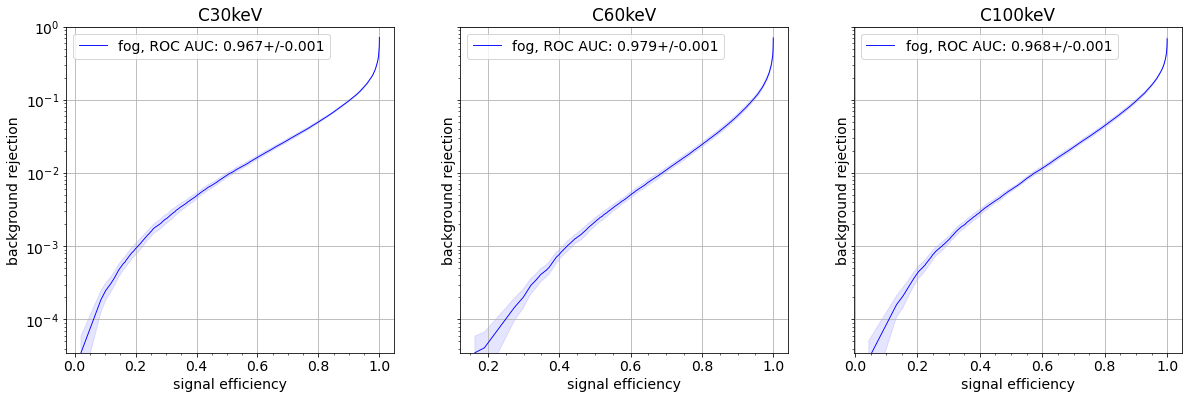

roc plots time: 0:00:14.700795


In [55]:
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

# inter_curves, normal_params = {}, {}, {}
sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
#     normal_params = np.zeros((2, len(mean_pred_curve[0])))
#     normal_params[0] = np.mean(inter_curves[:,1,:], axis=0)
#     normal_params[1] = np.std(inter_curves[:,1,:], axis=0)
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    
#     print(s, np.mean((mean_curves[s][1]-sigma_curves[s][1])**2),'\n\n')
#     for j in range(inverse_curves[s].shape[-1]):
#         inverse_curves[s][:,j] = get_inverse_interval(*normal_params[:,j])
    gc.collect()

# mean_preds = {s: np.mean(preds[s], axis=0) for s in sign}
# std_preds = {s: np.std(preds[s], axis=0, ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

# up_preds = {s: np.clip(mean_preds[s]+std_preds[s], 0,1) for s in sign}
# low_preds = {s: np.clip(mean_preds[s]-std_preds[s], 0,1) for s in sign}

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    thresh_half = thr[i_half]
    
#     mask_plot = mean_curves[s][0]>0.05
    # for convenience, the main line
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
#     i=0
#     while (not (fpr[mask_plot])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
#     fpr = np.append([(fpr[mask_plot])[i]], (fpr[mask_plot])[i:])
#     tpr = np.append([0.05], (tpr[mask_plot])[i:])
#     sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
#     fpr = np.append([0], fpr)
#     tpr = np.append([0], tpr)
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    #axes[j].plot(mean_curves[s][0],mean_curves[s][1],linewidth=0.9,color='red',label=b+', BEFORE'.format(mean_aucs[s], std_aucs[s]))
    
#     fpr_up = roc_curve(y_true_sb,up_preds[s])
#     fpr_low = roc_curve(y_true_sb,low_preds[s])
    
#     if len(tpr)==len(sigma_curves[s][0]):
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
#     else:
#         axes[j].fill( np.append(tpr[1:],tpr[:0:-1]), np.append(inverse_curves[s][0],(inverse_curves[s][1])[::-1]), color=col[b],alpha=0.1 )
    
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(3.5e-5, 1.0)
    axes[j].set_ylabel('background reduction')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

* no 60 keV

In [9]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C100keV']
col = {'fog':'blue'}
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    y_fog = data_sb['val/labels'][...]

C30keV vs fog
thresh:	 0.9958178289700299 
eff:	 0.23992307692307693 
rej:	6.43e-04
C100keV vs fog
thresh:	 0.9958189864642918 
eff:	 0.3040769230769231 
rej:	6.43e-04


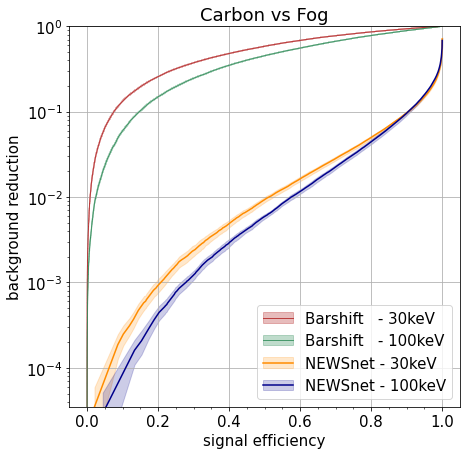

roc plots time: 0:00:13.198443


In [67]:
bckg = ['fog']; sign = ['C30keV','C100keV']
ensemble_size = 10
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

# inter_curves, normal_params = {}, {}, {}
sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))

    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

### PLOTTING
ml_pl, ml_fil = {},{}
ml_col = {'C30keV':'darkorange','C100keV':'darkblue'}
bar_pl, bar_fil = {},{}
bar_col = {'30keV':'firebrick', '100keV':'seagreen'}

plt.rcParams.update({'font.size': 15})
#fig, axes = plt.subplots(len(sign), 1, figsize=(14//len(sign),14), sharex=True)
plt.figure(figsize=(7,7))
for j,s in enumerate(sign):
    i_half = np.argmin(mean_curves[s][-1]>0.996)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    thresh_half = thr[i_half]

#     mask_plot = mean_curves[s][0]>0.05
    # for convenience, the main line
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    ml_pl[s], = plt.plot(tpr,fpr,linewidth=1.5,color=ml_col[s])#,label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    # ml_fil[s] =  plt.fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=ml_col[s],alpha=0.3 )
    ml_fil[s] =  plt.fill_between( tpr, fpr-sigm,fpr+sigm, color=ml_col[s],alpha=0.2 )
    # axes[j].legend(loc=2)
    # axes[j].grid()
    # axes[j].minorticks_on()
    # axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    # axes[j].set_ylim(3.5e-5, 1.0)
    # axes[j].set_ylabel('background reduction')
    # axes[j].set_yscale('log')
    # axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')

### BARSHIFT PLOTS
columns = ['Row', 'PolID', 'BarShift', 'Phi', 'Isolated']

bar_data = {}
kevs = ['30keV','100keV']
degrs = ['test']
with h5py.File('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/barphi.h5','r') as df:
    for k in kevs:
        data_tmp = None
        for d in degrs:
            sample = k+'/'+d
            if data_tmp is None:
                data_tmp = pd.DataFrame(df['Carbon/'+sample][...], columns=columns)
            else:
                data_tmp = pd.concat([data_tmp, pd.DataFrame(df['Carbon/'+sample][...], columns=columns)], ignore_index=True)
        data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
        bar_data[k] = data_tmp.loc[:, ['BarShift','Phi']]
    data_tmp = pd.DataFrame(df['fog/train'][...], columns=columns)
    data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
    bar_data['fog'] = data_tmp.loc[:, ['BarShift','Phi']]

for name in bar_data.keys():
    bar_data[name]['target'] = bar_data[name].loc[:,'BarShift']/0.15
    bar_data[name] = bar_data[name][ bar_data[name]['target']<=1 ]
for i, k in enumerate(bar_col.keys()):
    # if 'fog' in k: continue
    y_true = np.append(np.ones(bar_data[k].shape[0]), np.zeros(bar_data['fog'].shape[0]))
    y_pred = np.append(bar_data[k]['target'], bar_data['fog']['target'])
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    bar_pl[k], = plt.plot(tpr, fpr, linewidth=0.9, alpha=0.9, color=bar_col[k])
    sigma_fpr = np.sqrt( fpr*(1-fpr)/bar_data['fog'].shape[0] )
    bar_fil[k] = plt.fill_between(tpr, np.clip(fpr-sigma_fpr, 0,1), np.clip(fpr+sigma_fpr, 0,1), alpha=0.3, color=bar_col[k])
    # if '100' in k:
    #     thresh = thr[np.argmax(tpr>0.3)]*0.15
    #     sigma_tpr = np.sqrt( tpr*(1-tpr)/bar_data['fog'].shape[0] )
    #     thr_up = thr[np.argmax(tpr+sigma_tpr>0.3)]*0.15
    #     thr_down = thr[np.argmax(tpr-sigma_tpr>0.3)]*0.15
    #     print('ROC thresh 30%: {:.1f}+/-({:.1f},{:.1f}) nm'.format(thresh*1000, thr_up*1000, thr_down*1000))
plt.grid()
plt.minorticks_on()
legend_handles = [(bar_pl[k], bar_fil[k]) for k in bar_col.keys()] + [(ml_pl[s], ml_fil[s]) for s in ml_col.keys()]
legend_labels = ['Barshift   - '+k for k in bar_col.keys()] + ['NEWSnet - '+k for k in bar_col.keys()]
plt.legend(legend_handles, legend_labels, loc=4)
# plt.legend()
plt.xlabel('signal efficiency')
plt.ylabel('background reduction')
plt.yscale('log')
plt.ylim(3.5e-5, 1.0)
plt.title('Carbon vs Fog')

plt.savefig(save_dir+'ml_bar_roc.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

In [24]:
[(bar_pl[k], bar_fil[k]) for k in bar_col.keys()] + [(ml_pl[s], ml_fil[s]) for s in ml_col.keys()]

[(<matplotlib.lines.Line2D at 0x7f3ec879c5d0>,
  <matplotlib.collections.PolyCollection at 0x7f3ec879ca90>),
 (<matplotlib.lines.Line2D at 0x7f3ec879cf50>,
  <matplotlib.collections.PolyCollection at 0x7f3ec879a3d0>),
 (<matplotlib.lines.Line2D at 0x7f3ec8bf0710>,
  [<matplotlib.patches.Polygon at 0x7f3ec8bf0b50>]),
 (<matplotlib.lines.Line2D at 0x7f3ec879c8d0>,
  [<matplotlib.patches.Polygon at 0x7f3ec879c510>])]

C30keV vs fog
thresh:	 0.9929869987070561 
eff:	 0.3130769230769231 
rej:	1.43e-03
C100keV vs fog
thresh:	 0.9929867632687092 
eff:	 0.3811538461538462 
rej:	1.43e-03


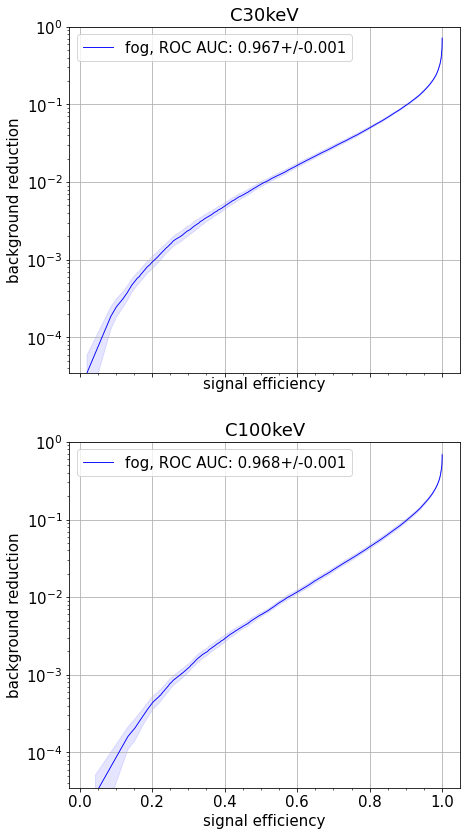

roc plots time: 0:00:23.789155


In [9]:
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

# inter_curves, normal_params = {}, {}, {}
sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
#     normal_params = np.zeros((2, len(mean_pred_curve[0])))
#     normal_params[0] = np.mean(inter_curves[:,1,:], axis=0)
#     normal_params[1] = np.std(inter_curves[:,1,:], axis=0)
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    
#     print(s, np.mean((mean_curves[s][1]-sigma_curves[s][1])**2),'\n\n')
#     for j in range(inverse_curves[s].shape[-1]):
#         inverse_curves[s][:,j] = get_inverse_interval(*normal_params[:,j])
    gc.collect()

# mean_preds = {s: np.mean(preds[s], axis=0) for s in sign}
# std_preds = {s: np.std(preds[s], axis=0, ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

# up_preds = {s: np.clip(mean_preds[s]+std_preds[s], 0,1) for s in sign}
# low_preds = {s: np.clip(mean_preds[s]-std_preds[s], 0,1) for s in sign}

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(len(sign), 1, figsize=(14//len(sign),14), sharex=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    thresh_half = thr[i_half]
    
#     mask_plot = mean_curves[s][0]>0.05
    # for convenience, the main line
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
#     i=0
#     while (not (fpr[mask_plot])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
#     fpr = np.append([(fpr[mask_plot])[i]], (fpr[mask_plot])[i:])
#     tpr = np.append([0.05], (tpr[mask_plot])[i:])
#     sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
#     fpr = np.append([0], fpr)
#     tpr = np.append([0], tpr)
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    #axes[j].plot(mean_curves[s][0],mean_curves[s][1],linewidth=0.9,color='red',label=b+', BEFORE'.format(mean_aucs[s], std_aucs[s]))
    
#     fpr_up = roc_curve(y_true_sb,up_preds[s])
#     fpr_low = roc_curve(y_true_sb,low_preds[s])
    
#     if len(tpr)==len(sigma_curves[s][0]):
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
#     else:
#         axes[j].fill( np.append(tpr[1:],tpr[:0:-1]), np.append(inverse_curves[s][0],(inverse_curves[s][1])[::-1]), color=col[b],alpha=0.1 )
    
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(3.5e-5, 1.0)
    axes[j].set_ylabel('background reduction')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc_vert.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

In [50]:
s = 'C60keV'
mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
y_true_sb = y_fog[mask]<n_sig_cl
np.unique(y_true_sb, return_counts=True)

(array([False,  True]), array([34216, 26000]))

In [33]:
thresh_half = 0.9975

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.232 +/- 0.037
C100keV  	 val score: 0.301 +/- 0.034
fog 		 val score: 1.4e-03 +/- 4.6e-04


In [36]:
thresh_half = 0.99752

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.231 +/- 0.037
C100keV  	 val score: 0.300 +/- 0.034
fog 		 val score: 1.4e-03 +/- 4.5e-04


In [8]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C100keV']
col = {'fog':'blue'}
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    y_fog = data_sb['val/labels'][...]

In [11]:
thresh_half = 0.998

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.205 +/- 0.035
C100keV  	 val score: 0.272 +/- 0.033
fog 		 val score: 1.0e-03 +/- 3.6e-04


In [12]:
thresh_half = 0.999

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.133 +/- 0.029
C100keV  	 val score: 0.192 +/- 0.030
fog 		 val score: 4.1e-04 +/- 1.8e-04


In [13]:
thresh_half = 0.9995

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.080 +/- 0.020
C100keV  	 val score: 0.128 +/- 0.025
fog 		 val score: 1.8e-04 +/- 8.8e-05


In [16]:
thresh_half = 0.9996

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.067 +/- 0.017
C100keV  	 val score: 0.112 +/- 0.023
fog 		 val score: 1.4e-04 +/- 8.1e-05


* 1e-4

In [17]:
thresh_half = 0.9997

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.053 +/- 0.014
C100keV  	 val score: 0.093 +/- 0.020
fog 		 val score: 1.1e-04 +/- 6.7e-05


In [15]:
thresh_half = 0.9999

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('old_networks/predictions/'):
    pred_name = 'old_networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.019 +/- 0.006
C100keV  	 val score: 0.042 +/- 0.012
fog 		 val score: 2.6e-05 +/- 2.0e-05


In [18]:
thresh_half = 0.996

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.293 +/- 0.039
C100keV  	 val score: 0.365 +/- 0.034
fog 		 val score: 2.4e-03 +/- 7.3e-04


## TEST DATA

* saving test predictions

In [54]:
test_pred_path = 'networks/test_predictions/'
if not os.path.exists(test_pred_path):
    os.makedirs(test_pred_path)
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

start = datetime.now()
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    test_preds = {name:[] for name in test_classes}
    for name in test_classes:
        print('testing ',name)
#     for name in df['test'].keys():
        for chp_weights_name in tqdm(ensemble):
            best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
            best_kek.load_weights(chp_weights_name)
            
#             with capture_output() as caput:
            pols = df['test/'+name+'/pol_ids'][...]
            mask = np.arange(pols.shape[0])[pols[:,-2]==-1]
            pred = best_kek.predict_proba(df['test/'+name+'/images'][mask])
            preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)#[mask]
            np.savetxt(test_pred_path+(name.split('/')[-1])+'_predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', preds_sb)
            test_preds[name].append(preds_sb)
            del best_kek; gc.collect();
        test_preds[name] = np.array(test_preds[name])
print('testing time:', datetime.now()-start,'\n')


  0%|          | 0/10 [00:00<?, ?it/s]

testing  Carbon/30keV
71118/71118 [==============================] - 75s 1ms/step


 10%|█         | 1/10 [02:12<19:55, 132.86s/it]

71118/71118 [==============================] - 74s 1ms/step


 20%|██        | 2/10 [04:24<17:37, 132.19s/it]

71118/71118 [==============================] - 75s 1ms/step


 30%|███       | 3/10 [06:38<15:30, 132.94s/it]

71118/71118 [==============================] - 75s 1ms/step


 40%|████      | 4/10 [08:51<13:17, 132.90s/it]

71118/71118 [==============================] - 74s 1ms/step


 50%|█████     | 5/10 [11:02<11:01, 132.35s/it]

71118/71118 [==============================] - 75s 1ms/step


 60%|██████    | 6/10 [13:14<08:49, 132.35s/it]

71118/71118 [==============================] - 75s 1ms/step


 70%|███████   | 7/10 [15:28<06:37, 132.58s/it]

71118/71118 [==============================] - 75s 1ms/step


 80%|████████  | 8/10 [17:40<04:25, 132.53s/it]

71118/71118 [==============================] - 74s 1ms/step


 90%|█████████ | 9/10 [19:51<02:12, 132.19s/it]

71118/71118 [==============================] - 75s 1ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

testing  Carbon/60keV
43474/43474 [==============================] - 46s 1ms/step


 10%|█         | 1/10 [02:50<25:36, 170.78s/it]

43474/43474 [==============================] - 46s 1ms/step


 20%|██        | 2/10 [04:41<18:05, 135.66s/it]

43474/43474 [==============================] - 46s 1ms/step


 30%|███       | 3/10 [06:31<14:26, 123.82s/it]

43474/43474 [==============================] - 46s 1ms/step


 40%|████      | 4/10 [08:24<11:56, 119.42s/it]

43474/43474 [==============================] - 46s 1ms/step


 50%|█████     | 5/10 [10:14<09:40, 116.13s/it]

43474/43474 [==============================] - 46s 1ms/step


 60%|██████    | 6/10 [12:04<07:36, 114.07s/it]

43474/43474 [==============================] - 47s 1ms/step


 70%|███████   | 7/10 [13:57<05:40, 113.56s/it]

43474/43474 [==============================] - 46s 1ms/step


 80%|████████  | 8/10 [15:50<03:47, 113.51s/it]

43474/43474 [==============================] - 46s 1ms/step


 90%|█████████ | 9/10 [17:40<01:52, 112.52s/it]

43474/43474 [==============================] - 46s 1ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

testing  Carbon/100keV
41872/41872 [==============================] - 45s 1ms/step


 10%|█         | 1/10 [02:00<18:06, 120.74s/it]

41872/41872 [==============================] - 45s 1ms/step


 20%|██        | 2/10 [03:23<13:05, 98.22s/it] 

41872/41872 [==============================] - 45s 1ms/step


 30%|███       | 3/10 [04:45<10:35, 90.85s/it]

41872/41872 [==============================] - 45s 1ms/step


 40%|████      | 4/10 [06:06<08:42, 87.06s/it]

41872/41872 [==============================] - 45s 1ms/step


 50%|█████     | 5/10 [07:29<07:07, 85.46s/it]

41872/41872 [==============================] - 45s 1ms/step


 60%|██████    | 6/10 [08:50<05:36, 84.15s/it]

41872/41872 [==============================] - 44s 1ms/step


 70%|███████   | 7/10 [10:12<04:10, 83.42s/it]

41872/41872 [==============================] - 44s 1ms/step


 80%|████████  | 8/10 [11:33<02:45, 82.61s/it]

41872/41872 [==============================] - 45s 1ms/step


 90%|█████████ | 9/10 [12:55<01:22, 82.27s/it]

41872/41872 [==============================] - 44s 1ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

testing  fog
48253/48253 [==============================] - 51s 1ms/step


 10%|█         | 1/10 [01:44<15:37, 104.16s/it]

48253/48253 [==============================] - 51s 1ms/step


 20%|██        | 2/10 [02:57<11:26, 85.83s/it] 

48253/48253 [==============================] - 51s 1ms/step


 30%|███       | 3/10 [04:09<09:18, 79.75s/it]

48253/48253 [==============================] - 52s 1ms/step


 40%|████      | 4/10 [05:23<07:44, 77.39s/it]

48253/48253 [==============================] - 51s 1ms/step


 50%|█████     | 5/10 [06:36<06:19, 75.83s/it]

48253/48253 [==============================] - 51s 1ms/step


 60%|██████    | 6/10 [07:49<04:59, 74.76s/it]

48253/48253 [==============================] - 51s 1ms/step


 70%|███████   | 7/10 [09:02<03:42, 74.15s/it]

48253/48253 [==============================] - 51s 1ms/step


 80%|████████  | 8/10 [10:15<02:27, 73.83s/it]

48253/48253 [==============================] - 52s 1ms/step


 90%|█████████ | 9/10 [11:29<01:13, 73.95s/it]

48253/48253 [==============================] - 51s 1ms/step


100%|██████████| 10/10 [12:42<00:00, 76.26s/it]

testing time: 1:08:34.265042 



In [13]:
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    print(df['test/gamma'].keys())

<KeysViewHDF5 ['images', 'pol_ids']>


In [15]:
test_pred_path = 'networks/test_predictions/'
if not os.path.exists(test_pred_path):
    os.makedirs(test_pred_path)
test_classes = ['gamma']

start = datetime.now()
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    test_preds = {name:[] for name in test_classes}
    for name in test_classes:
        print('testing ',name)
#     for name in df['test'].keys():
        for chp_weights_name in tqdm(ensemble):
            best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
            best_kek.load_weights(chp_weights_name)
            
#             with capture_output() as caput:
            pols = df['test/'+name+'/pol_ids'][...]
            mask = np.arange(pols.shape[0])[pols[:,-2]==-1]
            pred = best_kek.predict_proba(df['test/'+name+'/images'][mask])
            preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)#[mask]
            np.savetxt(test_pred_path+(name.split('/')[-1])+'_predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', preds_sb)
            test_preds[name].append(preds_sb)
            del best_kek; gc.collect();
        test_preds[name] = np.array(test_preds[name])
print('testing time:', datetime.now()-start,'\n')


  0%|          | 0/10 [00:00<?, ?it/s]

testing  gamma
24434/24434 [==============================] - 33s 1ms/step


 10%|█         | 1/10 [01:21<12:10, 81.11s/it]

24434/24434 [==============================] - 27s 1ms/step


 20%|██        | 2/10 [02:06<07:59, 59.98s/it]

24434/24434 [==============================] - 27s 1ms/step


 30%|███       | 3/10 [02:51<06:12, 53.15s/it]

24434/24434 [==============================] - 27s 1ms/step


 40%|████      | 4/10 [03:36<05:00, 50.08s/it]

24434/24434 [==============================] - 27s 1ms/step


 50%|█████     | 5/10 [04:21<04:01, 48.25s/it]

24434/24434 [==============================] - 27s 1ms/step


 60%|██████    | 6/10 [05:06<03:08, 47.16s/it]

24434/24434 [==============================] - 27s 1ms/step


 70%|███████   | 7/10 [05:51<02:19, 46.53s/it]

24434/24434 [==============================] - 27s 1ms/step


 80%|████████  | 8/10 [06:37<01:32, 46.09s/it]

24434/24434 [==============================] - 27s 1ms/step


 90%|█████████ | 9/10 [07:22<00:45, 45.89s/it]

24434/24434 [==============================] - 27s 1ms/step


100%|██████████| 10/10 [08:08<00:00, 48.81s/it]

testing time: 0:08:08.142835 



* loading test predictions

In [18]:
len(os.listdir('old_networks/test_predictions/'))

50

In [19]:
ensemble_size = 10
weight_names = os.listdir('old_networks/checkpoints/')
epochs, losses = np.zeros(len(weight_names), dtype=int), np.zeros(len(weight_names))
for i, name in enumerate(weight_names):
    epochs[i] = int(name.split('-')[0][-2:])
    losses[i] = float(name.split('-')[1][:-3])
mask_sort = np.argsort(epochs)
epochs = epochs[mask_sort]; losses = losses[mask_sort]
ensemble = []
last_ep = -1
while len(ensemble)<ensemble_size:
    if losses[last_ep]<=0.6:
        chp_name = '{:02d}-{:.2f}'.format(epochs[last_ep], losses[last_ep])  #(str(epochs[last_ep]) if epochs[last_ep]>9 else '0'+str(epochs[last_ep]))
        ensemble.append('old_networks/checkpoints/ensemble_estimators'+chp_name+'.h5')
    last_ep -= 1
print(len(ensemble), ensemble)

10 ['old_networks/checkpoints/ensemble_estimators60-0.58.h5', 'old_networks/checkpoints/ensemble_estimators59-0.59.h5', 'old_networks/checkpoints/ensemble_estimators57-0.58.h5', 'old_networks/checkpoints/ensemble_estimators56-0.60.h5', 'old_networks/checkpoints/ensemble_estimators54-0.60.h5', 'old_networks/checkpoints/ensemble_estimators53-0.60.h5', 'old_networks/checkpoints/ensemble_estimators52-0.58.h5', 'old_networks/checkpoints/ensemble_estimators50-0.58.h5', 'old_networks/checkpoints/ensemble_estimators49-0.60.h5', 'old_networks/checkpoints/ensemble_estimators48-0.60.h5']


In [20]:
test_pred_path = 'old_networks/test_predictions/'
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']
test_preds = {name:[] for name in test_classes}
for name in test_classes:
    for chp_weights_name in ensemble:
        test_preds[name].append(np.loadtxt(test_pred_path+(name.split('/')[-1])+'_predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt'))
    test_preds[name] = np.array(test_preds[name])

In [44]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.99752

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.122 +/- 0.028
Carbon/60keV 	 test score: 0.411 +/- 0.040
Carbon/100keV 	 test score: 0.311 +/- 0.033
fog 		 test score: 2.7e-04 +/- 8.1e-05


* 1e-4

In [21]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.9997

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.024 +/- 0.010
Carbon/60keV 	 test score: 0.190 +/- 0.027
Carbon/100keV 	 test score: 0.103 +/- 0.023
fog 		 test score: 3.9e-05 +/- 1.9e-05


In [21]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.996

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.162 +/- 0.031
Carbon/60keV 	 test score: 0.475 +/- 0.040
Carbon/100keV 	 test score: 0.374 +/- 0.033
fog 		 test score: 4.2e-04 +/- 1.3e-04


In [20]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.9988

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.074 +/- 0.022
Carbon/60keV 	 test score: 0.321 +/- 0.037
Carbon/100keV 	 test score: 0.225 +/- 0.031
fog 		 test score: 1.5e-04 +/- 6.0e-05


In [23]:
categ_dict_test = {'Carbon/30keV': 0, 'Carbon/60keV': 1, 'Carbon/100keV': 2, 'fog': 3}
sign_test = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']

In [25]:
y_test_tot = np.hstack([np.ones(test_preds[name].shape[-1])*categ_dict_test[name] for name in test_classes])
test_preds_tot = np.hstack([test_preds[name] for name in test_classes])
print(y_test_tot.shape,'\t',test_preds_tot.shape)
print(np.unique(y_test_tot, return_counts=True))

(204717,) 	 (10, 204717)
(array([0., 1., 2., 3.]), array([71118, 43474, 41872, 48253]))


Carbon/30keV vs fog
thresh:	 0.992995536327362 
eff:	 0.15755504935459377 
rej:	2.49e-04
Carbon/60keV vs fog
thresh:	 0.9928936183452606 
eff:	 0.49707871371394396 
rej:	2.49e-04
Carbon/100keV vs fog
thresh:	 0.9927581667900085 
eff:	 0.38918609094382883 
rej:	2.49e-04


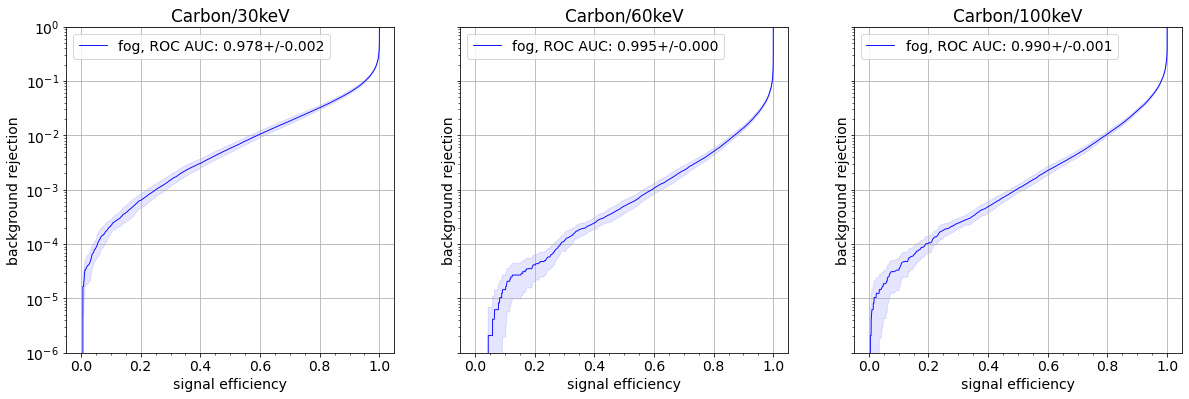

roc plots time: 0:00:04.200321


In [27]:
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'
sign = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']
n_sig_cl = 3
col = {'fog':'blue'}

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
b = 'fog'
for s in sign:
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    preds0 = (test_preds_tot.T)[mask]
    y_true_sb = y_test_tot[mask]<n_sig_cl
    #preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    preds[s] = preds0.T
    aucs[s] = [roc_auc_score(y_true_sb, pr) for pr in preds0.T]

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    y_true_sb = y_test_tot[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        #f_mask = fpr>0
        #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value=(fpr[0], fpr[-1]) ))#'extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    #f_mask = fpr>0
    #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    #thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
   
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(1e-6, 1.0)
    axes[j].set_ylabel('background rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc_pol_test.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

### Sizes of Datasets

In [45]:
dset

'/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'

In [53]:
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
print(class_dict,'\n')
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    for data_cl in ['train','val']:
        print(data_cl.upper())
        print(np.unique(data_sb[data_cl+'/labels'], return_counts=True))
        print()
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']
print('TEST')
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    for name in test_classes:
        print(name,'\t' if name!='fog' else '\t\t', df['test/'+name+'/images'].shape)

{0: 'C30keV', 1: 'C60keV', 2: 'C100keV', 3: 'fog'} 

TRAIN
(array([0, 1, 2, 3]), array([39000, 39000, 39000, 51324]))

VAL
(array([0, 1, 2, 3]), array([26000, 26000, 26000, 34216]))

TEST
Carbon/30keV 	 (95310, 40, 40, 9)
Carbon/60keV 	 (108157, 40, 40, 9)
Carbon/100keV 	 (70813, 40, 40, 9)
fog 		 (57966, 40, 40, 9)


In [61]:
8e-5**-1

12499.999999999998

In [57]:
39/(39+26)

0.6

In [60]:
39+26

65

## Gamma TEST check

In [23]:
test_pred_path = 'networks/test_predictions/'
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog', 'gamma']
test_preds = {name:[] for name in test_classes}
for name in test_classes:
    for chp_weights_name in ensemble:
        test_preds[name].append(np.loadtxt(test_pred_path+(name.split('/')[-1])+'_predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt'))
    test_preds[name] = np.array(test_preds[name])

In [24]:
test_preds

{'Carbon/30keV': array([[0.98618269, 0.87350744, 0.32489824, ..., 0.95508122, 0.99936861,
         0.93488991],
        [0.99601138, 0.86404622, 0.22394142, ..., 0.95710868, 0.99909902,
         0.9406994 ],
        [0.98573005, 0.90531635, 0.3852624 , ..., 0.93151116, 0.93502891,
         0.93878591],
        ...,
        [0.9950422 , 0.81951576, 0.54616058, ..., 0.95862114, 0.99533039,
         0.56961399],
        [0.98424697, 0.88337654, 0.6868937 , ..., 0.95557344, 0.99949646,
         0.24488902],
        [0.97470927, 0.71539551, 0.33757615, ..., 0.89169908, 0.9703843 ,
         0.43716502]]),
 'Carbon/60keV': array([[0.99413627, 0.954009  , 0.97624719, ..., 0.45603198, 0.99999934,
         0.99690557],
        [0.99640167, 0.92972106, 0.86290526, ..., 0.21332991, 0.99999583,
         0.99810123],
        [0.99618351, 0.95456892, 0.9843632 , ..., 0.55326563, 0.99999738,
         0.99559426],
        ...,
        [0.99816495, 0.95193619, 0.80205369, ..., 0.6084314 , 0.99999487,
  

In [25]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.996

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog', 'gamma']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if 'keV' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.162 +/- 0.031
Carbon/60keV 	 test score: 0.475 +/- 0.040
Carbon/100keV 	 test score: 0.374 +/- 0.033
fog 		 test score: 4.2e-04 +/- 1.3e-04
gamma 		 test score: 2.8e-03 +/- 7.5e-04


In [26]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.9988

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog', 'gamma']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if 'keV' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.074 +/- 0.022
Carbon/60keV 	 test score: 0.321 +/- 0.037
Carbon/100keV 	 test score: 0.225 +/- 0.031
fog 		 test score: 1.5e-04 +/- 6.0e-05
gamma 		 test score: 1.0e-03 +/- 3.3e-04


In [30]:
categ_dict_test = {'Carbon/30keV': 0, 'Carbon/60keV': 1, 'Carbon/100keV': 2, 'fog': 3, 'gamma': 4}
sign_test = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']

In [31]:
y_test_tot = np.hstack([np.ones(test_preds[name].shape[-1])*categ_dict_test[name] for name in test_classes])
test_preds_tot = np.hstack([test_preds[name] for name in test_classes])
print(y_test_tot.shape,'\t',test_preds_tot.shape)
print(np.unique(y_test_tot, return_counts=True))

(229151,) 	 (10, 229151)
(array([0., 1., 2., 3., 4.]), array([71118, 43474, 41872, 48253, 24434]))


Carbon/30keV vs fog
thresh:	 0.992995536327362 
eff:	 0.15755504935459377 
rej:	2.49e-04
Carbon/60keV vs fog
thresh:	 0.9928936183452606 
eff:	 0.49707871371394396 
rej:	2.49e-04
Carbon/100keV vs fog
thresh:	 0.9927581667900085 
eff:	 0.38918609094382883 
rej:	2.49e-04
Carbon/30keV vs gamma
thresh:	 0.992995536327362 
eff:	 0.15755504935459377 
rej:	2.01e-03
Carbon/60keV vs gamma
thresh:	 0.9929833352565766 
eff:	 0.4948704973087363 
rej:	2.01e-03
Carbon/100keV vs gamma
thresh:	 0.9929832756519318 
eff:	 0.38507833397019486 
rej:	2.01e-03


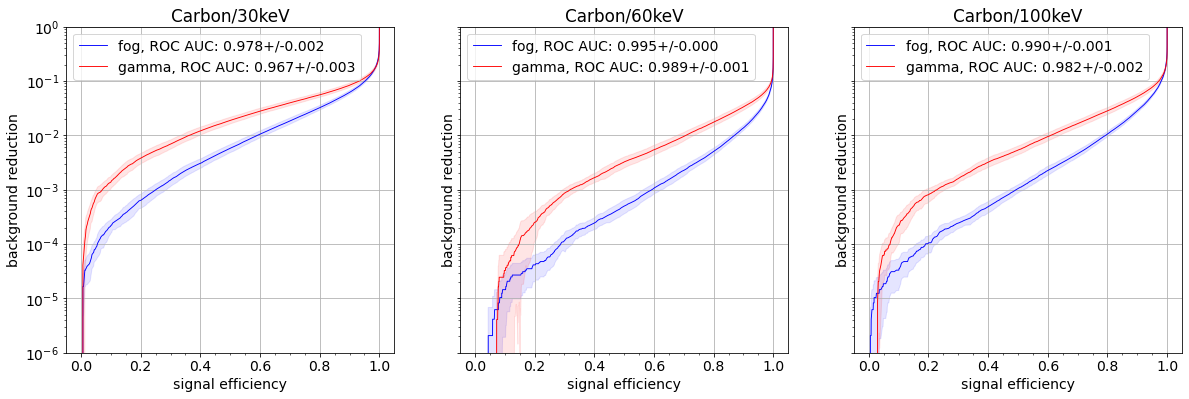

roc plots time: 0:00:04.421063


In [33]:
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'
sign = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']
n_sig_cl = 3
col = {'fog':'blue', 'gamma':'red'}

import scipy.interpolate
start = datetime.now()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)


preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
b = 'fog'
for s in sign:
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    preds0 = (test_preds_tot.T)[mask]
    y_true_sb = y_test_tot[mask]<n_sig_cl
    #preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    preds[s] = preds0.T
    aucs[s] = [roc_auc_score(y_true_sb, pr) for pr in preds0.T]

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    y_true_sb = y_test_tot[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        #f_mask = fpr>0
        #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value=(fpr[0], fpr[-1]) ))#'extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    #f_mask = fpr>0
    #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    #thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )

#     axes[j].legend(loc=2)
#     axes[j].grid()
#     axes[j].minorticks_on()
#     axes[j].set_xlabel('signal efficiency')
#     #axes[j].set_xlim(0.05, 1.0)
#     axes[j].set_ylim(1e-6, 1.0)
#     axes[j].set_ylabel('background rejection')
#     axes[j].set_yscale('log')
#     axes[j].set_title(s)
#plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')


preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
b = 'gamma'
for s in sign:
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    preds0 = (test_preds_tot.T)[mask]
    y_true_sb = y_test_tot[mask]<n_sig_cl
    #preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
    preds[s] = preds0.T
    aucs[s] = [roc_auc_score(y_true_sb, pr) for pr in preds0.T]

sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_test_tot==categ_dict_test[b], y_test_tot==categ_dict_test[s])
    y_true_sb = y_test_tot[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        #f_mask = fpr>0
        #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value=(fpr[0], fpr[-1]) ))#'extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    #f_mask = fpr>0
    #fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    gc.collect()

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    #thresh_half = thr[i_half]
    
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
   
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(1e-6, 1.0)
    axes[j].set_ylabel('background reduction')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')


#plt.savefig(save_dir+'ml_roc_pol_test.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

## Checking new cuts on test scans

In [8]:
path_dir = '/mnt/ML-drive/Artem/70nm/Oct2019_N123gf/'
sig_dirs = ['Carbon/30keV/test','Carbon/60keV/test','Carbon/100keV/test']
#bckg_dirs = ['gamma/gamma_check/gamma_opmark_med','fog/Scan17_22.11','fog/Scan18_25.11','fog/Scan19_28.11','fog/Scan21_2.12','fog/Scan22_3.12','fog/Scan23_4.12']
bckg_dirs = ['fog/Scan17','fog/Scan18','fog/Scan19','fog/Scan21','fog/Scan22','fog/Scan23']
n_sig_cl = 3

In [9]:
thresh = 0.996

* generating preds

In [24]:
test_feats = pd.DataFrame(np.zeros((0,10)), columns=['HeadID','ViewID','grID', 'clID','bar_shift','phi','area','bright', 'sample', 'prediction'])
fog_init = False
for name in sig_dirs+bckg_dirs:
    print(name)
    full_feats = pd.read_csv(path_dir+name+'/sig_grains.txt', header=None, names=['HeadID','ViewID','grID', 'clID','bar_shift','phi','area','bright'])
    name = '/'.join(name.split('/')[:-1])
    if not fog_init or name!='fog':
        with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as data_sb:
            preds = np.sum(best_kek.predict_proba(data_sb['test/'+name+'/images'][...])[:,:3], axis=1)
            pols = data_sb['test/'+name+'/pol_ids'][...]
            mask = pols[:,-2]==-1
            preds = np.hstack((pols, preds[:,np.newaxis]))[mask]
            if name=='fog': fog_init = True
    id_mask = np.zeros(len(full_feats.index), dtype=bool)
    feat_preds = np.zeros(len(full_feats.index))
    for v in np.unique(preds[:,1]):
        view_feats = full_feats[full_feats['ViewID']==v]
        view_preds = preds[preds[:,1]==v]
        if not view_feats.shape[0] or not view_preds.shape[0]:
            # if some view is absent - skip
            continue
        for gr in np.unique(view_preds[:,2]):
            gr_feats = view_feats[view_feats['grID']==gr]
            gr_preds = view_preds[view_preds[:,2]==gr]
            if not gr_feats.shape[0] or not gr_preds.shape[0]:
                # if some grain is absent - skip
                continue
            if gr_preds.shape[0]>1:
                for cl in np.unique(gr_preds[:,3]):
                    if not np.sum(gr_preds[:,3]==cl) or not np.sum(gr_feats['clID']==cl) or not (np.sum(gr_preds[:,3]==cl) == np.sum(gr_feats['clID']==cl)):
                        # if cluster_id is absent or ambiguos - skip
                        continue
                    id_mask[gr_feats[gr_feats['clID']==cl].index] = True
                    feat_preds[gr_feats[gr_feats['clID']==cl].index] = (gr_preds[gr_preds[:,3]==cl])[:,-1]
            else:
                if not (len(gr_preds) == len(gr_feats)):
                    # if there is ambiguity - skip
                    continue
                id_mask[gr_feats.index] = True
                feat_preds[gr_feats.index] = gr_preds[:,-1]
    tmp_feats = full_feats.loc[id_mask].reset_index(drop=True)
    tmp_feats.loc[:, 'sample'] = name
    tmp_feats.loc[:, 'prediction'] = feat_preds[id_mask]
    print(tmp_feats.shape)
    test_feats = pd.concat([test_feats, tmp_feats], ignore_index=True)
    gc.collect();

Carbon/30keV/test


NameError: name 'best_kek' is not defined

In [17]:
print(test_feats.shape,'\n', test_feats.columns)

(207726, 10) 
 Index(['HeadID', 'ViewID', 'grID', 'clID', 'bar_shift', 'phi', 'area',
       'bright', 'sample', 'prediction'],
      dtype='object')


In [18]:
print(np.unique(test_feats['sample'], return_counts=True))

(array(['Carbon/100keV', 'Carbon/30keV', 'Carbon/60keV', 'fog'],
      dtype=object), array([41872, 71118, 43154, 51582]))


In [19]:
test_feats.to_csv('test_feats_preds.csv')

* loading preds

In [70]:
test_feats = pd.read_csv('test_feats_preds.csv', index_col=0)

In [71]:
test_feats.head()

,HeadID,ViewID,grID,clID,bar_shift,phi,area,bright,sample,prediction
0,10.0,9.0,0.0,327.0,0.016631,-0.103286,62.0,11.61290,Carbon/30keV,0.998339
1,10.0,9.0,1.0,325.0,0.019935,-1.071580,24.0,4.75000,Carbon/30keV,0.971608
2,10.0,9.0,3.0,321.0,0.028730,-0.238264,26.0,4.03846,Carbon/30keV,0.153866
3,10.0,9.0,5.0,-1.0,0.030641,1.448230,11.0,3.27273,Carbon/30keV,0.998961
4,10.0,9.0,7.0,322.0,0.025300,0.861222,15.0,3.26667,Carbon/30keV,0.951728


In [72]:
test_feats.shape

(207726, 10)

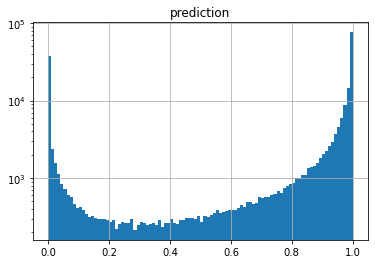

In [13]:
test_feats.hist(column=['prediction'], bins=100)
plt.yscale('log')

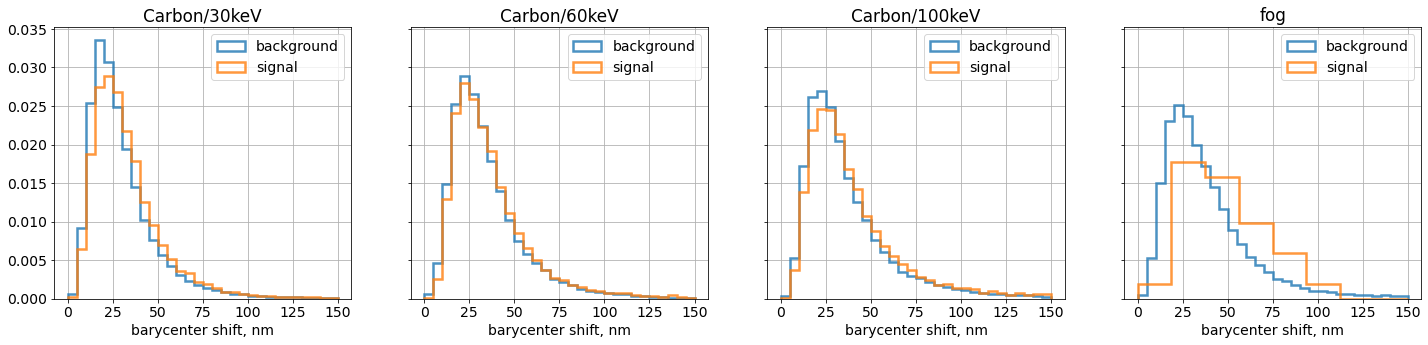

In [97]:
'''
for name, sopa in test_feats.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['bar_shift'], density=True, range=(0,0.3), bins=30, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['bar_shift'], density=True, range=(0,0.3), bins=50, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['bar_shift'], density=True, range=(0,0.3), bins=50, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('barshift')
    plt.legend()
    plt.title(name)
    plt.show()
'''

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'

samples = ['Carbon/30keV','Carbon/60keV','Carbon/100keV','fog']
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,4, sharey=True, figsize=(24.5,5))
for i, name in enumerate(samples):
    sopa = copa[copa['sample']==name]
    ax[i].hist((sopa[sopa['prediction']<0.998])['bar_shift']*1000, density=True, range=(0,150), bins=30, alpha=0.8, histtype='step', linewidth=2.5, label='background')
    if name=='fog':
        ax[i].hist((sopa[sopa['prediction']>0.998])['bar_shift']*1000, density=True, range=(0,150), bins=8, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    else:
        ax[i].hist((sopa[sopa['prediction']>0.998])['bar_shift']*1000, density=True, range=(0,150), bins=30, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title(name)
    #ax[i].set_yscale('log')
    ax[i].set_xlabel('barycenter shift, nm')
    ax[i].legend()
    #print(k, (bar_data[k].BarShift>0.0385).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'ml_bar.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

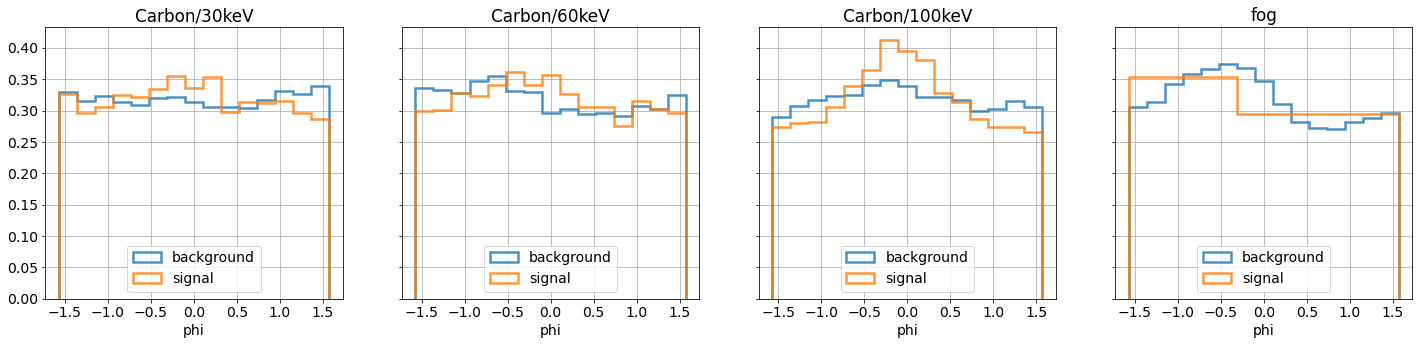

In [96]:
copa = test_feats[test_feats['phi']!=0]
samples = ['Carbon/30keV','Carbon/60keV','Carbon/100keV','fog']
'''
for name, sopa in copa.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=5, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('phi')
    plt.title(name)
    plt.legend()
    plt.show()
'''

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,4, sharey=True, figsize=(24.5,5))
for i, name in enumerate(samples):
    sopa = copa[copa['sample']==name]
    ax[i].hist((sopa[sopa['prediction']<0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=15, alpha=0.8, histtype='step', linewidth=2.5, label='background')
    if name=='fog':
        ax[i].hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=5, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    else:
        ax[i].hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=15, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title(name)
    #ax[i].set_yscale('log')
    ax[i].set_xlabel('phi')
    ax[i].legend(loc=8)
    #print(k, (bar_data[k].BarShift>0.0385).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'ml_phi.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

['Row', 'PolID', 'BarShift', 'Phi', 'Isolated']
Carbon-30keV 0.22797158427844688
Carbon-60keV 0.3242373579103901
Carbon-100keV 0.3814503133393017
fog 0.3115245117793776


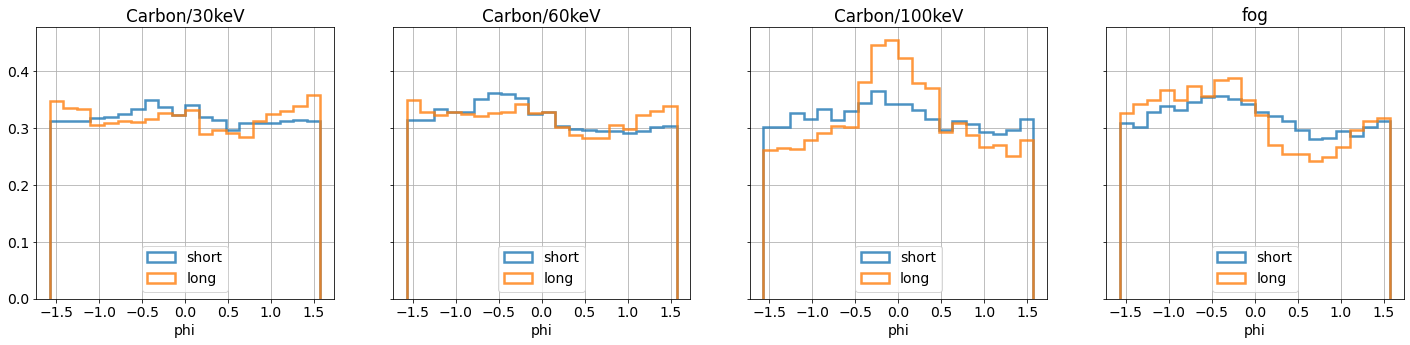

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py, gc

with open('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/columns.txt','r') as colf:
    columns = colf.readline().strip().split(',')
print(columns)

bar_data = {}
kevs = ['30keV','60keV','100keV']
d = '0degr'
with h5py.File('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/barphi.h5','r') as df:
    for k in kevs:
        data_tmp = None
        sample = k+'/'+d
        data_tmp = pd.DataFrame(df['Carbon/'+sample][...], columns=columns)
        data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
        bar_data['Carbon-'+k] = data_tmp.loc[:, ['BarShift','Phi']]
    data_tmp = pd.DataFrame(df['fog/train'][...], columns=columns)
    data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
    bar_data['fog'] = data_tmp.loc[:, ['BarShift','Phi']]
#print(carb[sample].head())

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,4, sharey=True, figsize=(24.5,5))
for i, k in enumerate(bar_data.keys()):
    ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title('/'.join(k.split('-')))
    #ax[i].set_yscale('log')
    ax[i].set_xlabel('phi')
    ax[i].legend(loc=8)
    #ax[i].minorticks_on()
    print(k, (bar_data[k].BarShift>0.0385).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'angle_thresh.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()


* NO 60 KEV

In [68]:
thresh = 0.9975 #0.996

In [73]:
copa = test_feats[test_feats['phi']!=0]
sopa = copa[copa['sample']=='fog']
np.unique(sopa['prediction']>thresh, return_counts=True)

(array([False,  True]), array([51507,    34]))

In [15]:
copa = test_feats[test_feats['phi']!=0]
sopa = copa[copa['sample']=='fog']
np.unique(sopa['prediction']>thresh, return_counts=True)

(array([False,  True]), array([51493,    48]))

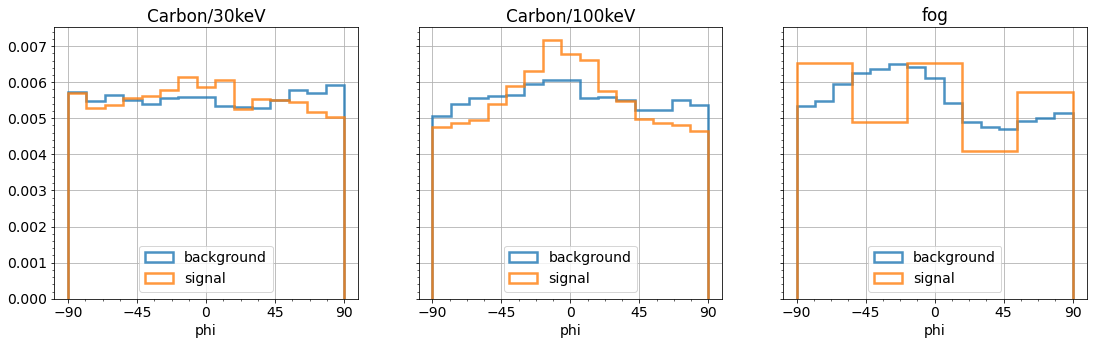

In [79]:
copa = test_feats.copy()#[test_feats['phi']!=0]
samples = ['Carbon/30keV','Carbon/100keV','fog']
'''
for name, sopa in copa.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=5, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('phi')
    plt.title(name)
    plt.legend()
    plt.show()
'''

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'

copa.loc[:,'phi'] *= 180/np.pi
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18.5,5))
for i, name in enumerate(samples):
    sopa = copa[copa['sample']==name]
    ax[i].hist((sopa[sopa['prediction']<thresh])['phi'], density=True, range=(-90,90), bins=15, alpha=0.8, histtype='step', linewidth=2.5, label='background')
    if name=='fog':
        ax[i].hist((sopa[sopa['prediction']>thresh])['phi'], density=True, range=(-90,90), bins=5, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    else:
        ax[i].hist((sopa[sopa['prediction']>thresh])['phi'], density=True, range=(-90,90), bins=15, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title(name)
    xticks = np.arange(-90,91,45)
    ax[i].set_xticks(xticks)
    #ax[i].set_yscale('log')
    ax[i].set_xlabel('phi')
    ax[i].legend(loc=8)
    ax[i].minorticks_on()
    #print(k, (bar_data[k].BarShift>0.0385).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'ml_phi.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

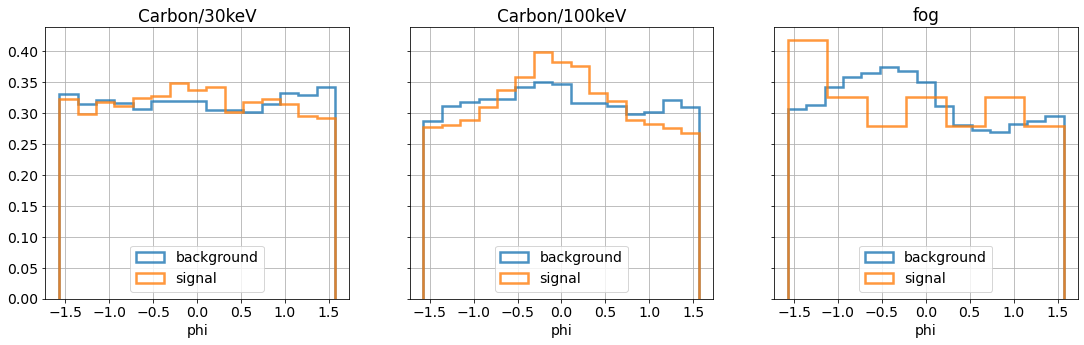

In [25]:
copa = test_feats#[test_feats['phi']!=0]
samples = ['Carbon/30keV','Carbon/100keV','fog']
'''
for name, sopa in copa.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=5, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('phi')
    plt.title(name)
    plt.legend()
    plt.show()
'''

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18.5,5))
for i, name in enumerate(samples):
    sopa = copa[copa['sample']==name]
    ax[i].hist((sopa[sopa['prediction']<thresh])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=15, alpha=0.8, histtype='step', linewidth=2.5, label='background')
    if name=='fog':
        ax[i].hist((sopa[sopa['prediction']>thresh])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=7, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    else:
        ax[i].hist((sopa[sopa['prediction']>thresh])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=15, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title(name)
    #ax[i].set_yscale('log')
    ax[i].set_xlabel('phi')
    ax[i].legend(loc=8)
    #print(k, (bar_data[k].BarShift>0.0385).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'ml_phi.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

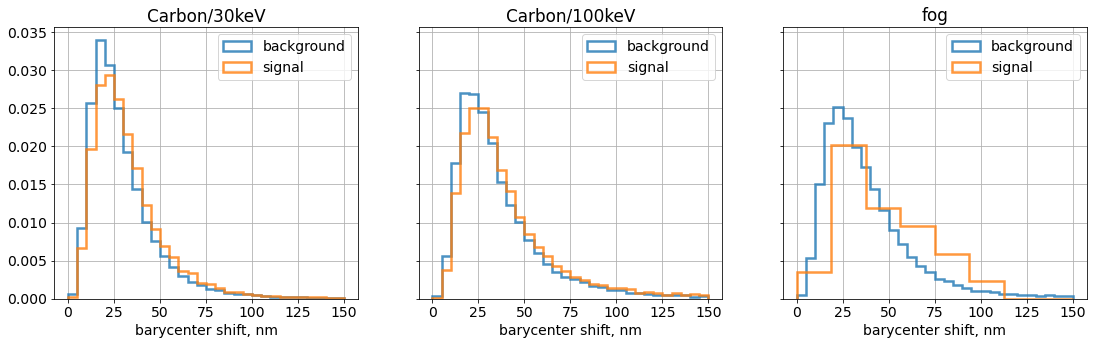

In [44]:
'''
for name, sopa in test_feats.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['bar_shift'], density=True, range=(0,0.3), bins=30, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['bar_shift'], density=True, range=(0,0.3), bins=50, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['bar_shift'], density=True, range=(0,0.3), bins=50, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('barshift')
    plt.legend()
    plt.title(name)
    plt.show()
'''

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'

samples = ['Carbon/30keV','Carbon/100keV','fog']
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18.5,5))
for i, name in enumerate(samples):
    sopa = copa[copa['sample']==name]
    ax[i].hist((sopa[sopa['prediction']<thresh])['bar_shift']*1000, density=True, range=(0,150), bins=30, alpha=0.8, histtype='step', linewidth=2.5, label='background')
    if name=='fog':
        ax[i].hist((sopa[sopa['prediction']>thresh])['bar_shift']*1000, density=True, range=(0,150), bins=8, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    else:
        ax[i].hist((sopa[sopa['prediction']>thresh])['bar_shift']*1000, density=True, range=(0,150), bins=30, alpha=0.8, histtype='step', linewidth=2.5, label='signal')
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    #ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>0.0385], bins=20, range=(-np.pi/2,np.pi/2), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title(name)
    #ax[i].set_yscale('log')
    ax[i].set_xlabel('barycenter shift, nm')
    ax[i].legend()
    #print(k, (bar_data[k].BarShift>0.0385).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'ml_bar.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

In [80]:
bar_thresh = 0.0423

['Row', 'PolID', 'BarShift', 'Phi', 'Isolated']
Carbon-30keV 0.18504209107080138
Carbon-100keV 0.3299910474485228
fog 0.2558134468974982


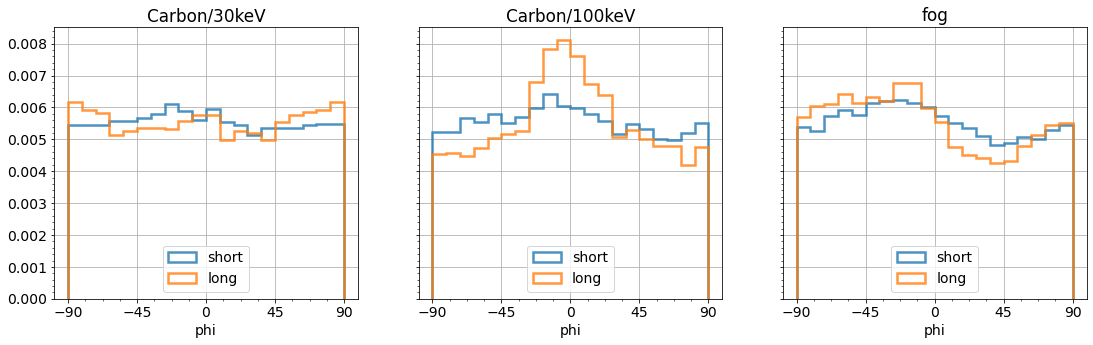

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py, gc

with open('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/columns.txt','r') as colf:
    columns = colf.readline().strip().split(',')
print(columns)

bar_data = {}
kevs = ['30keV','100keV']
d = '0degr'
with h5py.File('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/barphi.h5','r') as df:
    for k in kevs:
        data_tmp = None
        sample = k+'/'+d
        data_tmp = pd.DataFrame(df['Carbon/'+sample][...], columns=columns)
        data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
        bar_data['Carbon-'+k] = data_tmp.loc[:, ['BarShift','Phi']]
    data_tmp = pd.DataFrame(df['fog/train'][...], columns=columns)
    data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
    bar_data['fog'] = data_tmp.loc[:, ['BarShift','Phi']]
for name in bar_data.keys():
    bar_data[name].loc[:,'Phi'] *= 180/np.pi

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18.5,5))
for i, k in enumerate(bar_data.keys()):
    ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<bar_thresh], bins=20, range=(-90,90), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>bar_thresh], bins=20, range=(-90,90), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title('/'.join(k.split('-')))
    #ax[i].set_yscale('log')
    xticks = np.arange(-90,91,45)
    ax[i].set_xticks(xticks)
    ax[i].minorticks_on()
    ax[i].set_xlabel('phi')
    ax[i].legend(loc=8)
    #ax[i].minorticks_on()
    print(k, (bar_data[k].BarShift>bar_thresh).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'angle_thresh.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()


['Row', 'PolID', 'BarShift', 'Phi', 'Isolated']
Carbon-30keV 0.2370696003897531
Carbon-100keV 0.3931244404655327
fog 0.3233311186868962


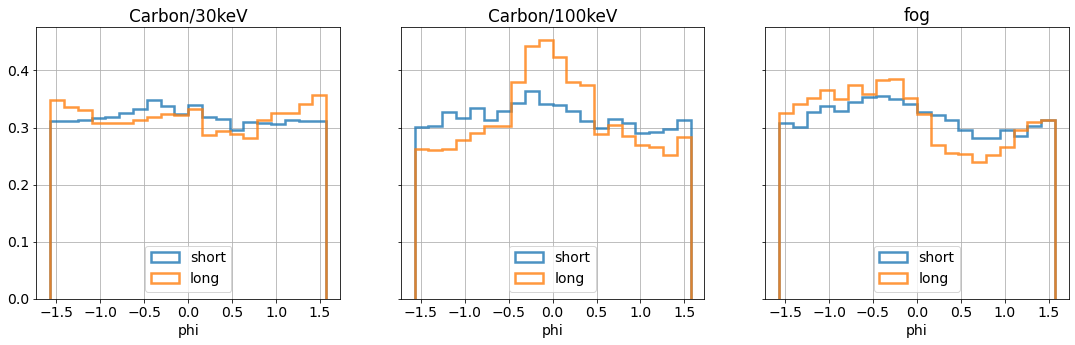

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py, gc

with open('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/columns.txt','r') as colf:
    columns = colf.readline().strip().split(',')
print(columns)

bar_data = {}
kevs = ['30keV','100keV']
d = '0degr'
with h5py.File('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/barphi.h5','r') as df:
    for k in kevs:
        data_tmp = None
        sample = k+'/'+d
        data_tmp = pd.DataFrame(df['Carbon/'+sample][...], columns=columns)
        data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
        bar_data['Carbon-'+k] = data_tmp.loc[:, ['BarShift','Phi']]
    data_tmp = pd.DataFrame(df['fog/train'][...], columns=columns)
    data_tmp = data_tmp[(data_tmp['PolID']==0)&(data_tmp['Isolated']==-1)]
    bar_data['fog'] = data_tmp.loc[:, ['BarShift','Phi']]
for name in bar_data.keys():
    bar_data[name].loc[:,'Phi'] *= 180/np.pi

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18.5,5))
for i, k in enumerate(bar_data.keys()):
    ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift<bar_thresh], bins=20, range=(-90,90), density=True, label='short', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].hist(bar_data[k].Phi[bar_data[k].BarShift>bar_thresh], bins=20, range=(-90,90), density=True, label='long', alpha=0.8, histtype='step', linewidth=2.5)
    ax[i].grid()
    ax[i].set_title('/'.join(k.split('-')))
    #ax[i].set_yscale('log')
    xticks = np.arange(-90,91,45)
    ax[i].set_xticks(xticks)
    ax[i].minorticks_on()
    ax[i].set_xlabel('phi')
    ax[i].legend(loc=8)
    #ax[i].minorticks_on()
    print(k, (bar_data[k].BarShift>bar_thresh).sum()/len(bar_data[k].BarShift))
plt.savefig(save_dir+'angle_thresh.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()


## EVENT IMAGES

### CARBON 100keV

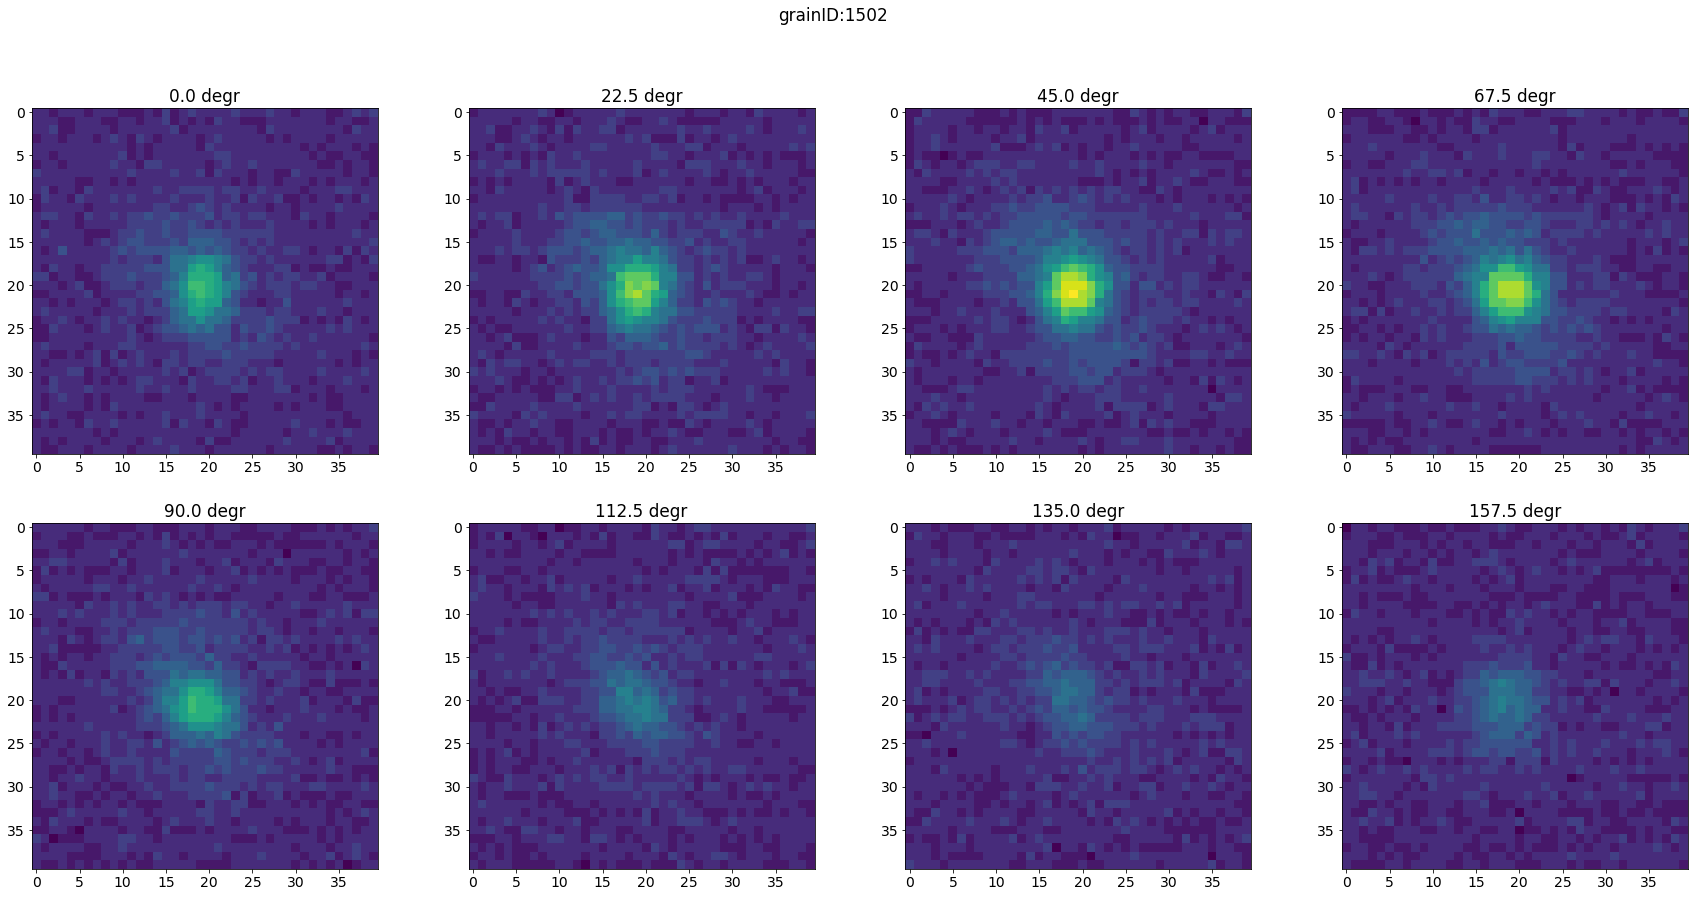

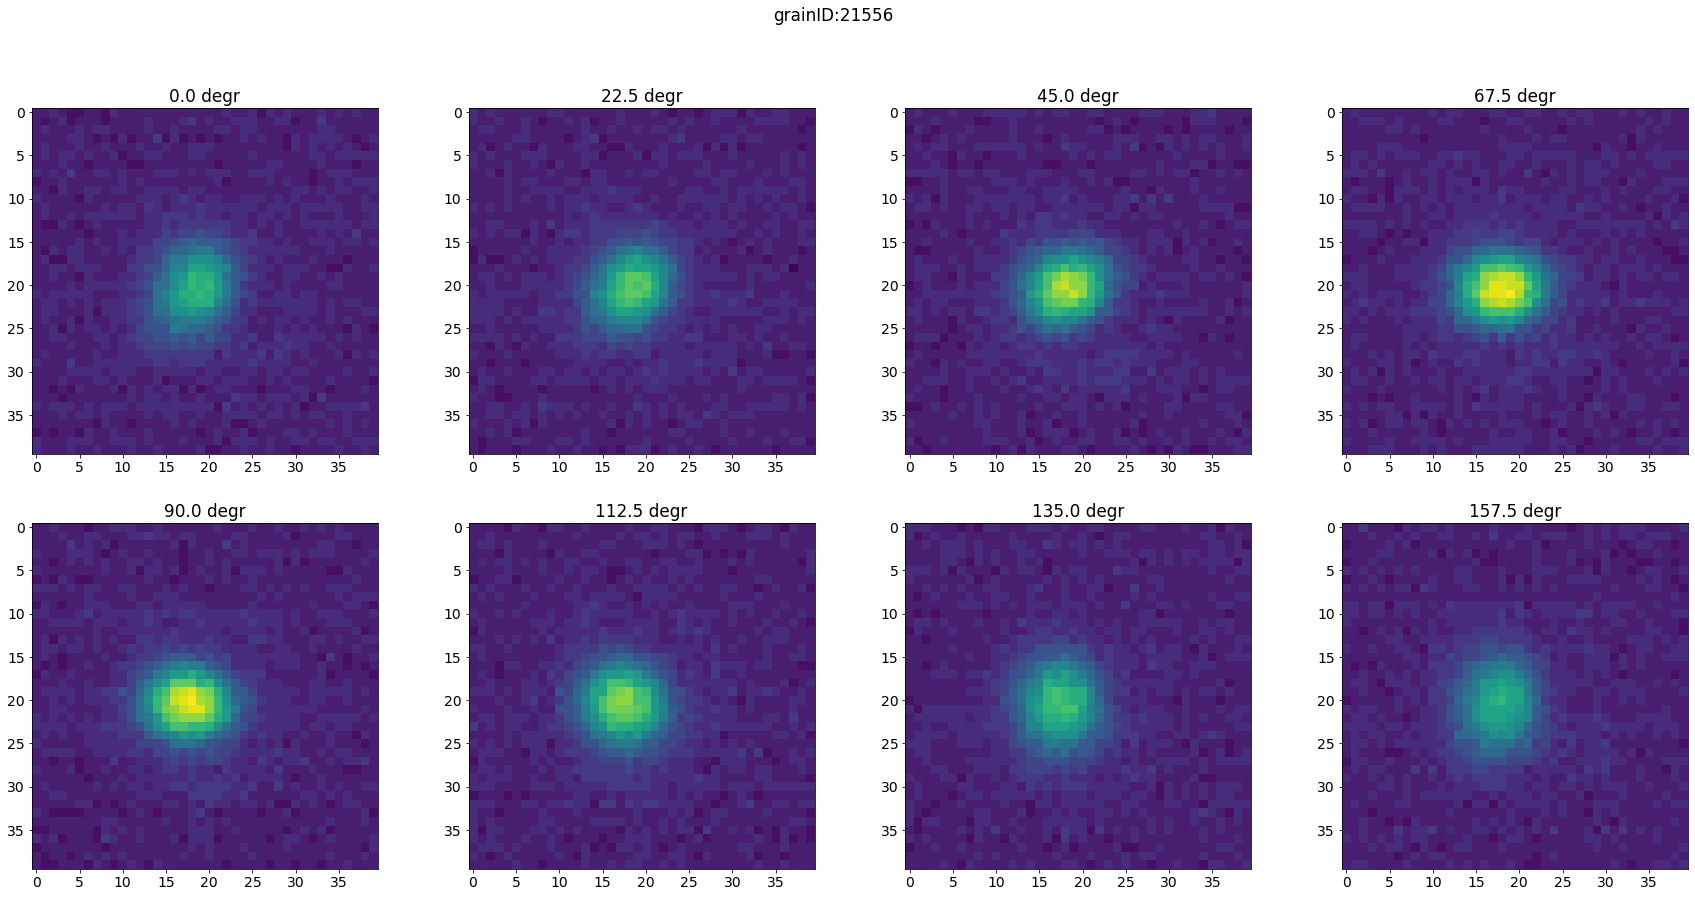

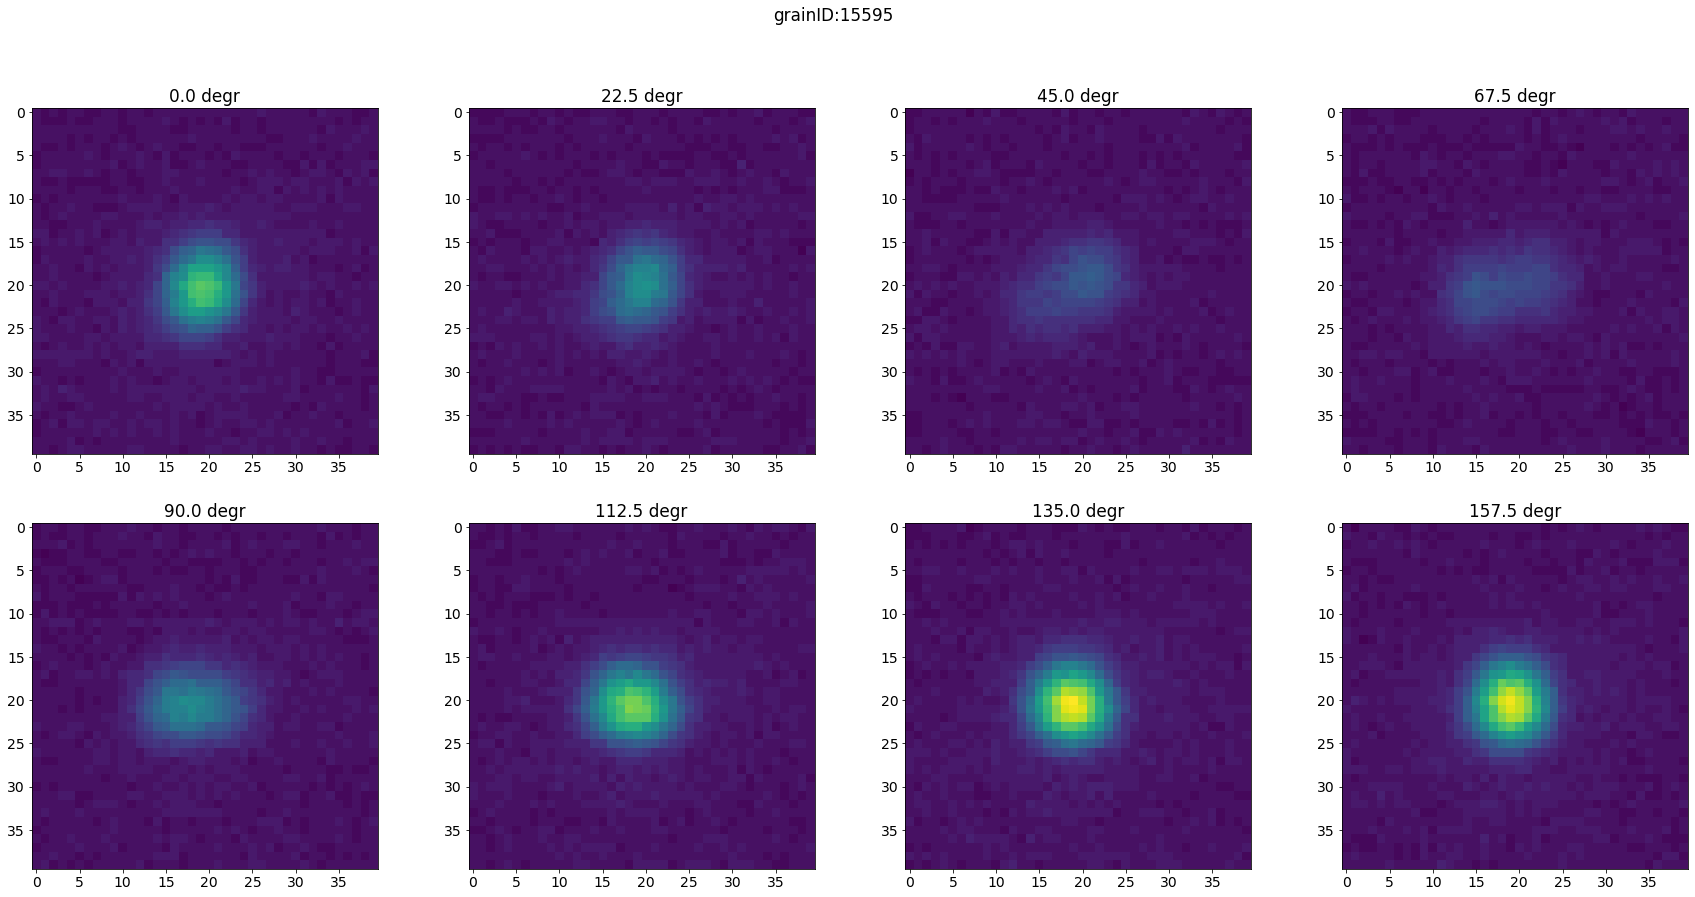

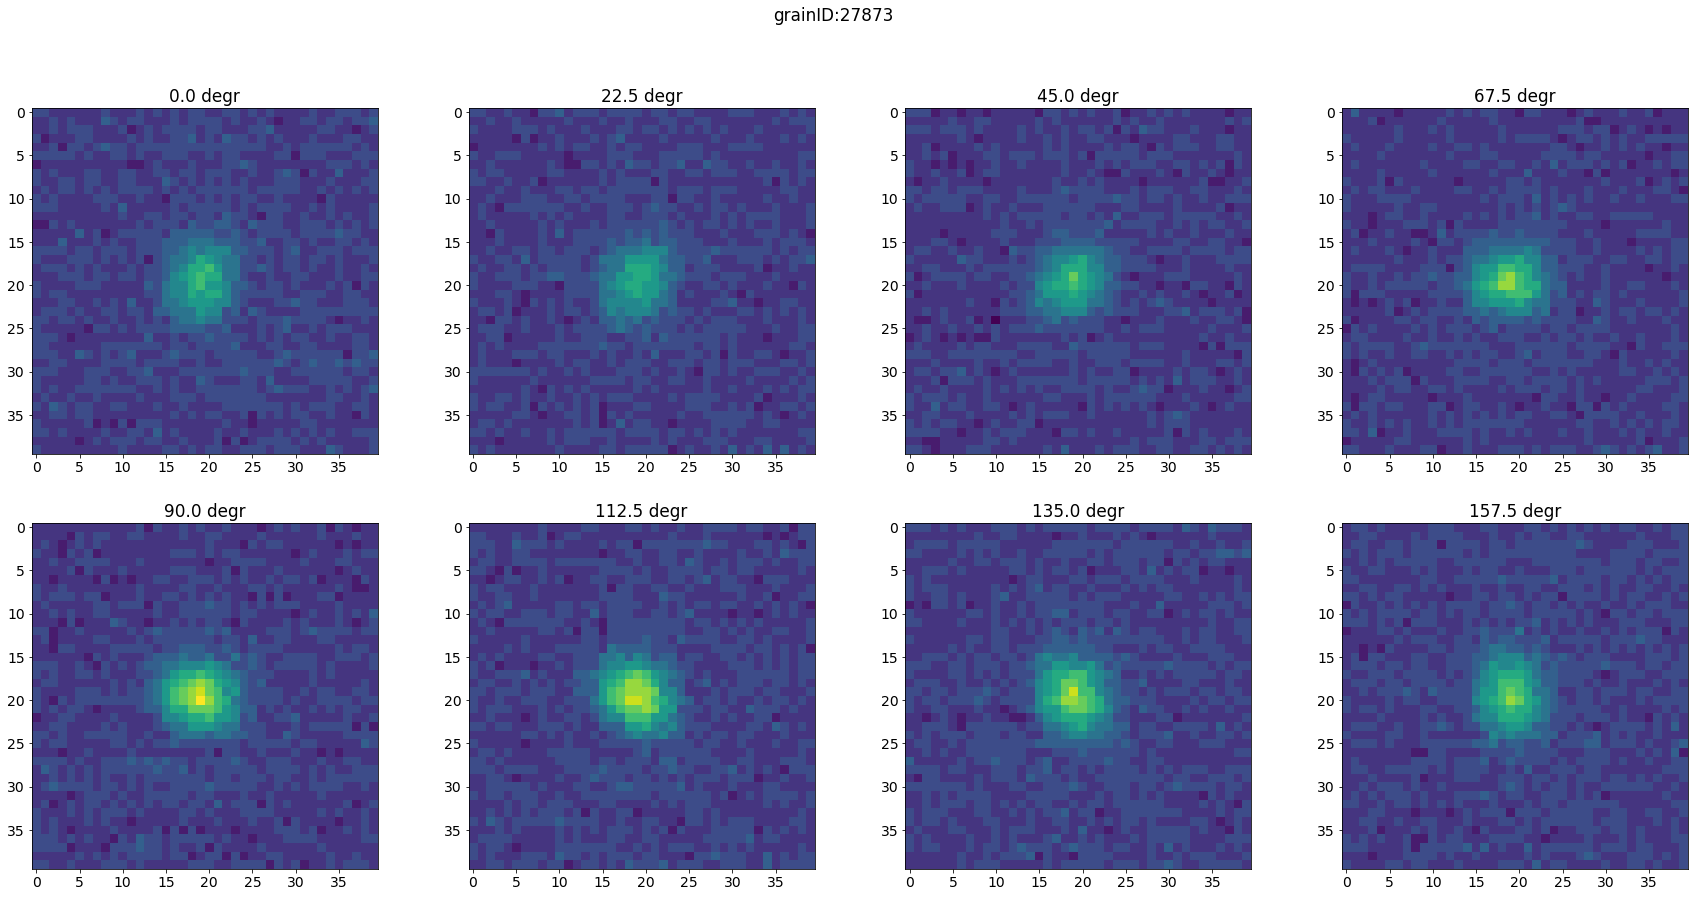

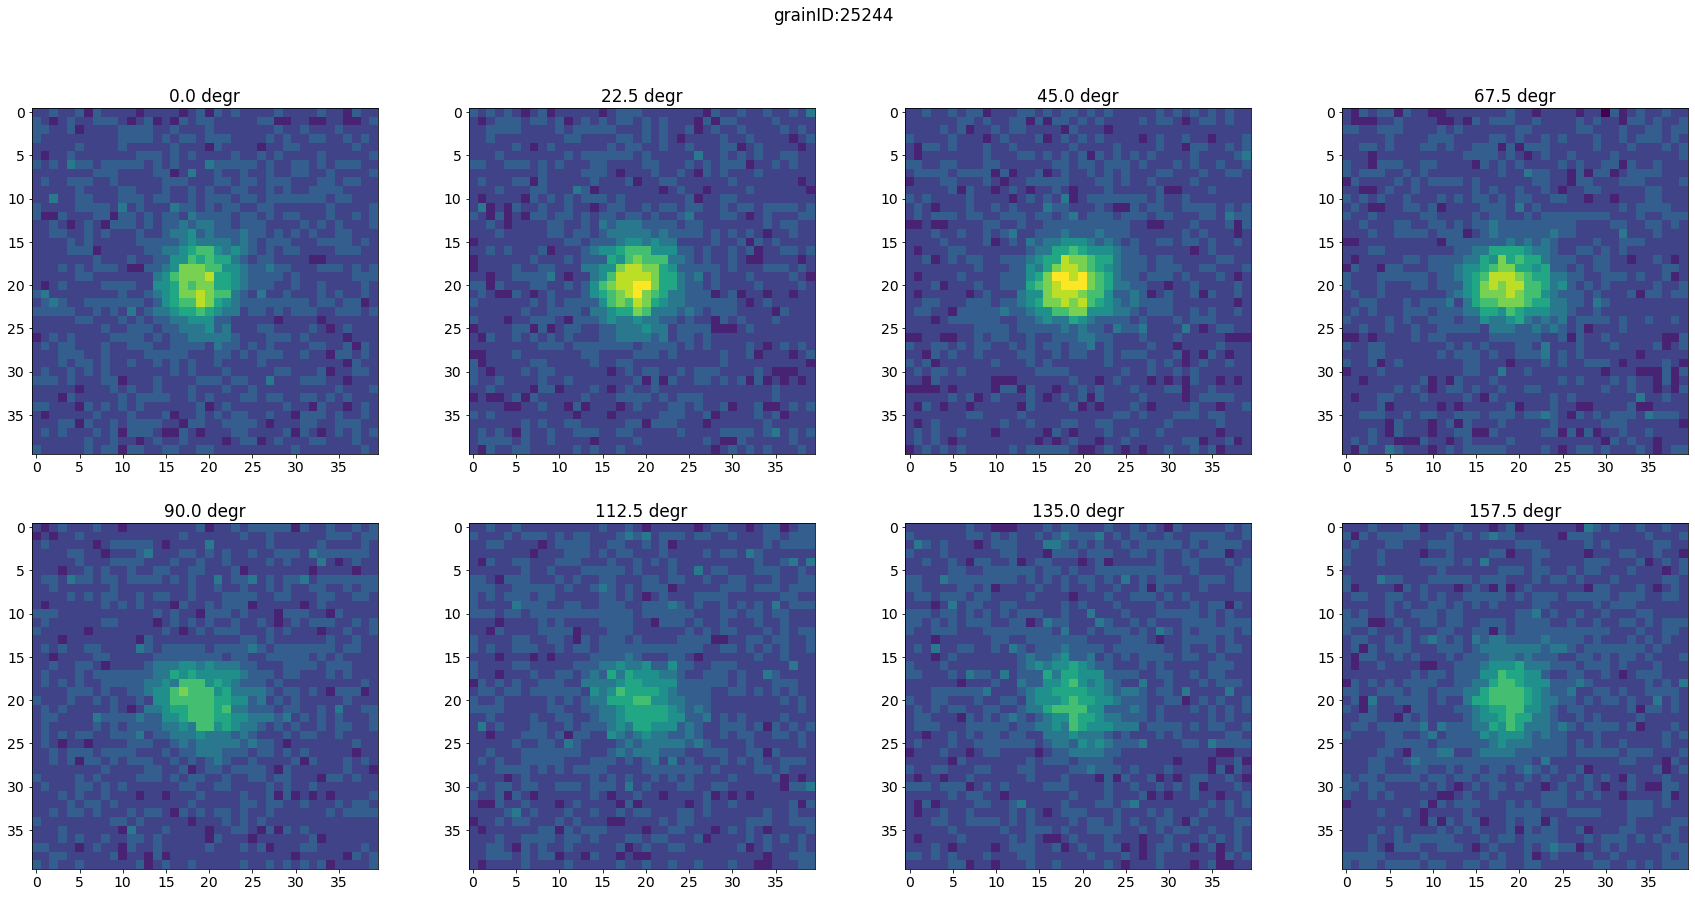

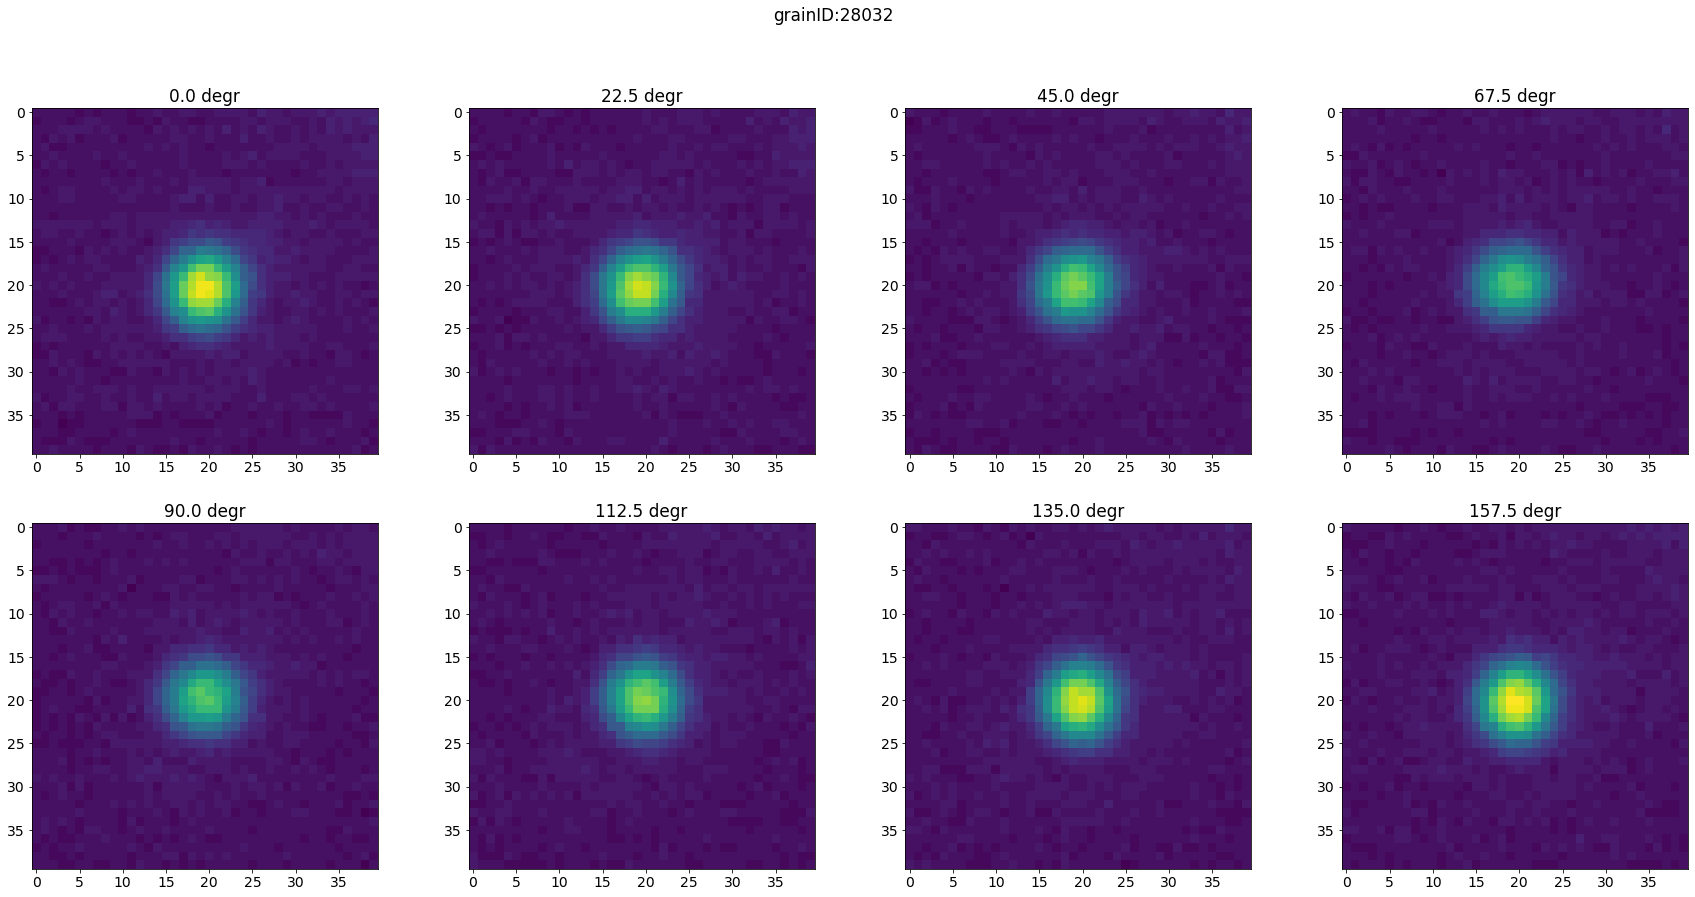

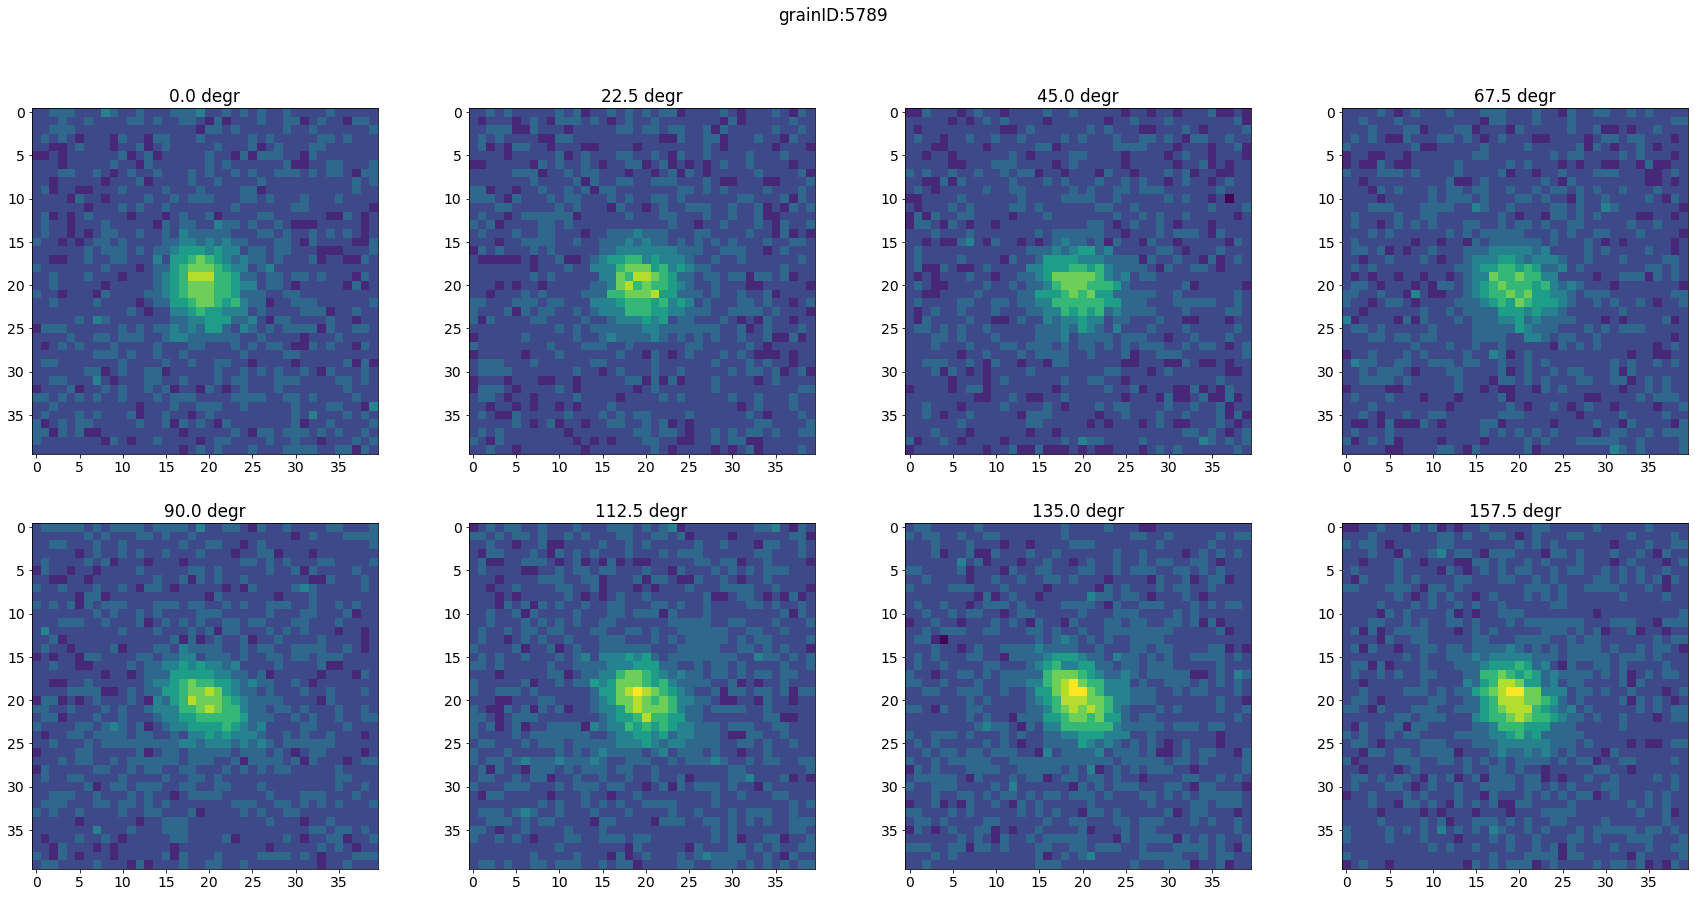

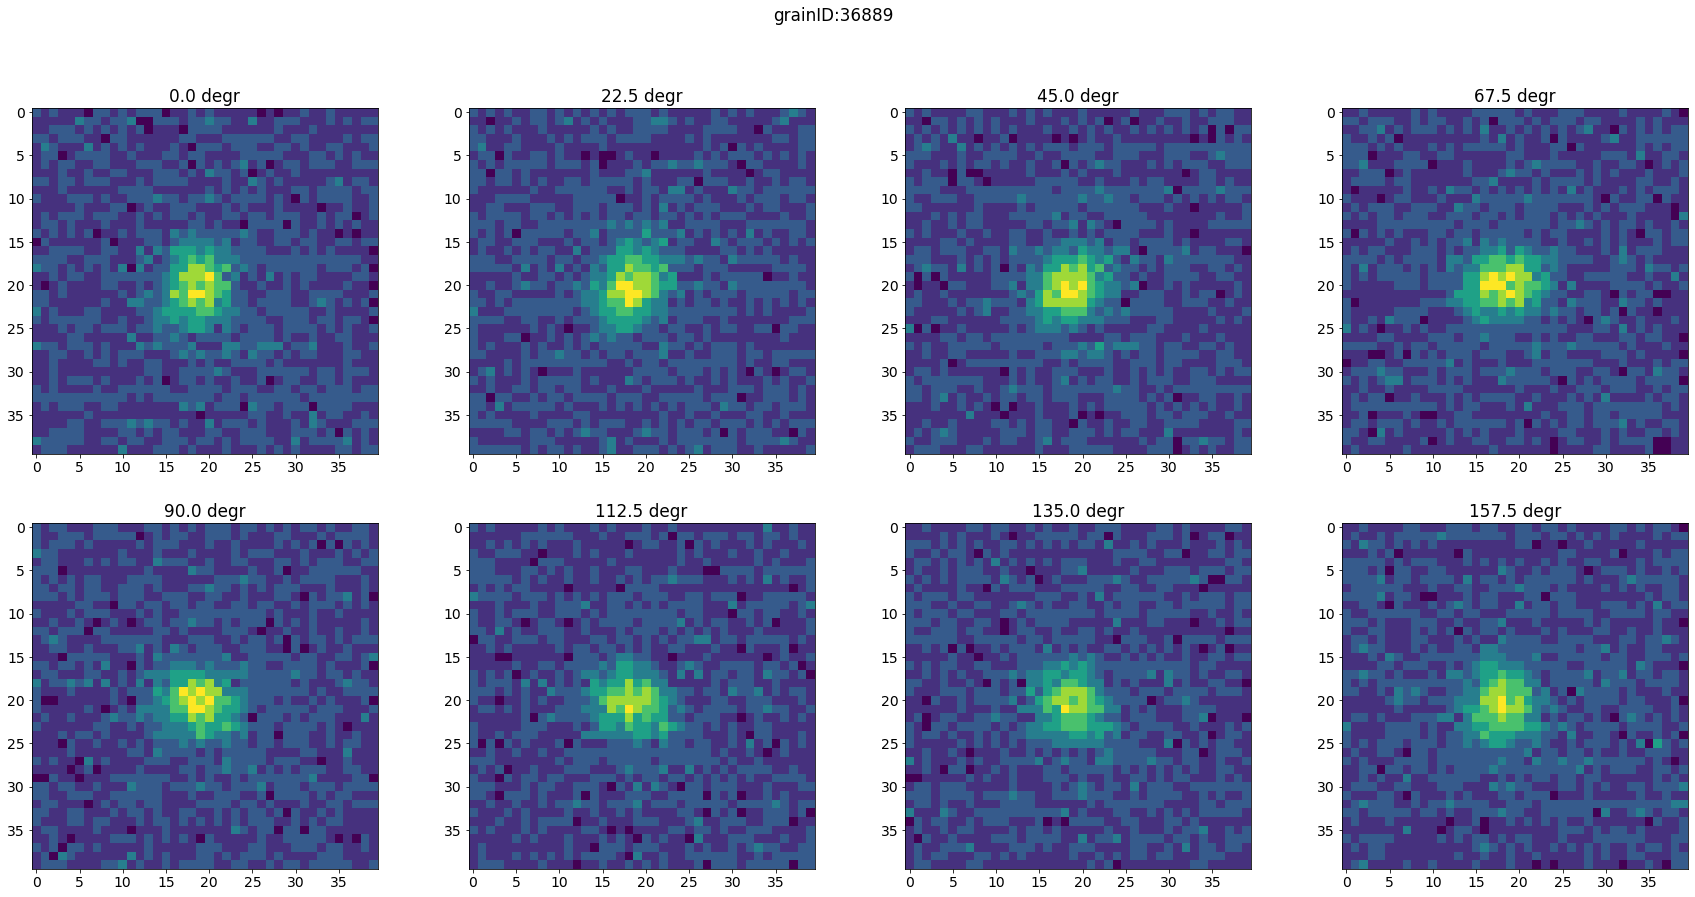

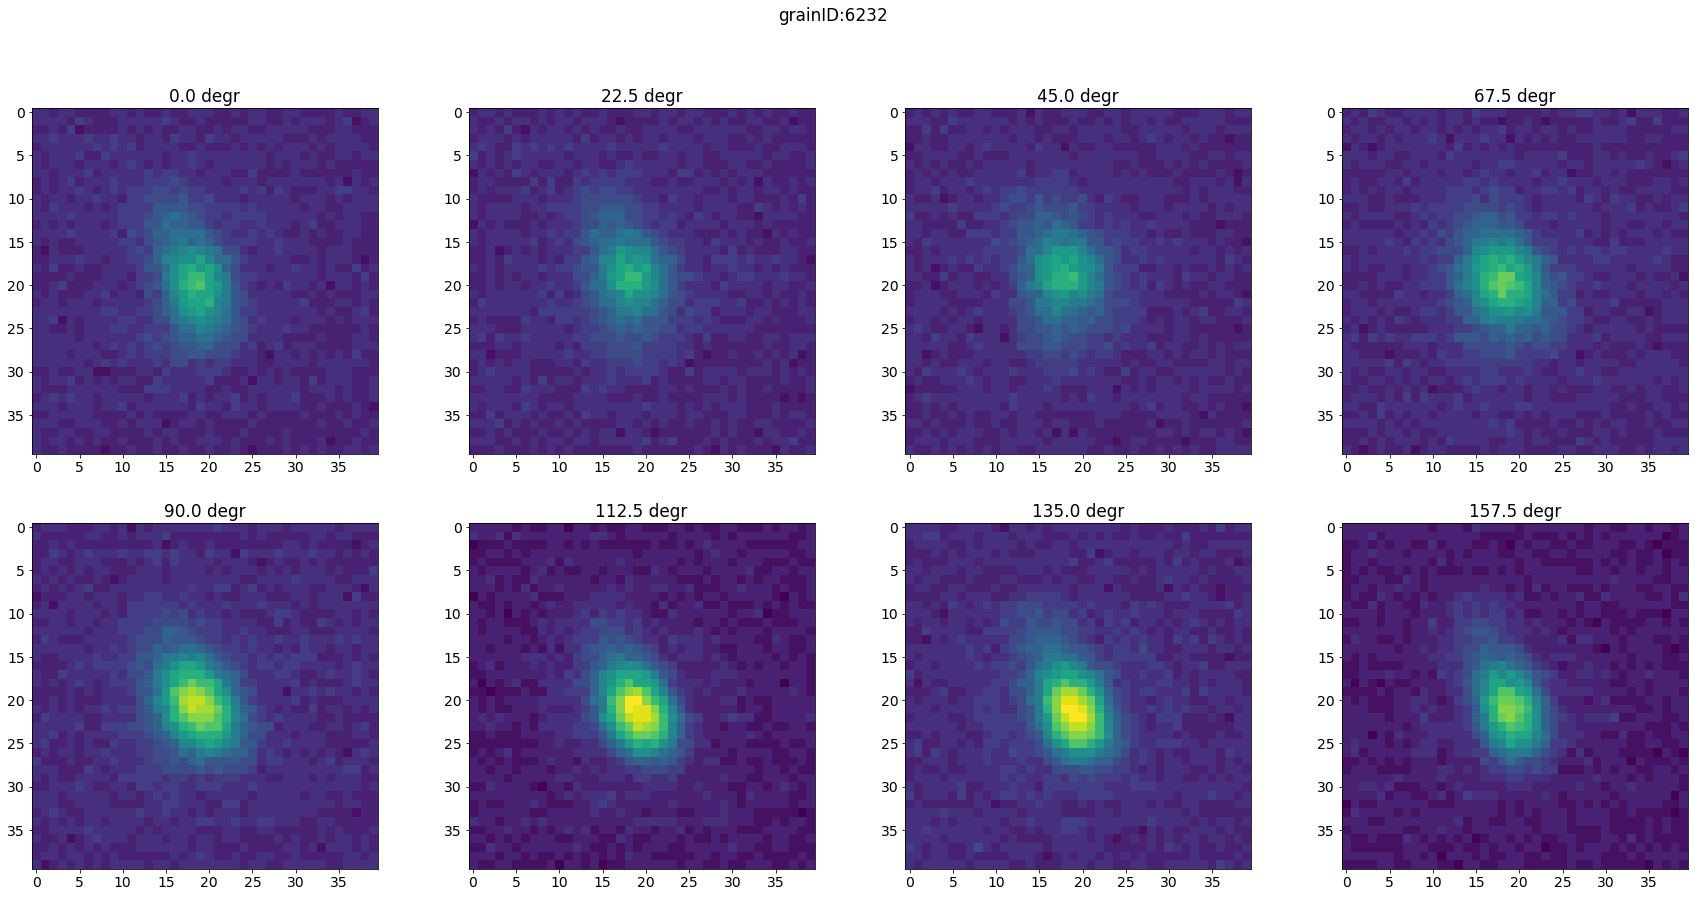

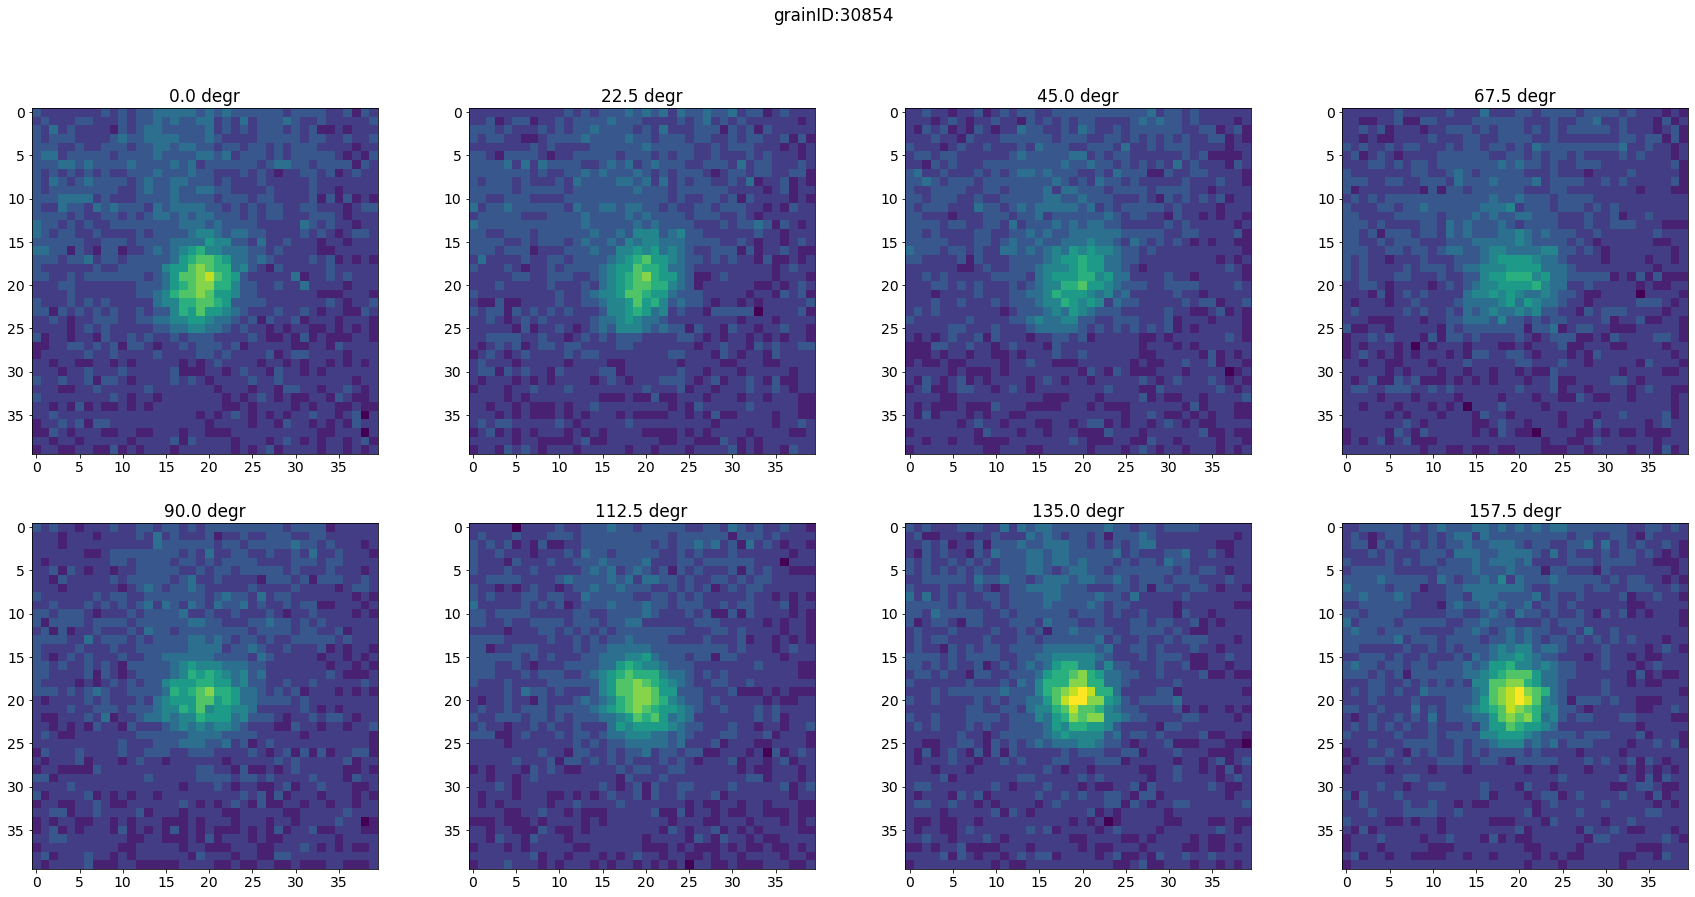

In [81]:
with h5py.File(dset+'ready-to-isolate/Carbon-100keV.h5','r') as df:
    for count in range(10):
        plt.rcParams.update({'font.size': 14})
        fig, axes = plt.subplots(2, 4, figsize=(30,14))
        axes = np.ravel(axes)

        n = np.random.randint(df['train/images'].shape[0])
        im_showed = []
        fig.suptitle('grainID:{}'.format(n))
        imgs = df['train/images'][n,...,:8]
        for i in range(8):
            im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i]))
            axes[i].set_title('{:.1f} degr'.format(i*180/8))
            
        vmin = np.min(df['train/images'][n])
        vmax = np.max(df['train/images'][n])
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for i in range(8):
            im_showed[i].set_norm(norm)
        plt.show()

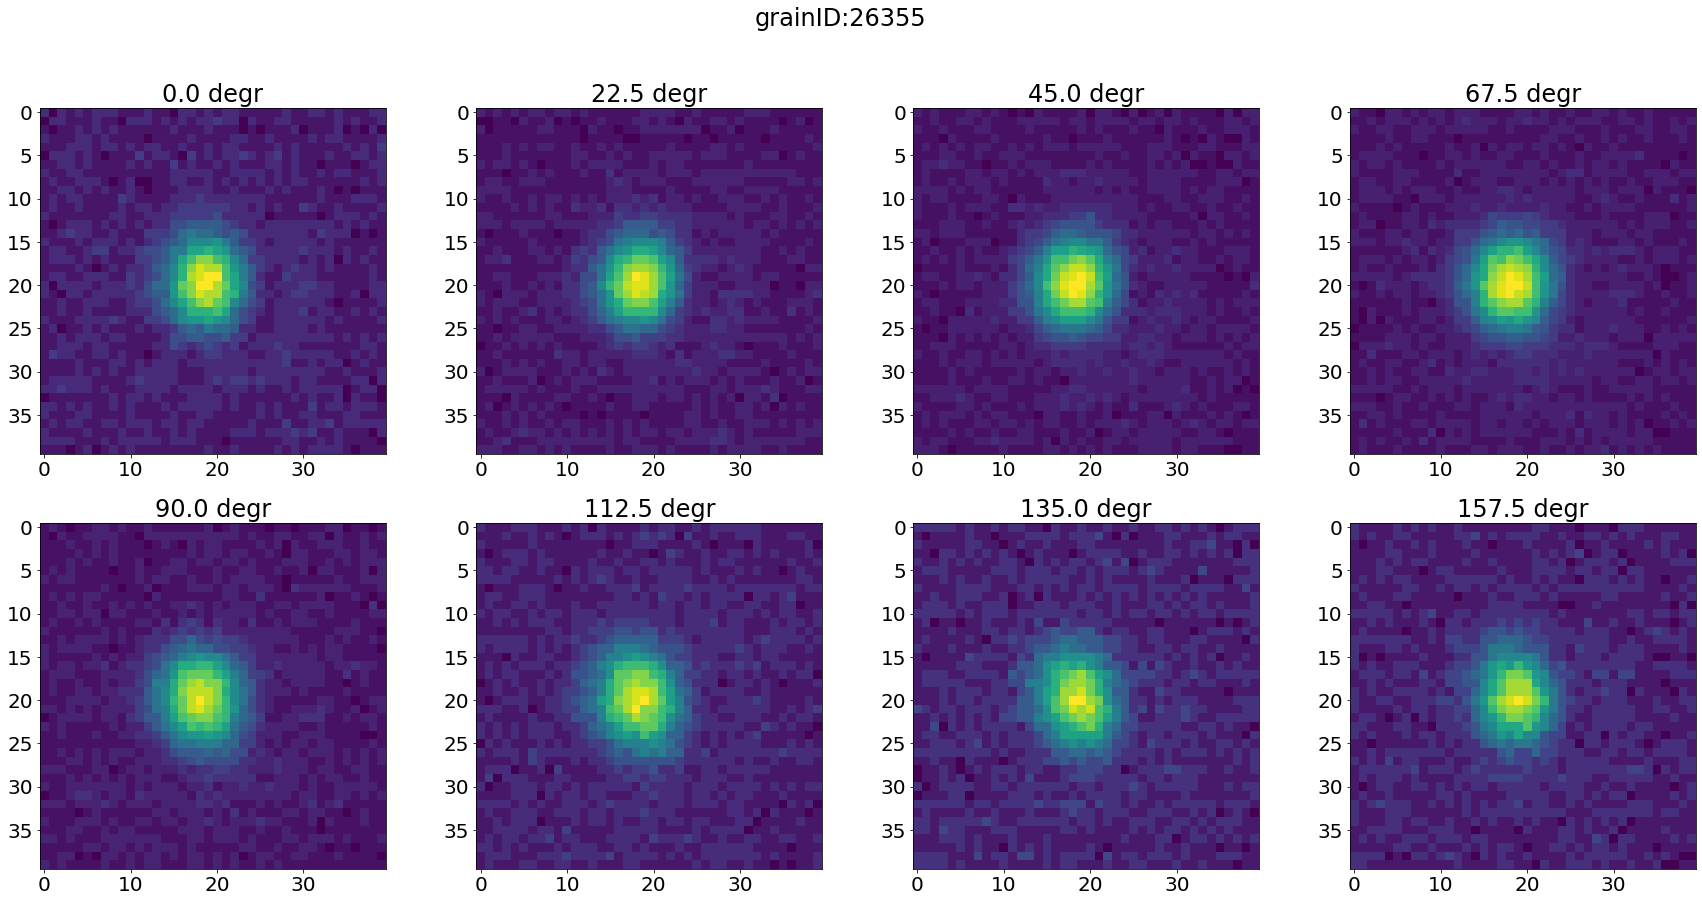

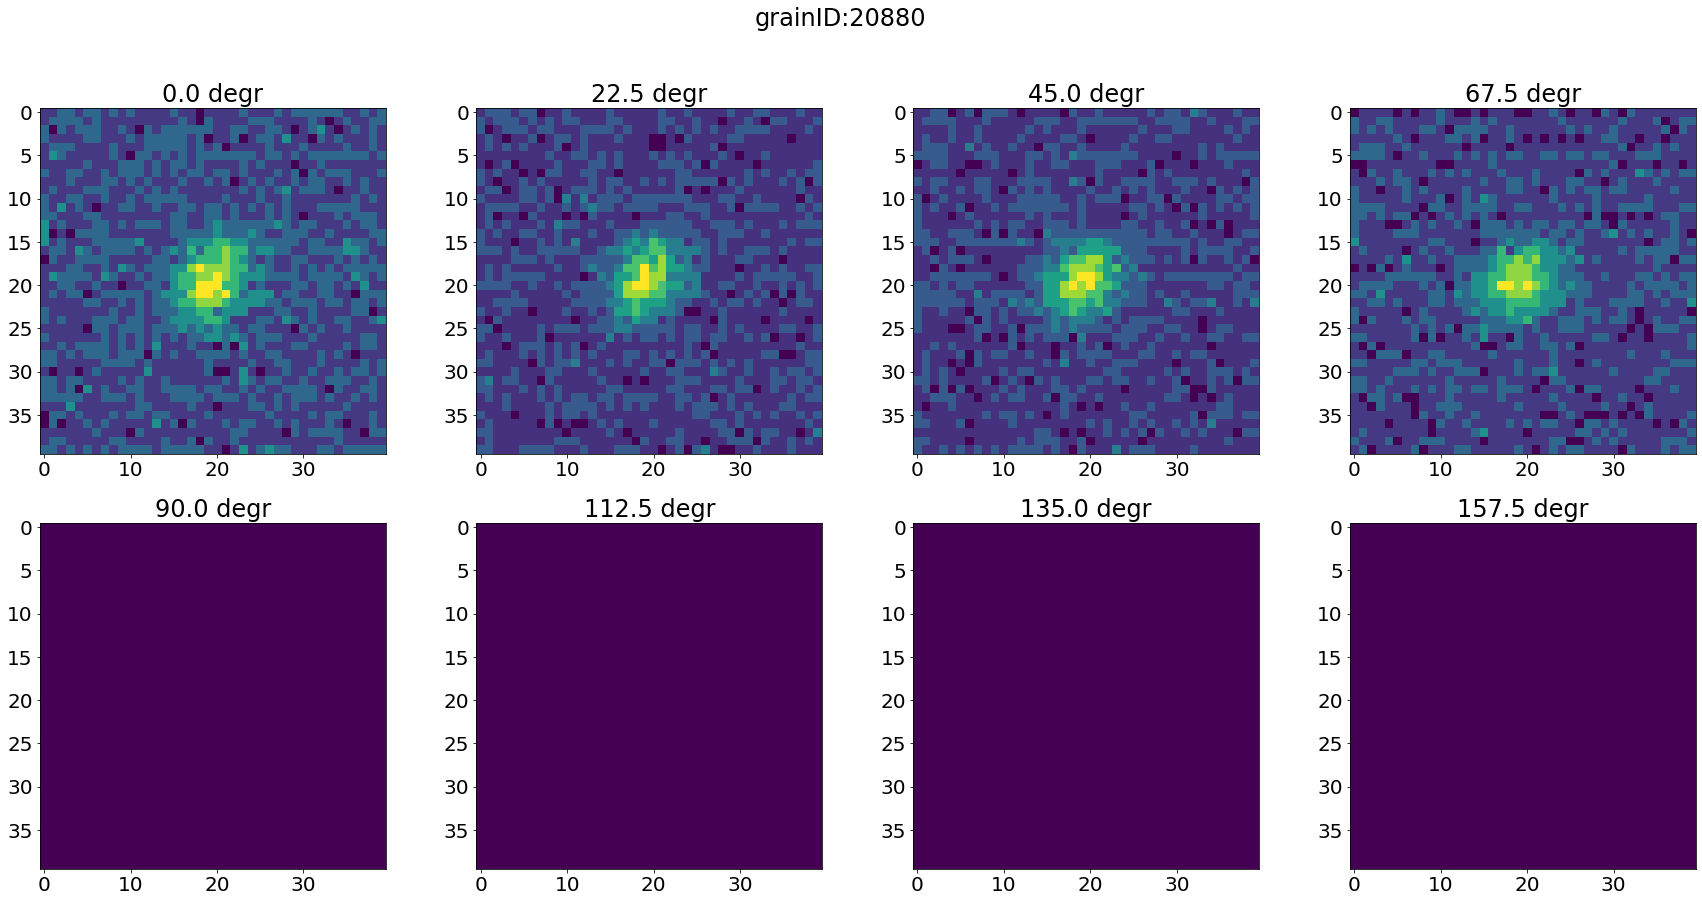

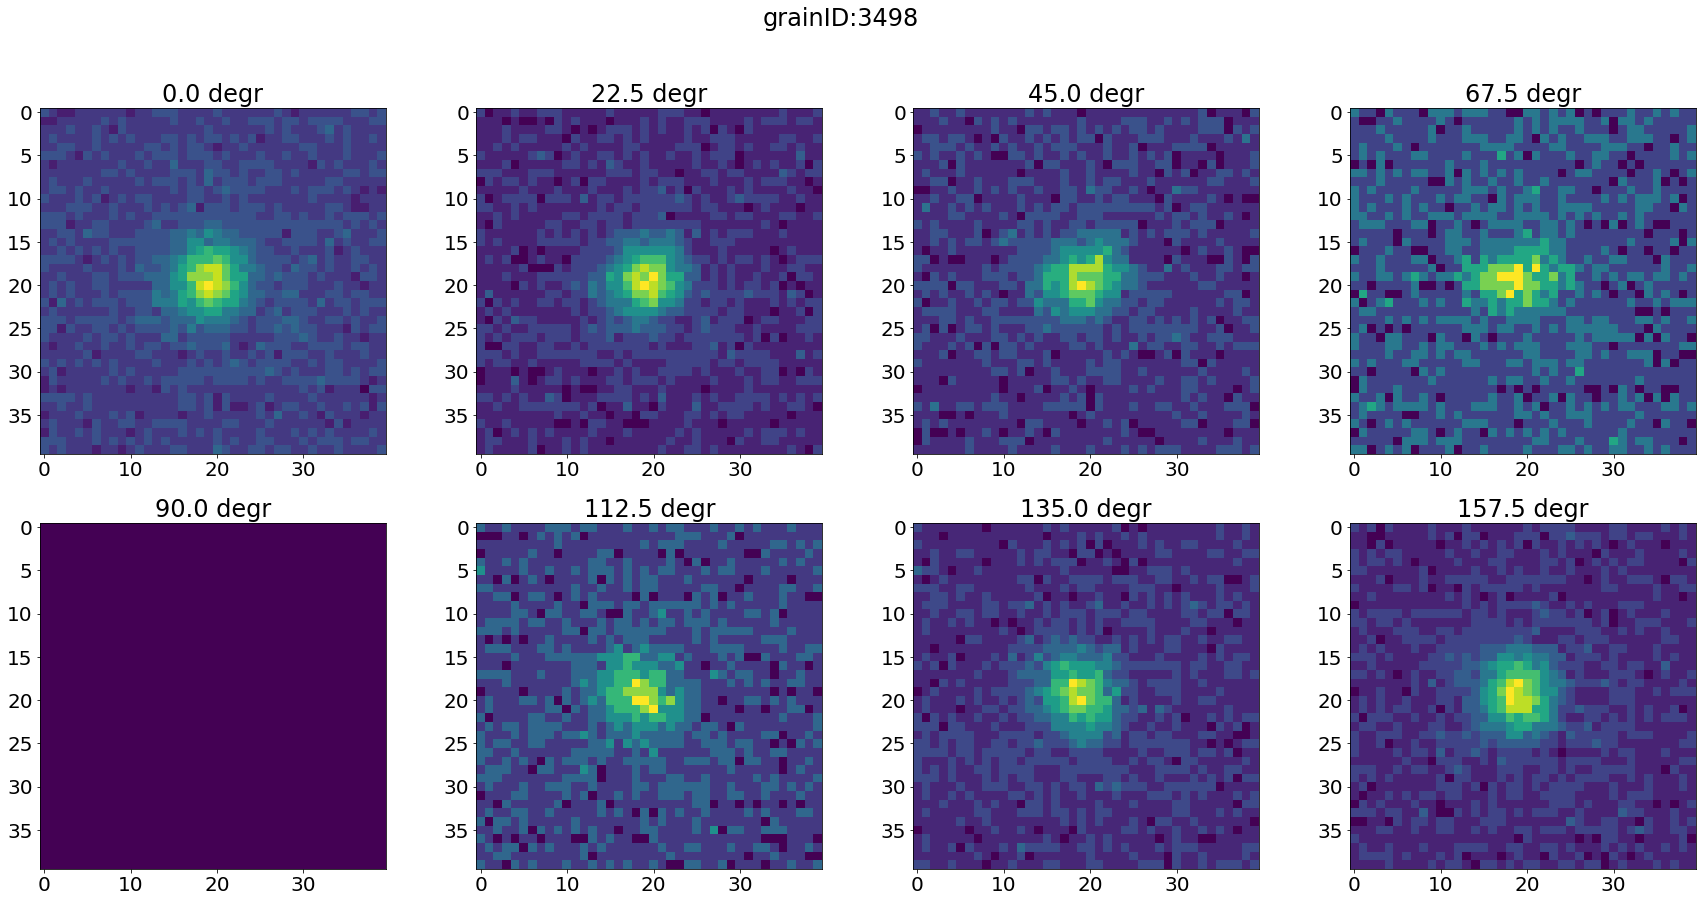

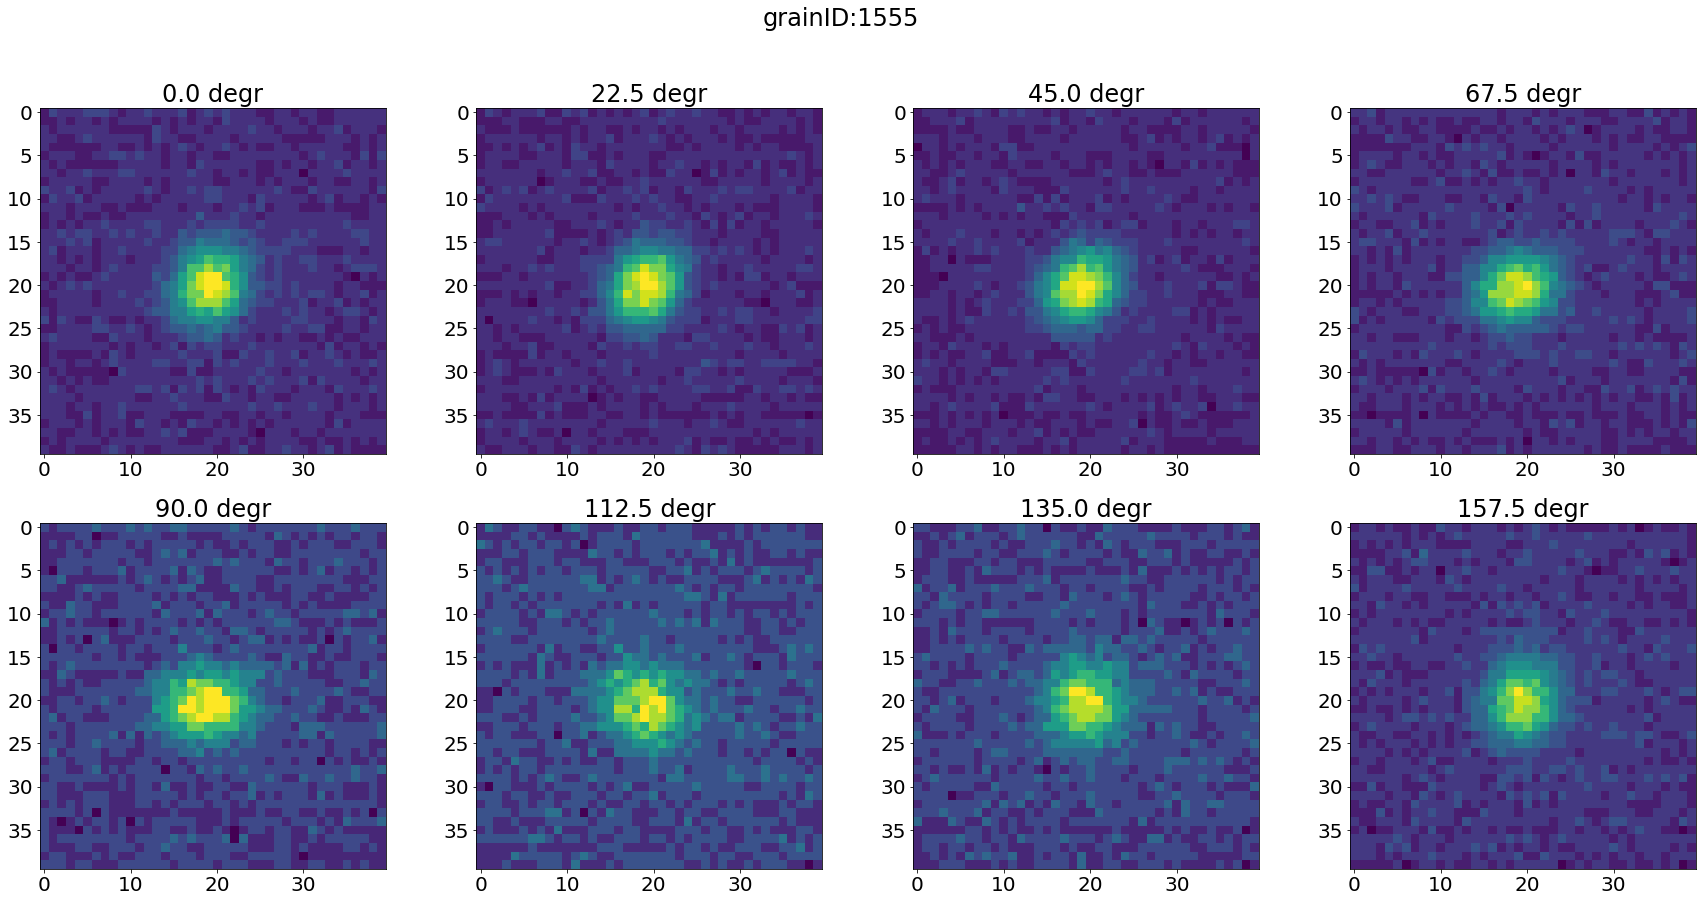

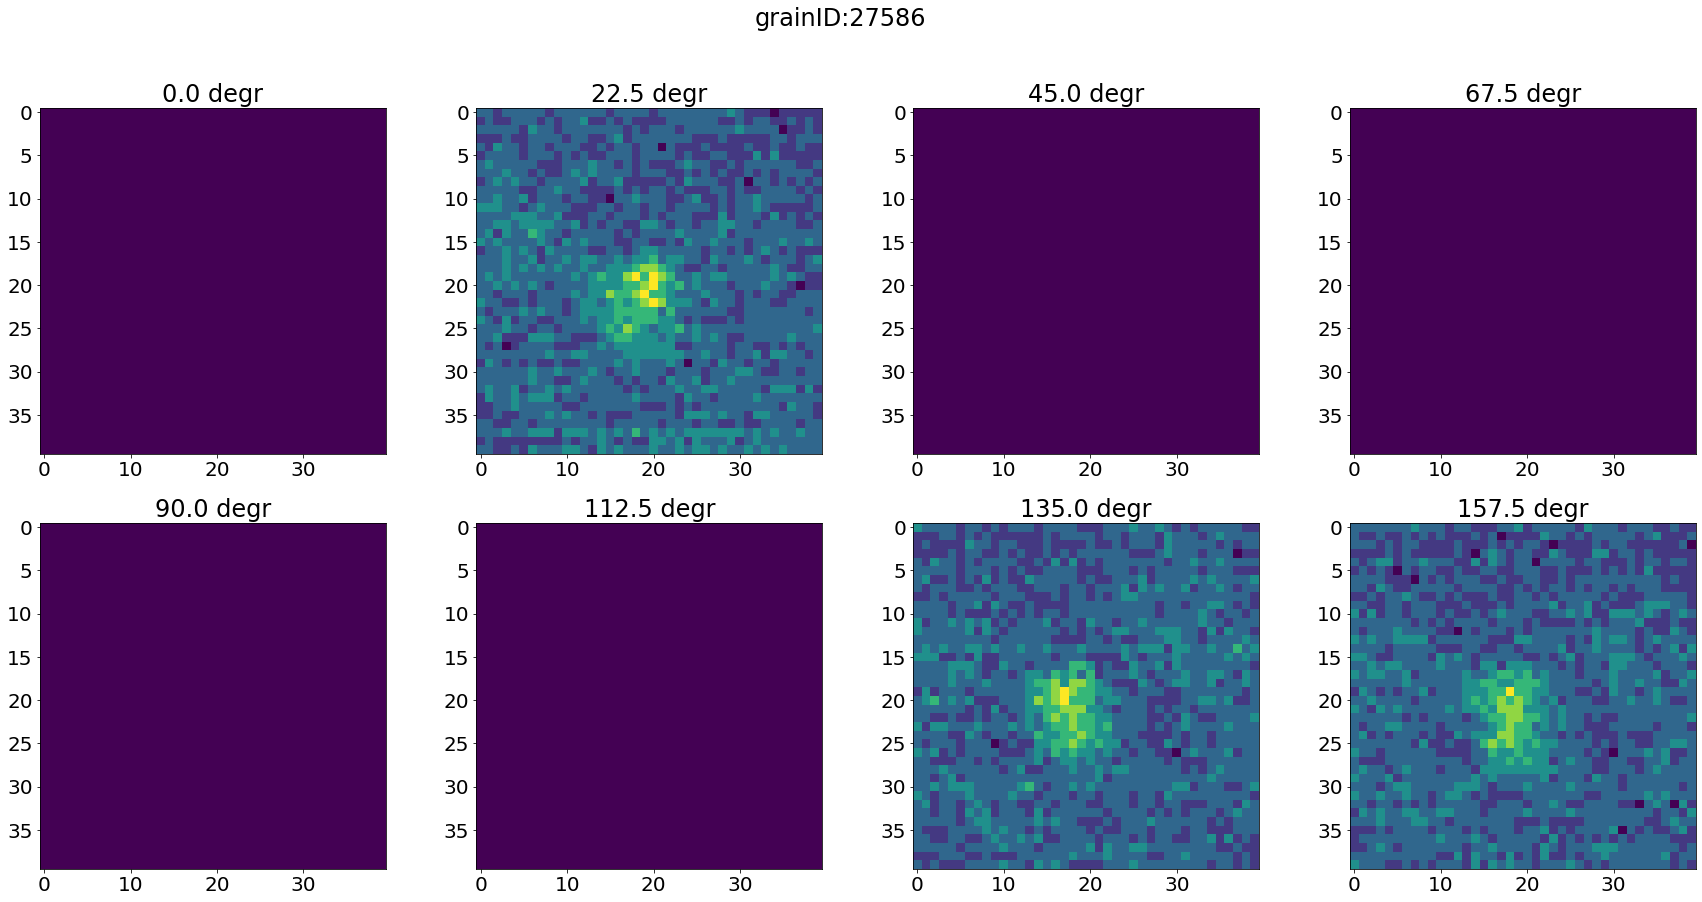

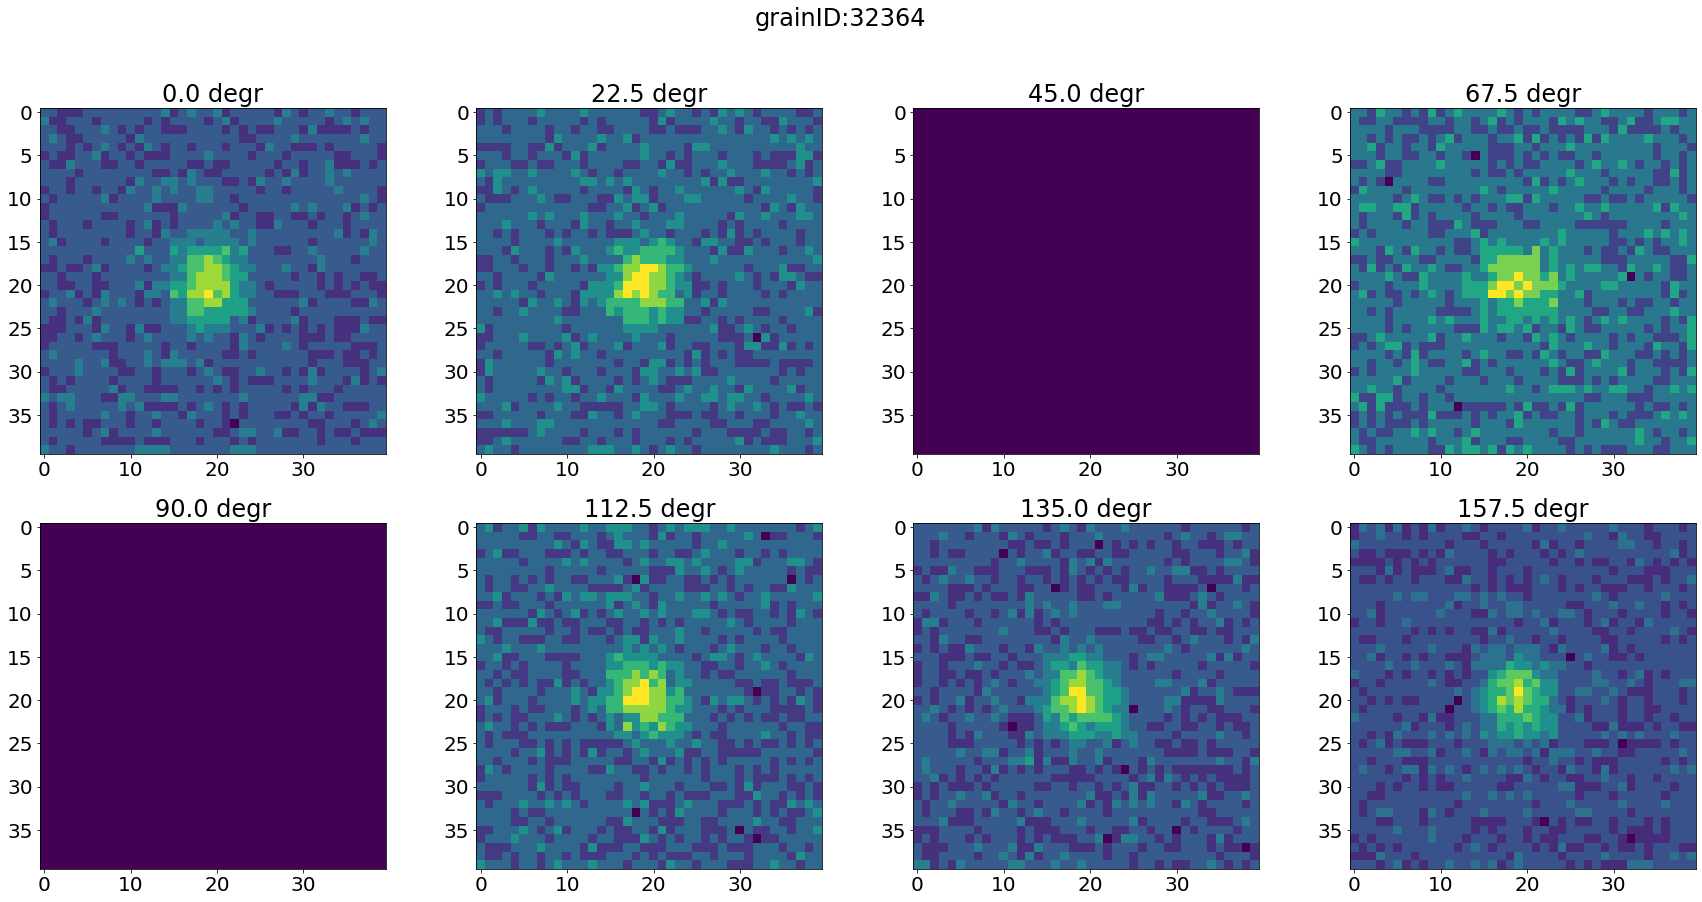

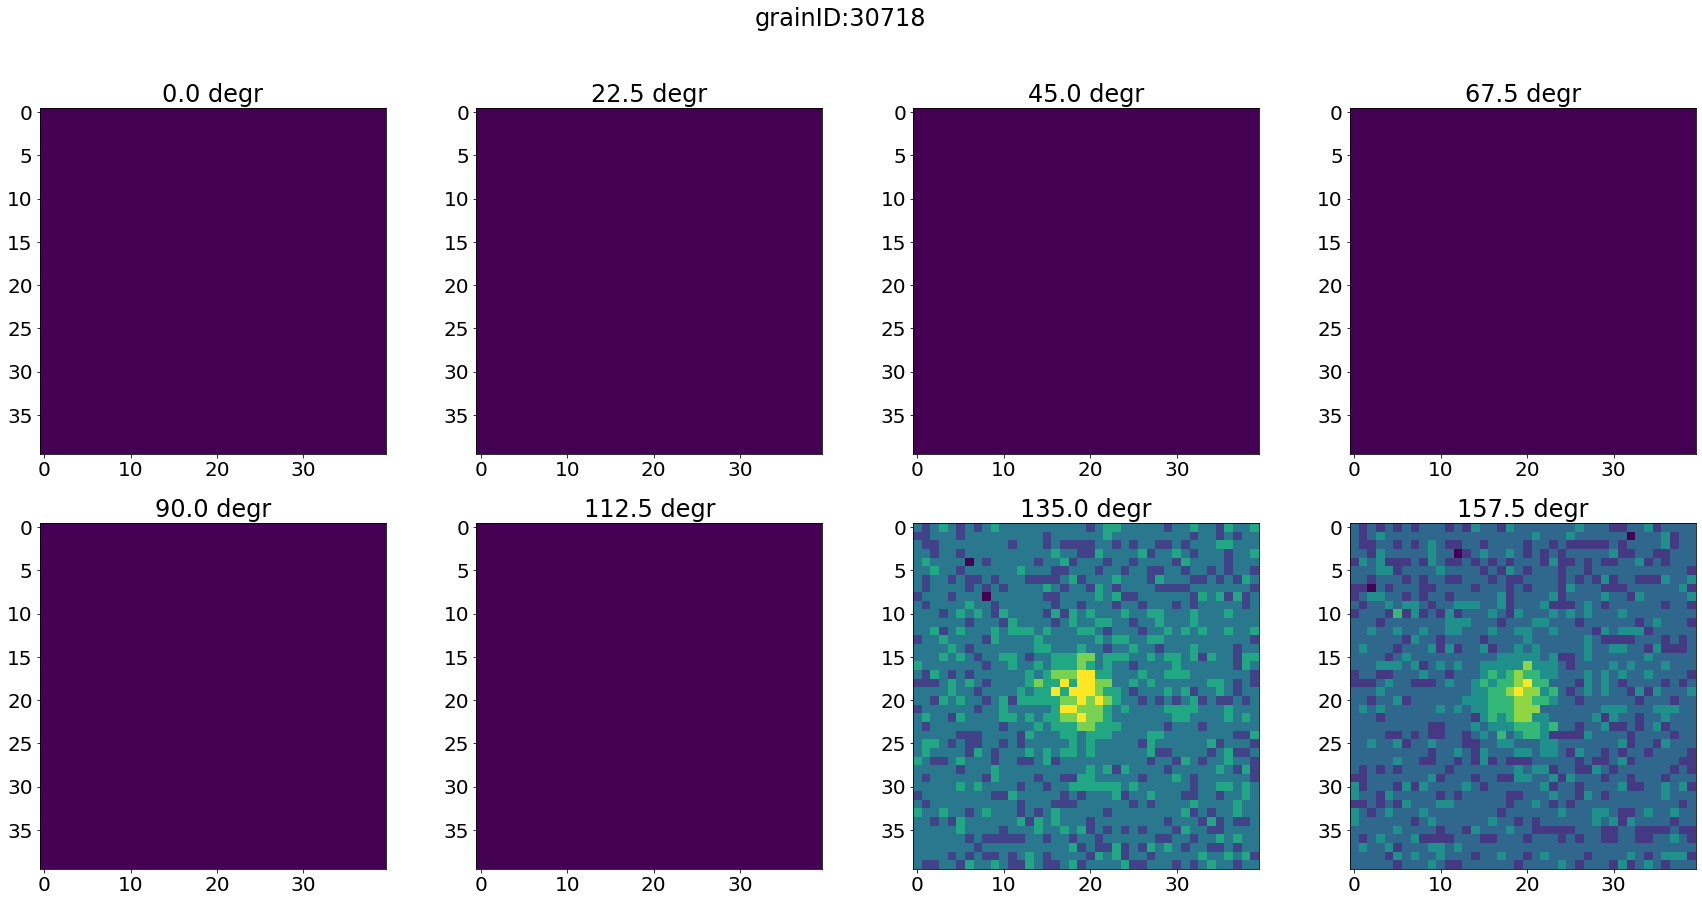

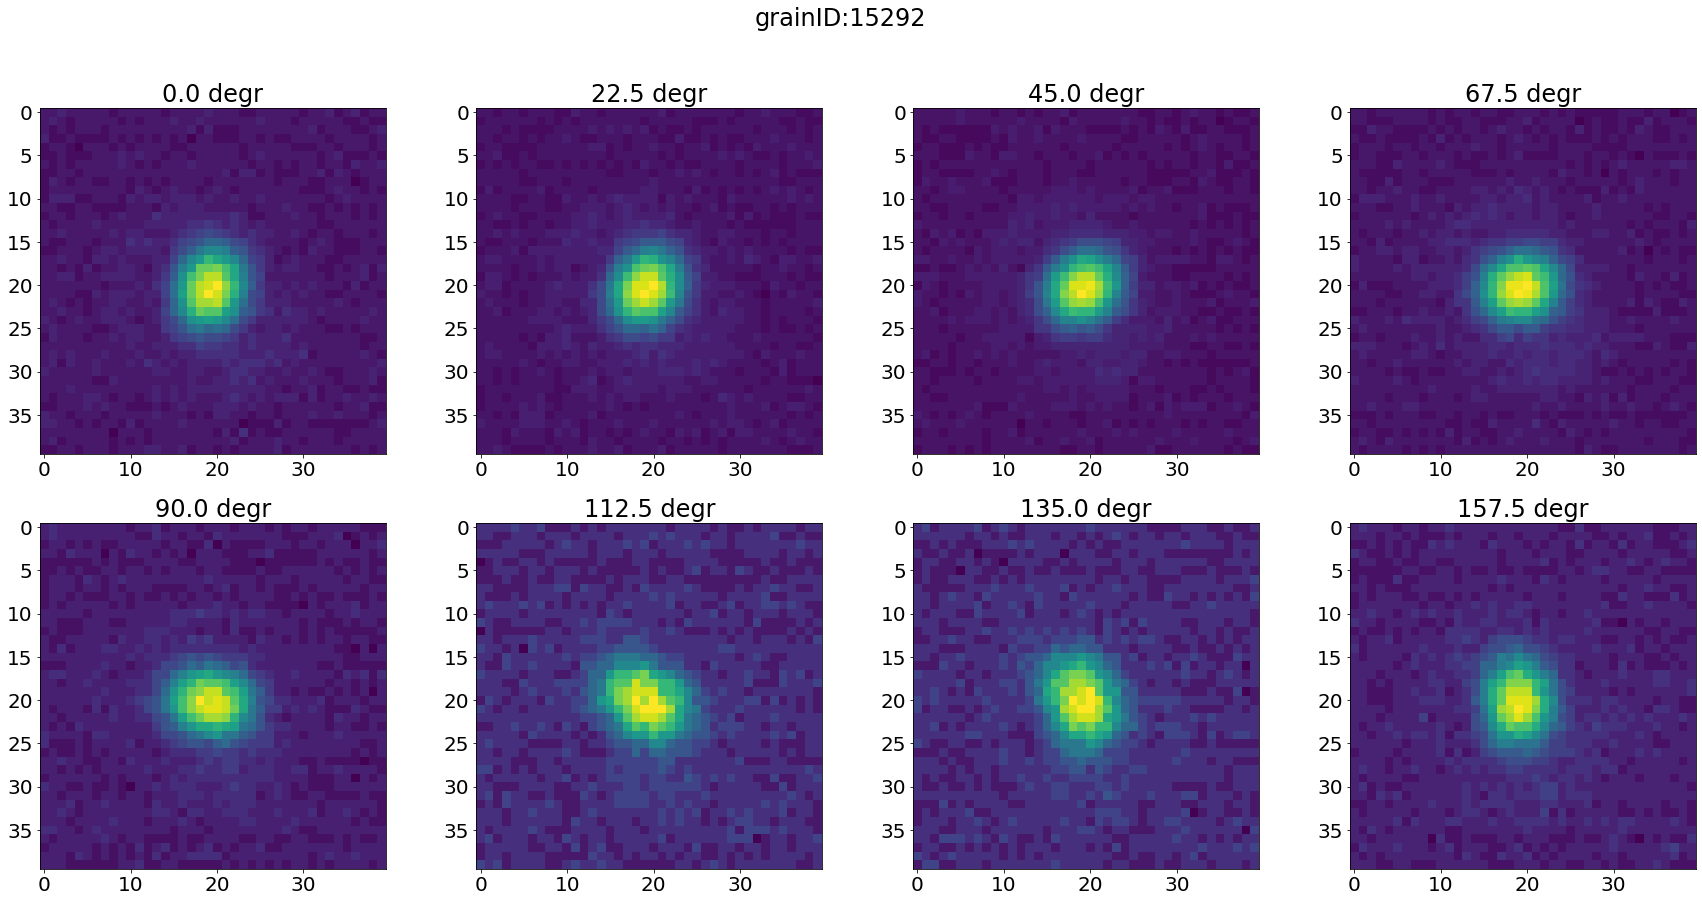

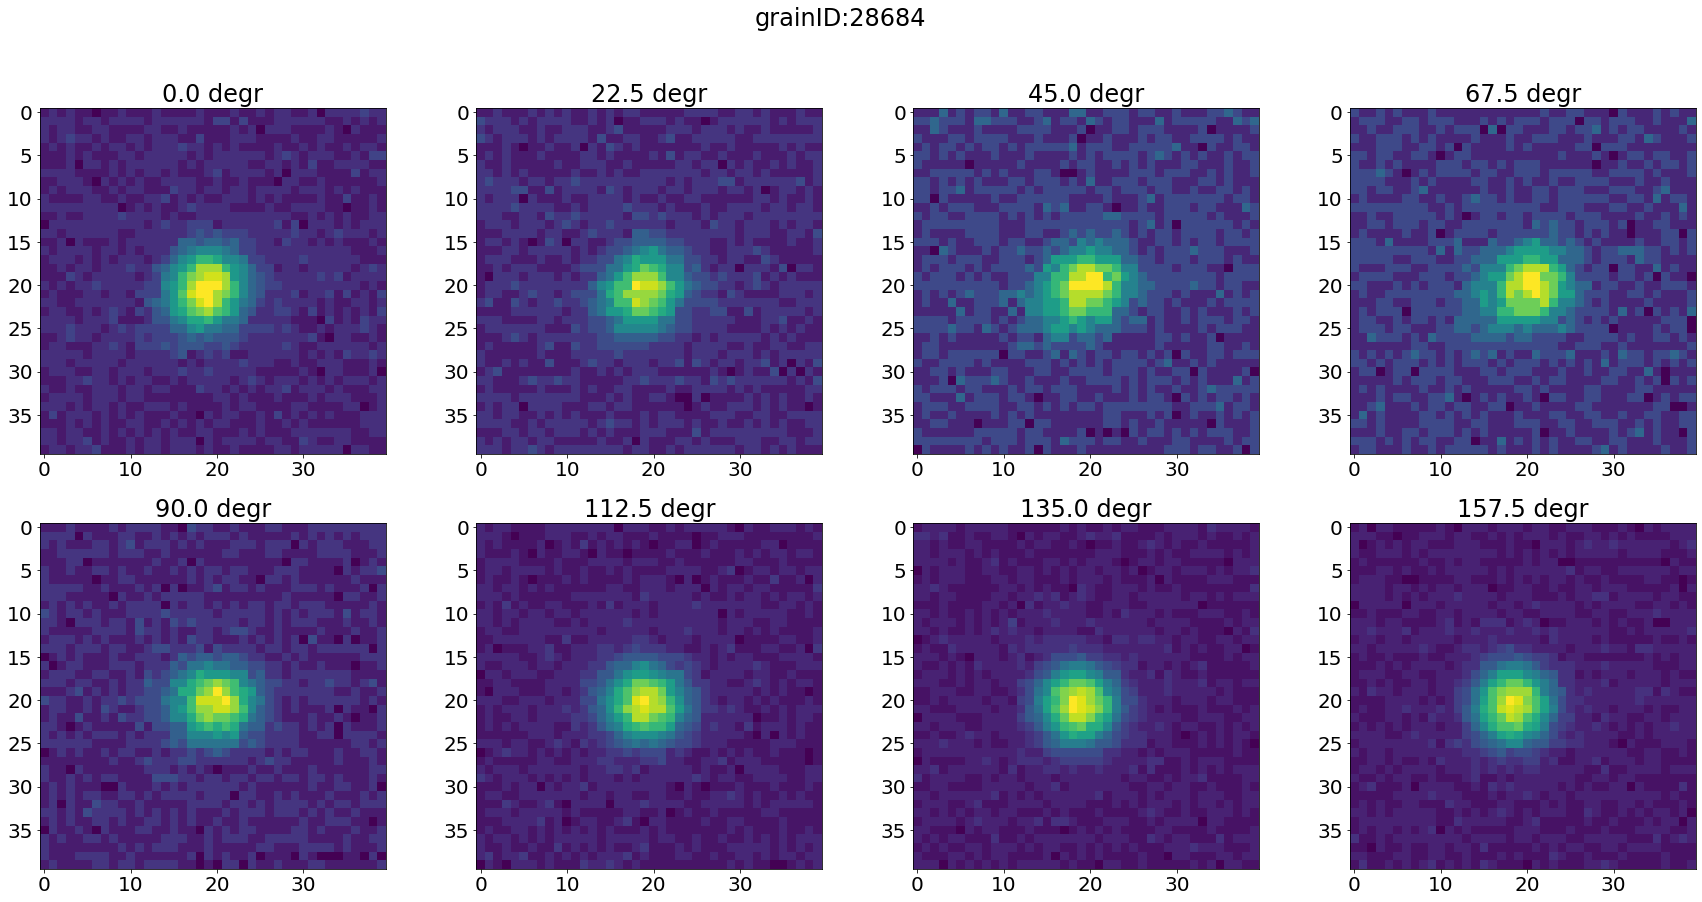

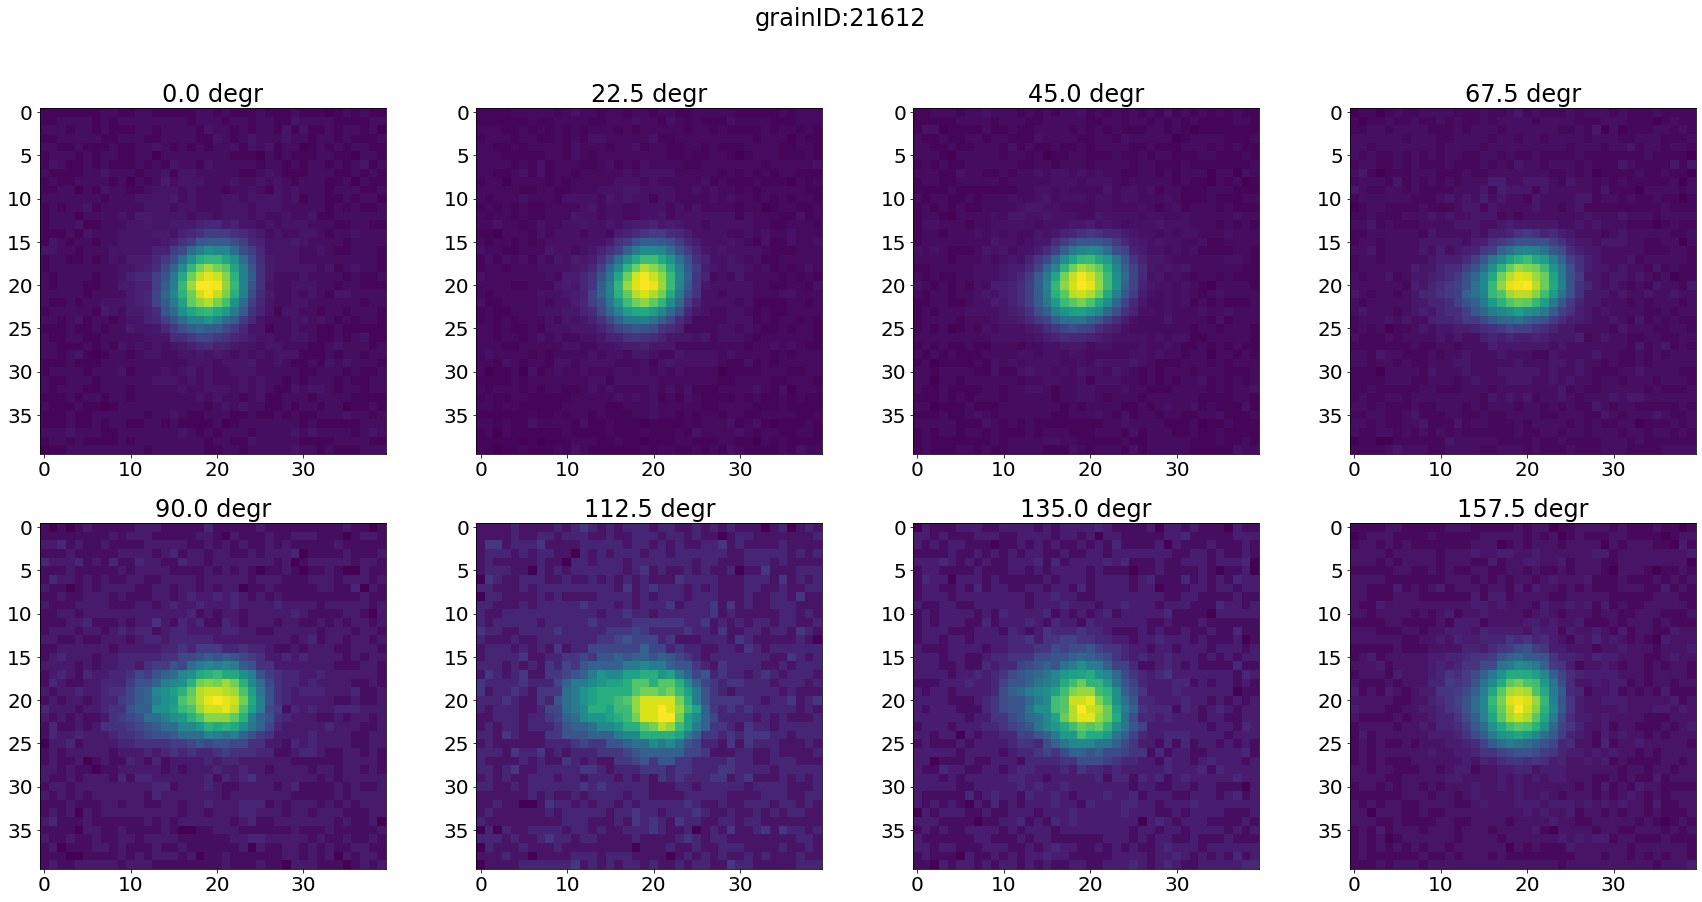

In [65]:
with h5py.File(dset+'ready-to-isolate/Carbon-100keV.h5','r') as df:
    for count in range(10):
        plt.rcParams.update({'font.size': 20})
        fig, axes = plt.subplots(2, 4, figsize=(30,14))
        axes = np.ravel(axes)

        n = np.random.randint(df['train/images'].shape[0])
        fig.suptitle('grainID:{}'.format(n))
        imgs = df['train/images'][n,...,:8]
        for i in range(8):
            axes[i].imshow(df['train/images'][n,:,:,i])
            axes[i].set_title('{:.1f} degr'.format(i*180/8))
        plt.show()

In [29]:
n = 21971

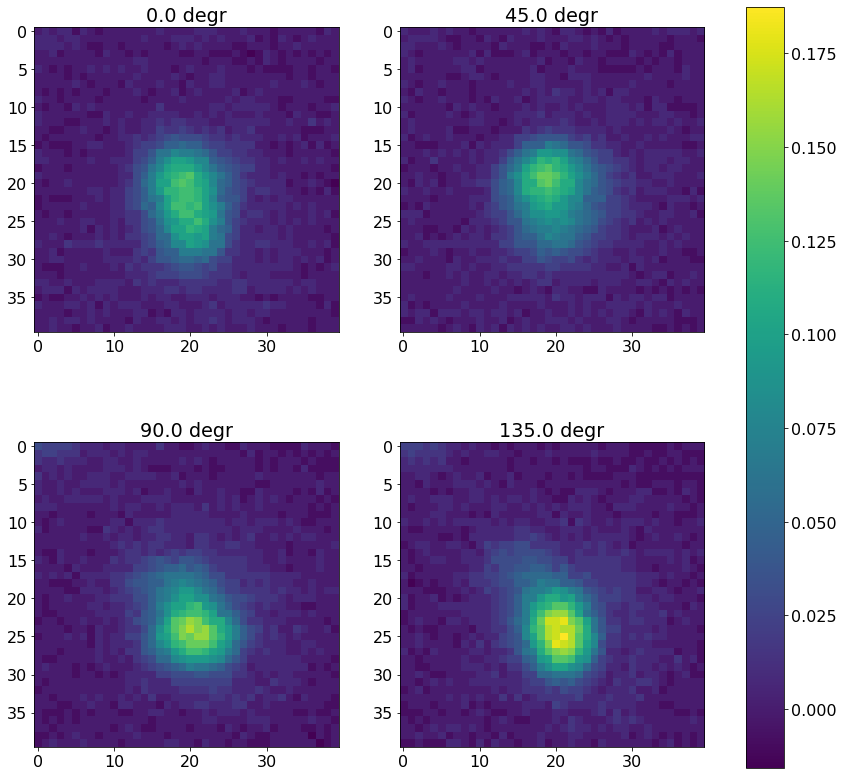

In [32]:
from matplotlib import colors

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'
with h5py.File(dset+'ready-to-isolate/Carbon-100keV.h5','r') as df:
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(2, 2, figsize=(15,14))
    axes = np.ravel(axes)
    #fig.suptitle('')
    imgs = df['train/images'][n,...,:8]
    im_showed = []
    for i in range(4):
        im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i*2]))
        axes[i].set_title('{:.1f} degr'.format(i*2*180/8))
    # normalizing colours and colorbar
    vmin = np.min(df['train/images'][n])
    vmax = np.max(df['train/images'][n])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i in range(4):
        im_showed[i].set_norm(norm)
    fig.colorbar(im_showed[0], ax=axes, location='right')
    plt.savefig(save_dir+'imgs_c100.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

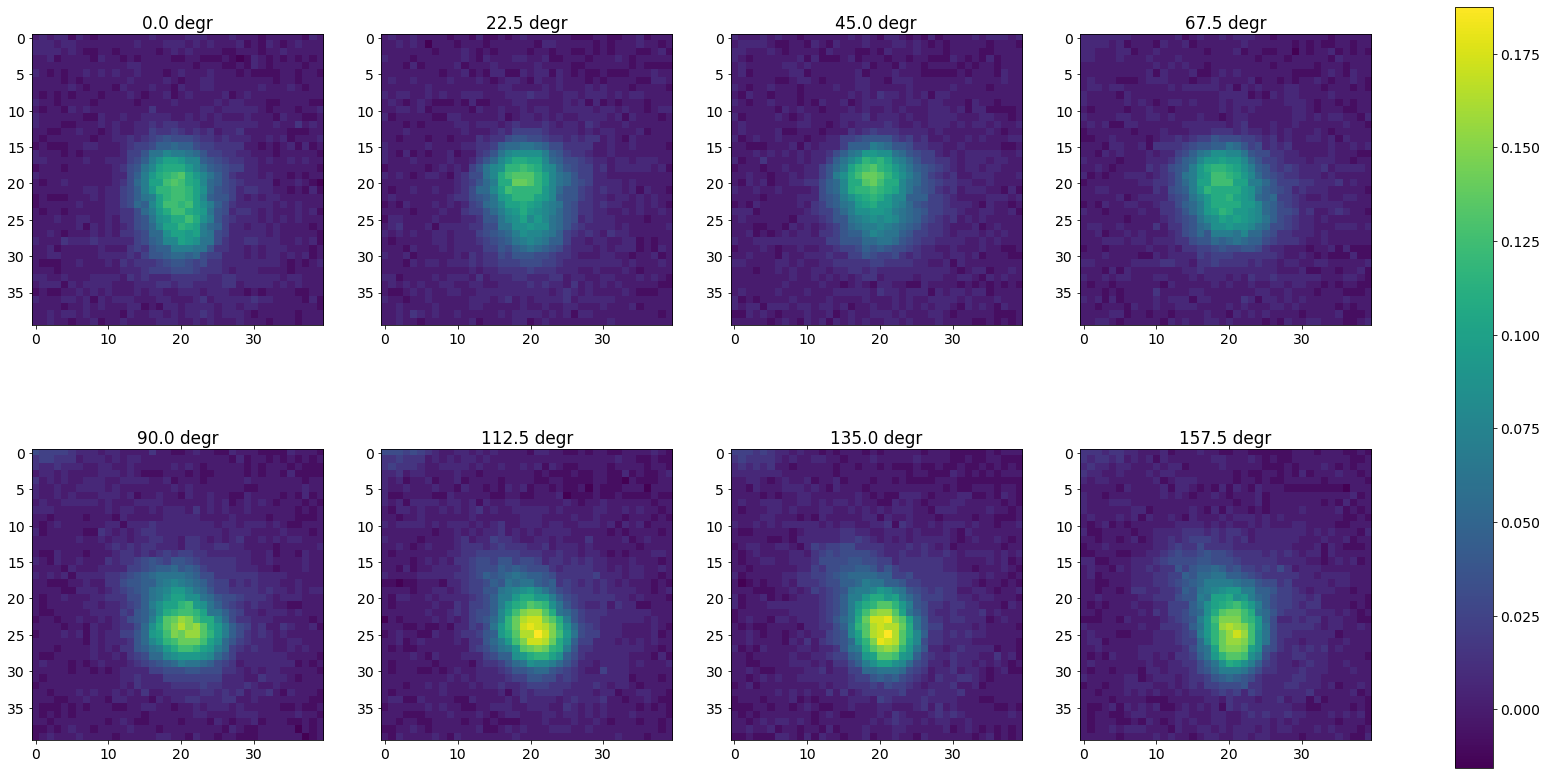

In [92]:
from matplotlib import colors

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'
with h5py.File(dset+'ready-to-isolate/Carbon-100keV.h5','r') as df:
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(2, 4, figsize=(30,14))
    axes = np.ravel(axes)
    #fig.suptitle('')
    imgs = df['train/images'][n,...,:8]
    im_showed = []
    for i in range(8):
        im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i]))
        axes[i].set_title('{:.1f} degr'.format(i*180/8))
    # normalizing colours and colorbar
    vmin = np.min(df['train/images'][n])
    vmax = np.max(df['train/images'][n])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i in range(8):
        im_showed[i].set_norm(norm)
    fig.colorbar(im_showed[0], ax=axes, location='right')
    plt.savefig(save_dir+'imgs_c100.png', facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

In [33]:
n = 6232

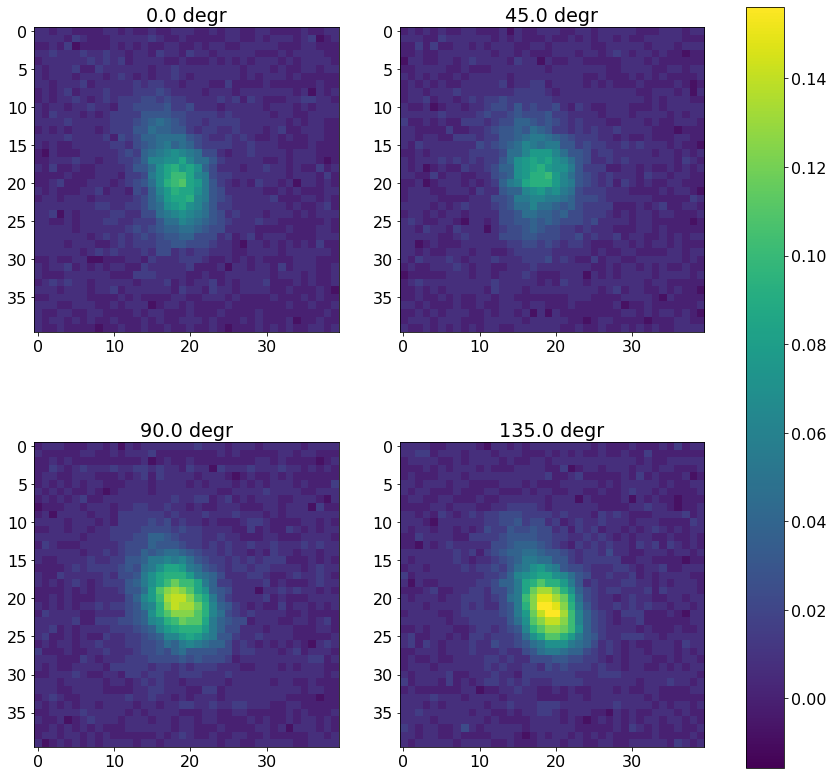

In [34]:
from matplotlib import colors
with h5py.File(dset+'ready-to-isolate/Carbon-100keV.h5','r') as df:
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(2, 2, figsize=(15,14))
    axes = np.ravel(axes)
    #fig.suptitle('')
    imgs = df['train/images'][n,...,:8]
    im_showed = []
    for i in range(4):
        im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i*2]))
        axes[i].set_title('{:.1f} degr'.format(i*2*180/8))
    # normalizing colours and colorbar
    vmin = np.min(df['train/images'][n])
    vmax = np.max(df['train/images'][n])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i in range(4):
        im_showed[i].set_norm(norm)
    fig.colorbar(im_showed[0], ax=axes, location='right')
    plt.show()

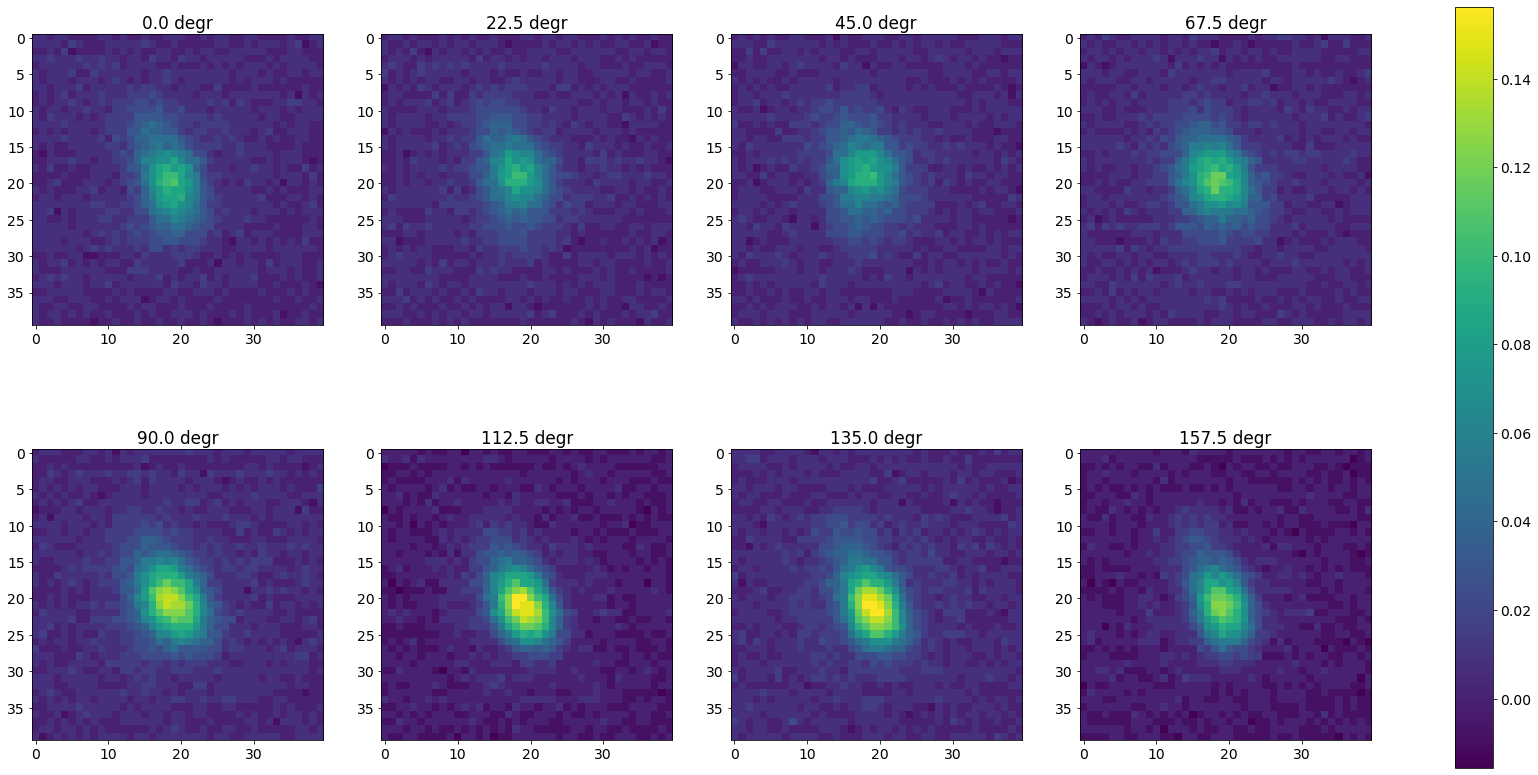

In [83]:
from matplotlib import colors
with h5py.File(dset+'ready-to-isolate/Carbon-100keV.h5','r') as df:
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(2, 4, figsize=(30,14))
    axes = np.ravel(axes)
    #fig.suptitle('')
    imgs = df['train/images'][n,...,:8]
    im_showed = []
    for i in range(8):
        im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i]))
        axes[i].set_title('{:.1f} degr'.format(i*180/8))
    # normalizing colours and colorbar
    vmin = np.min(df['train/images'][n])
    vmax = np.max(df['train/images'][n])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i in range(8):
        im_showed[i].set_norm(norm)
    fig.colorbar(im_showed[0], ax=axes, location='right')
    plt.show()

### FOG

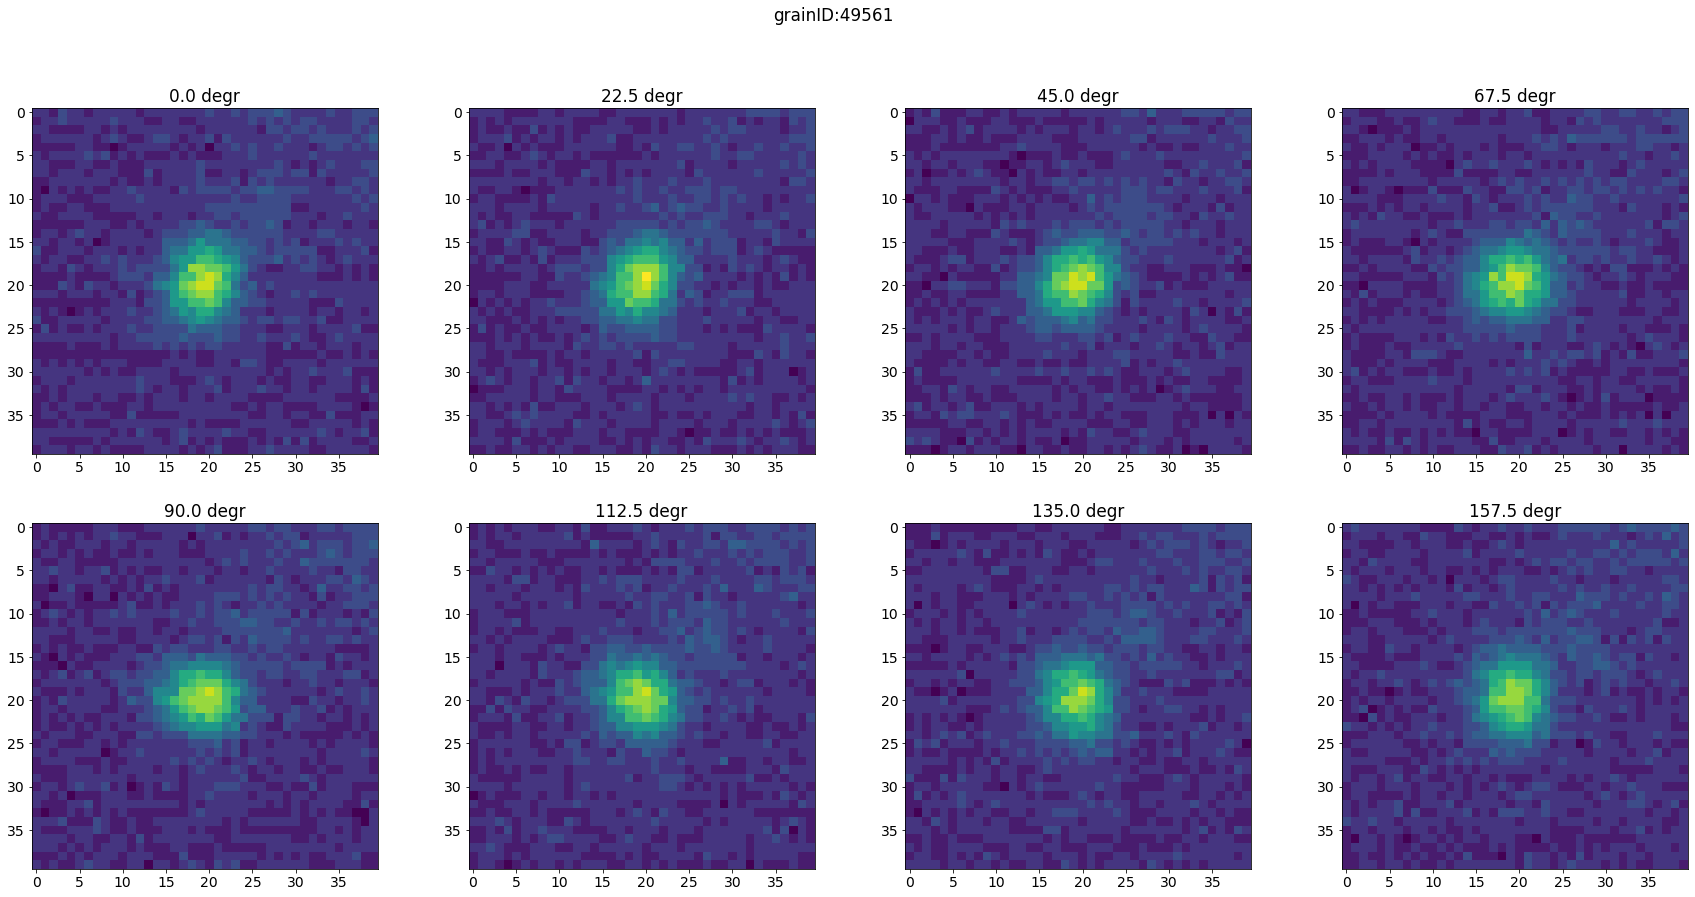

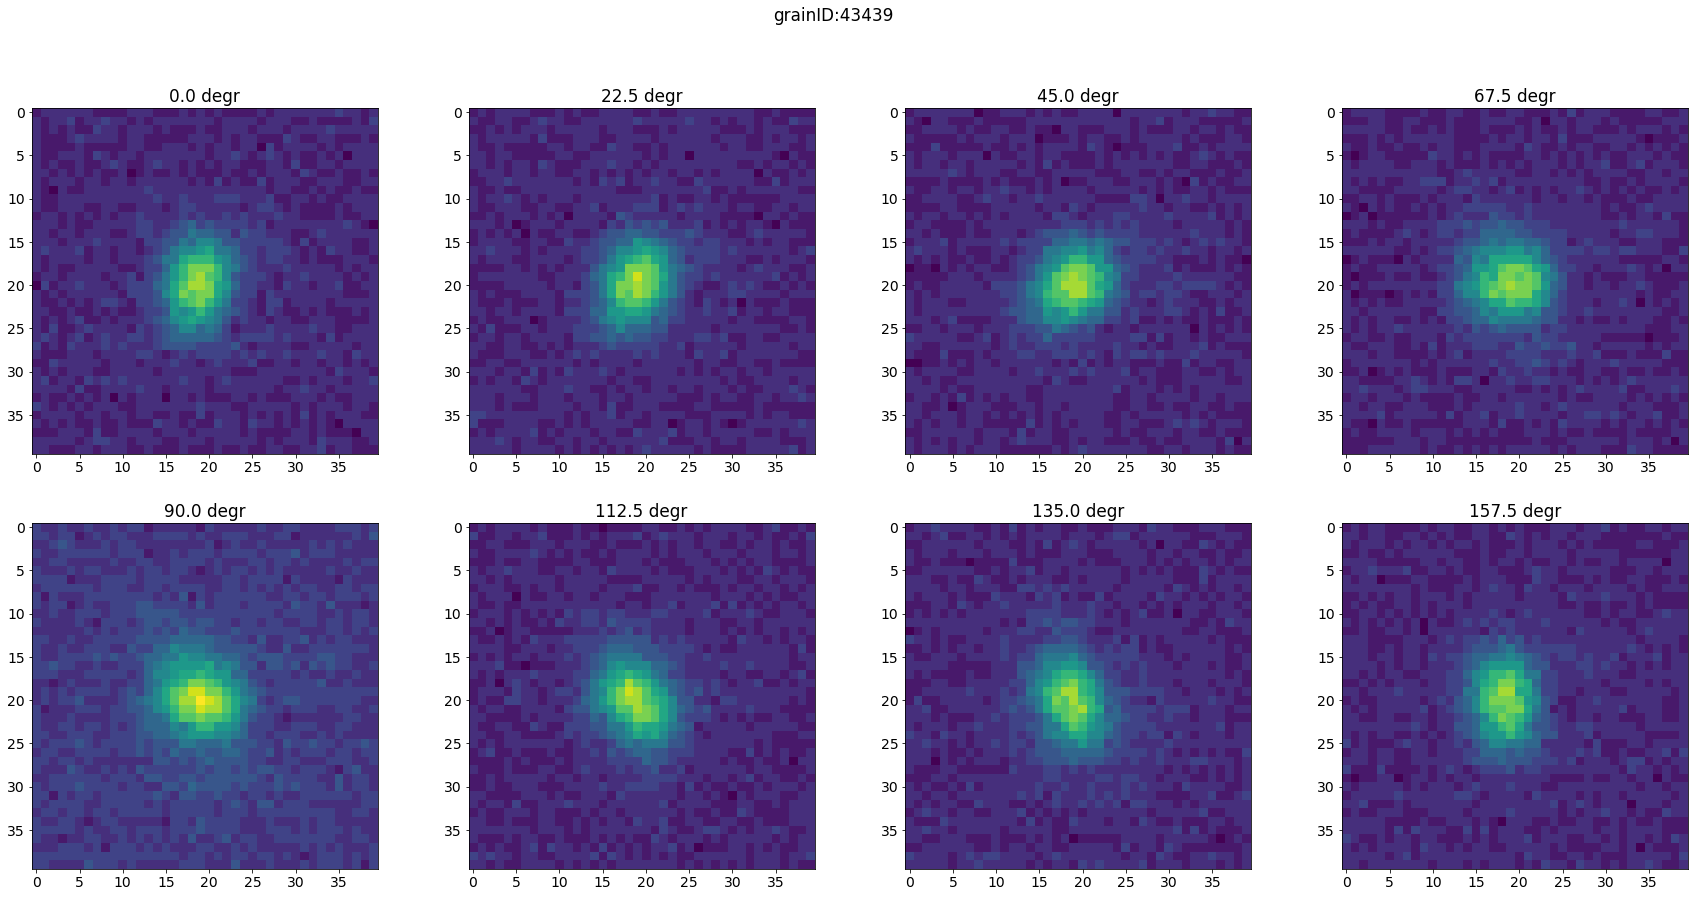

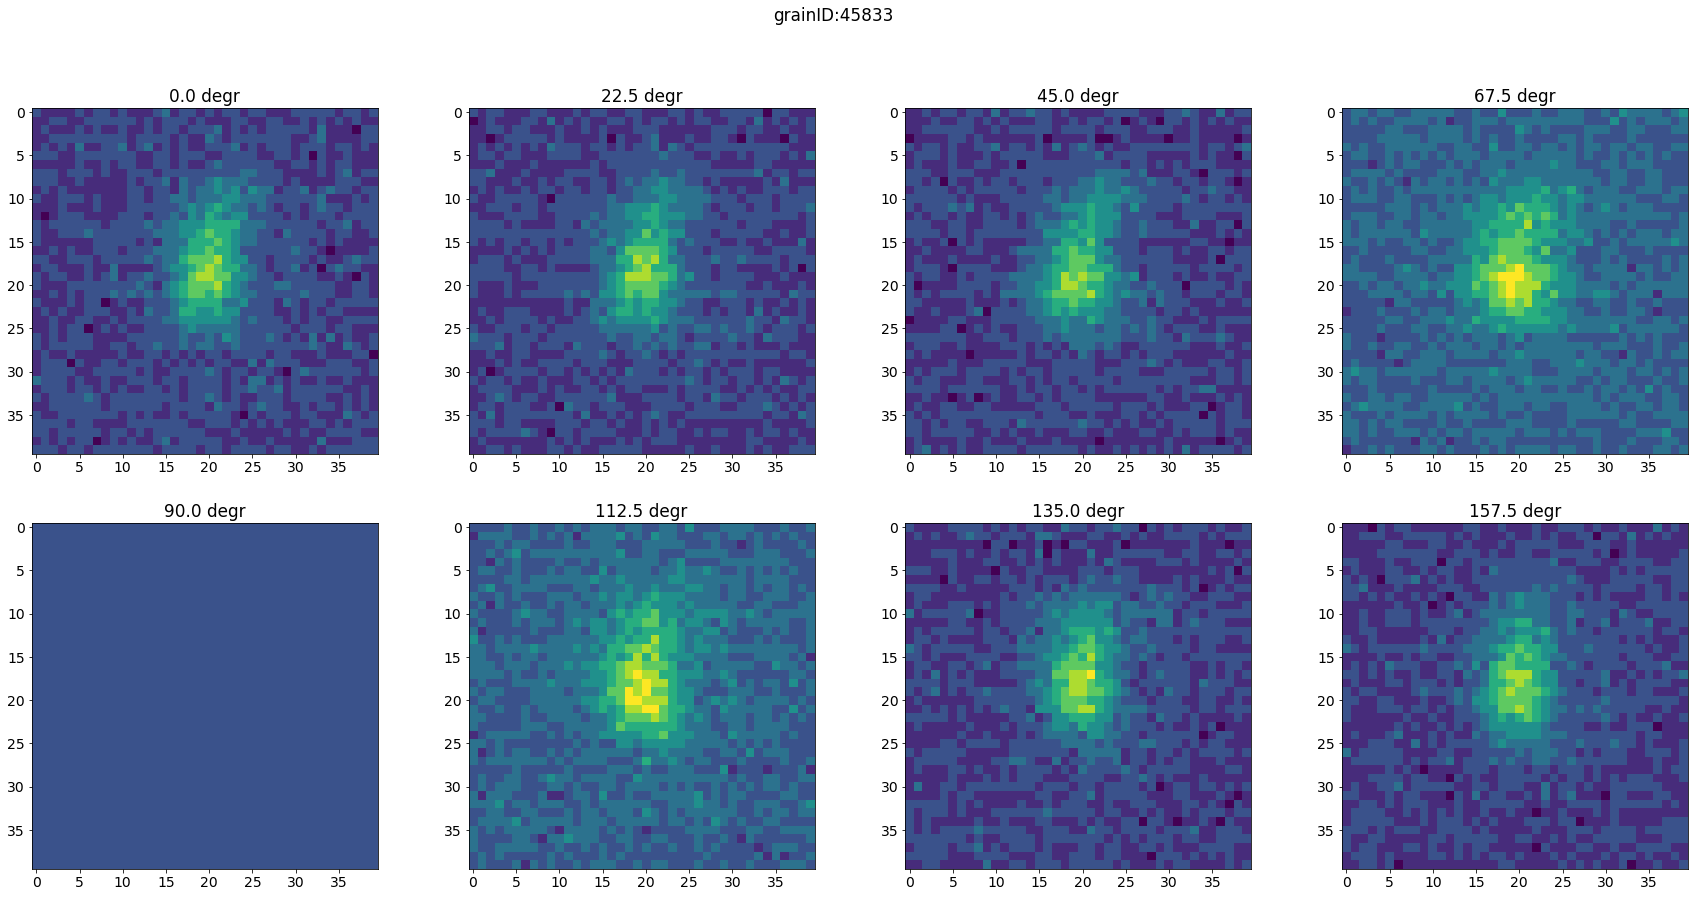

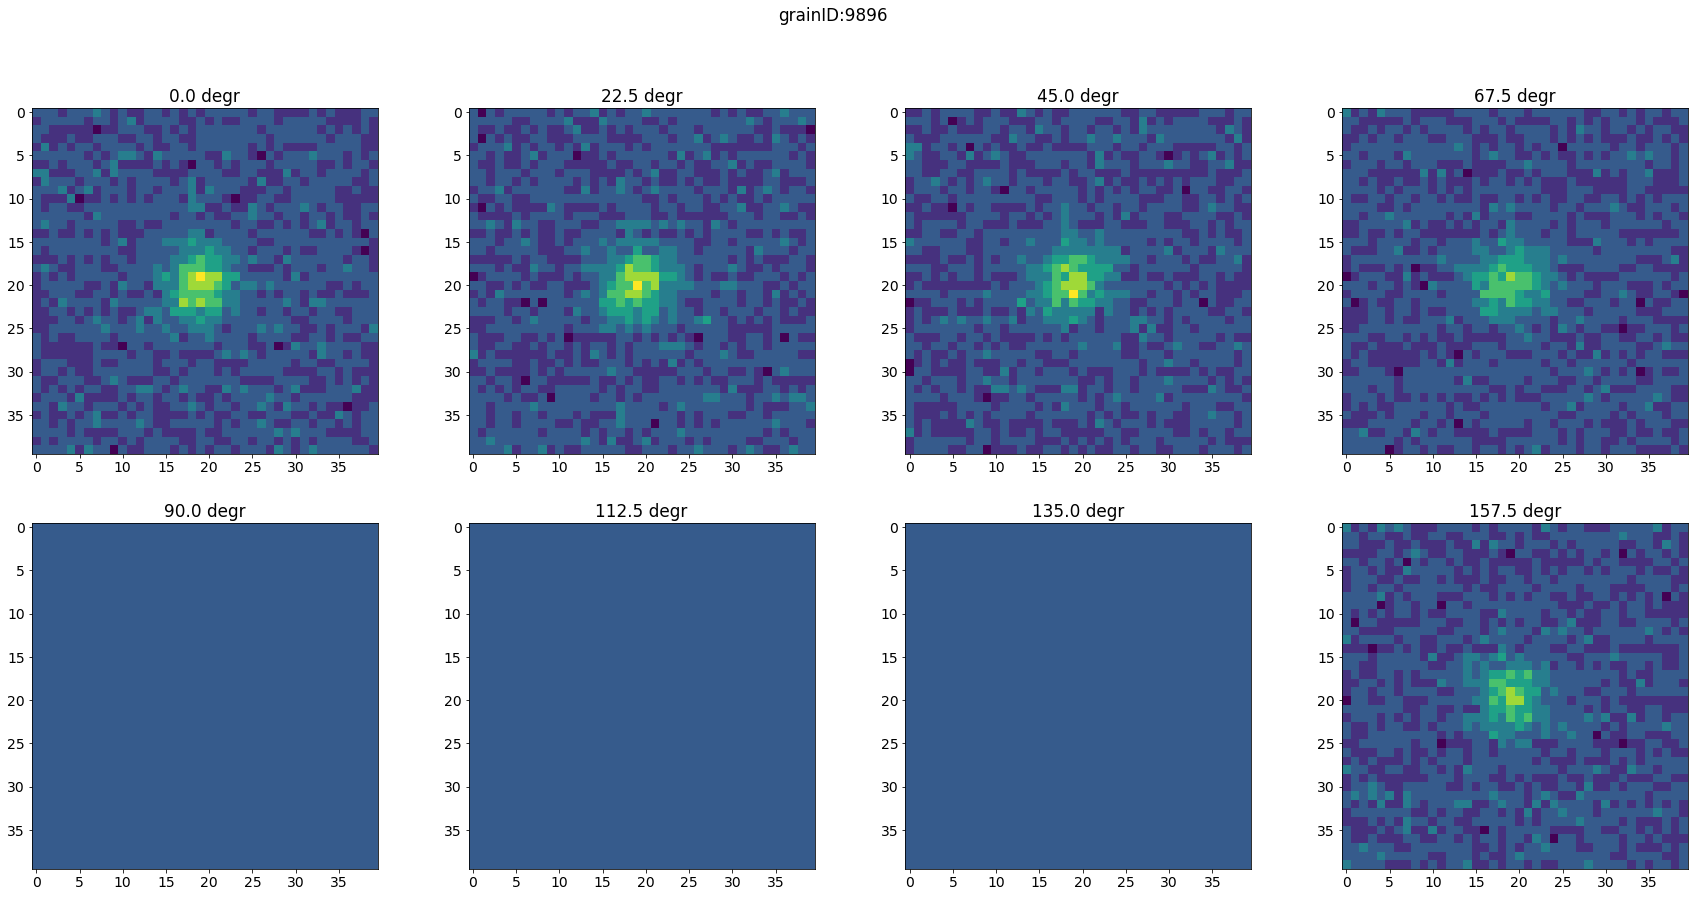

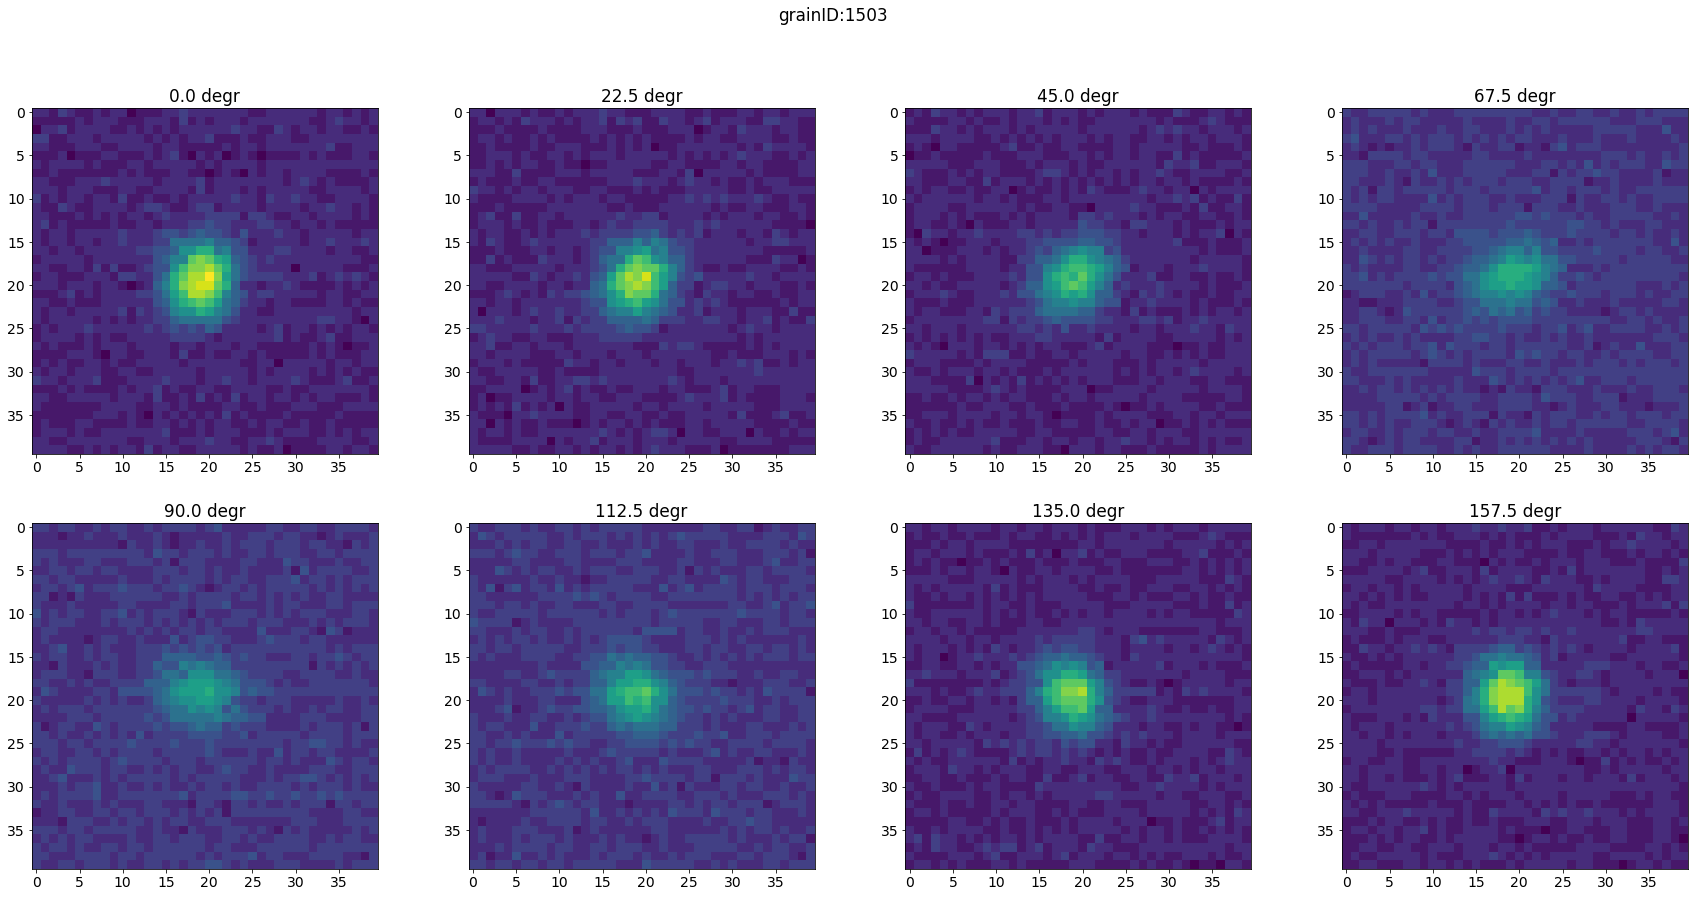

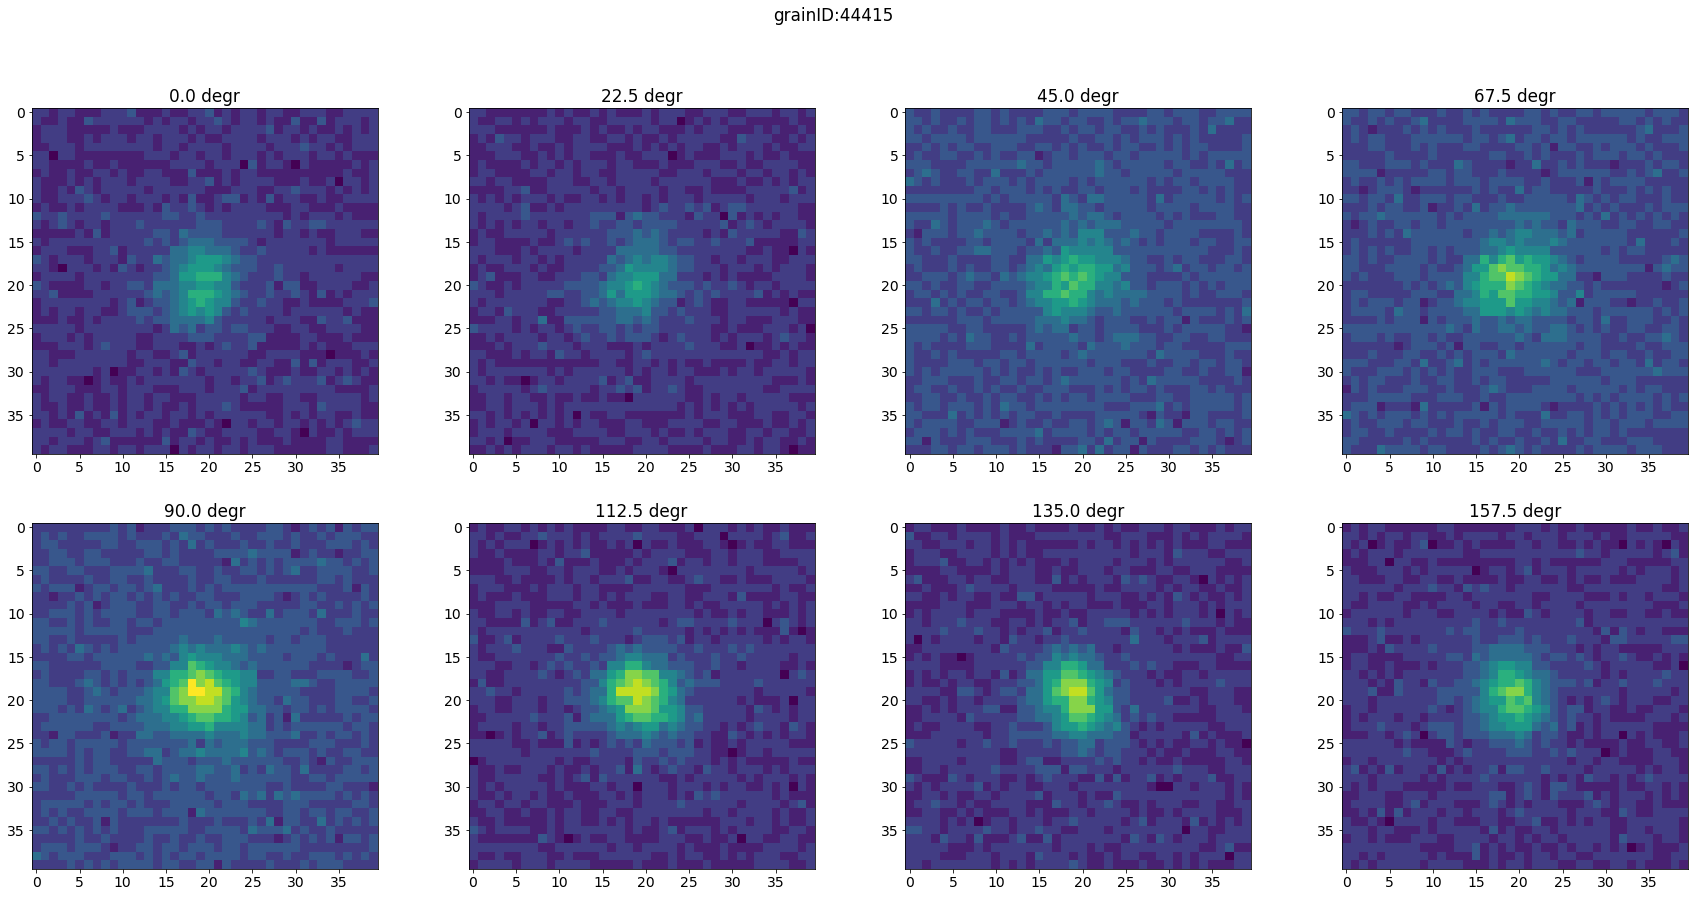

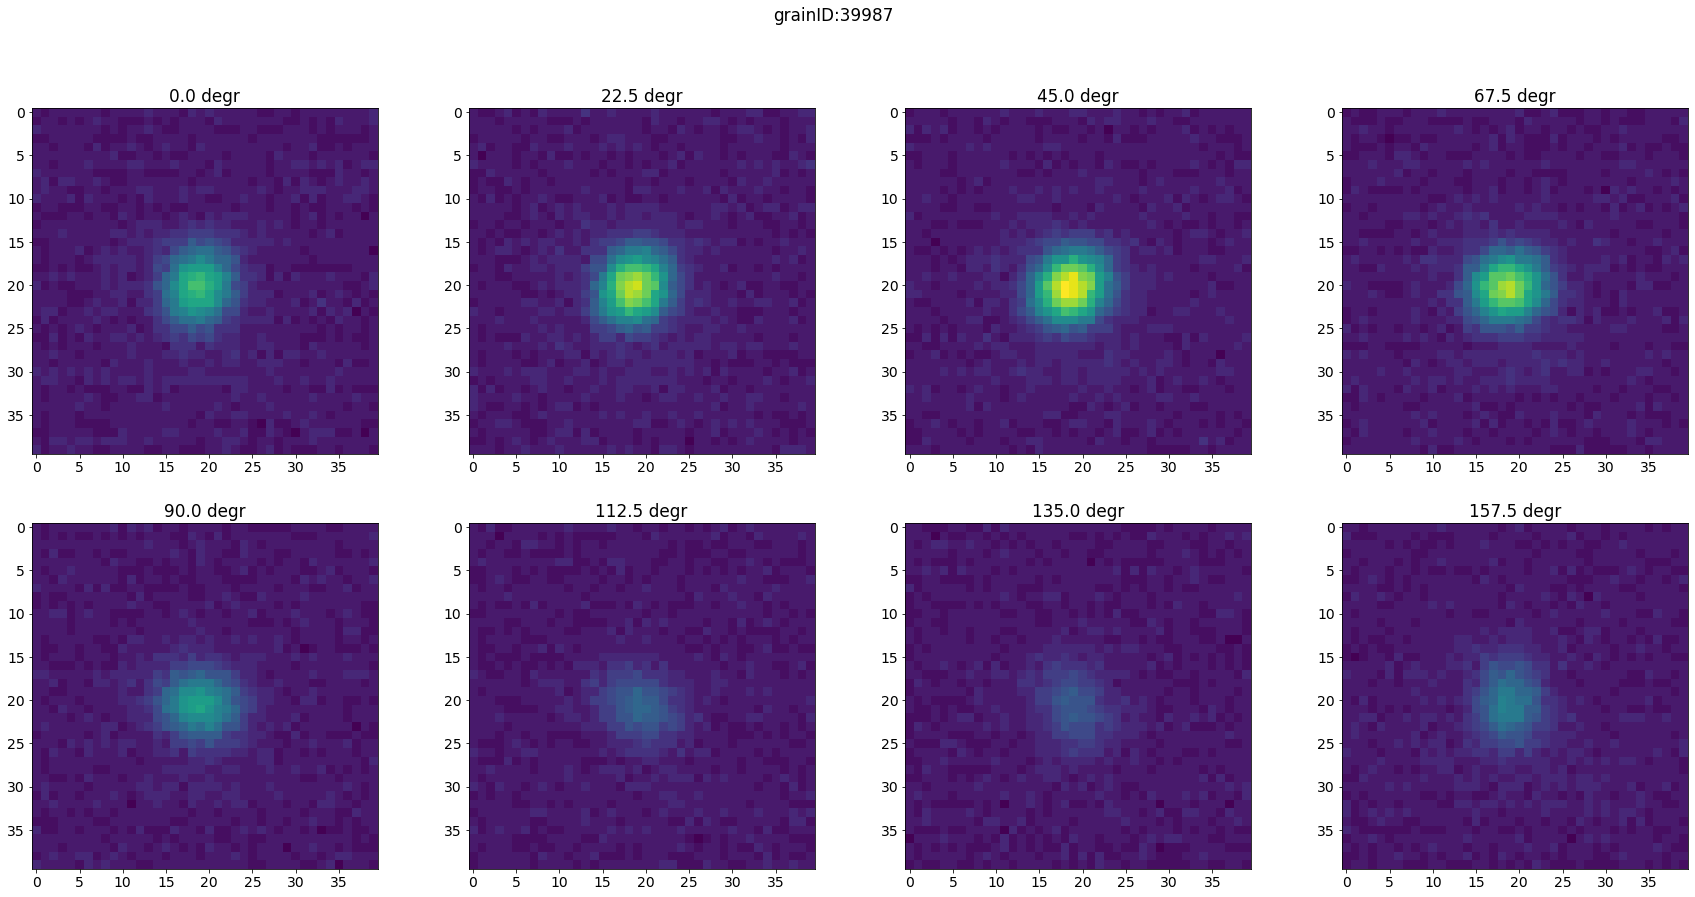

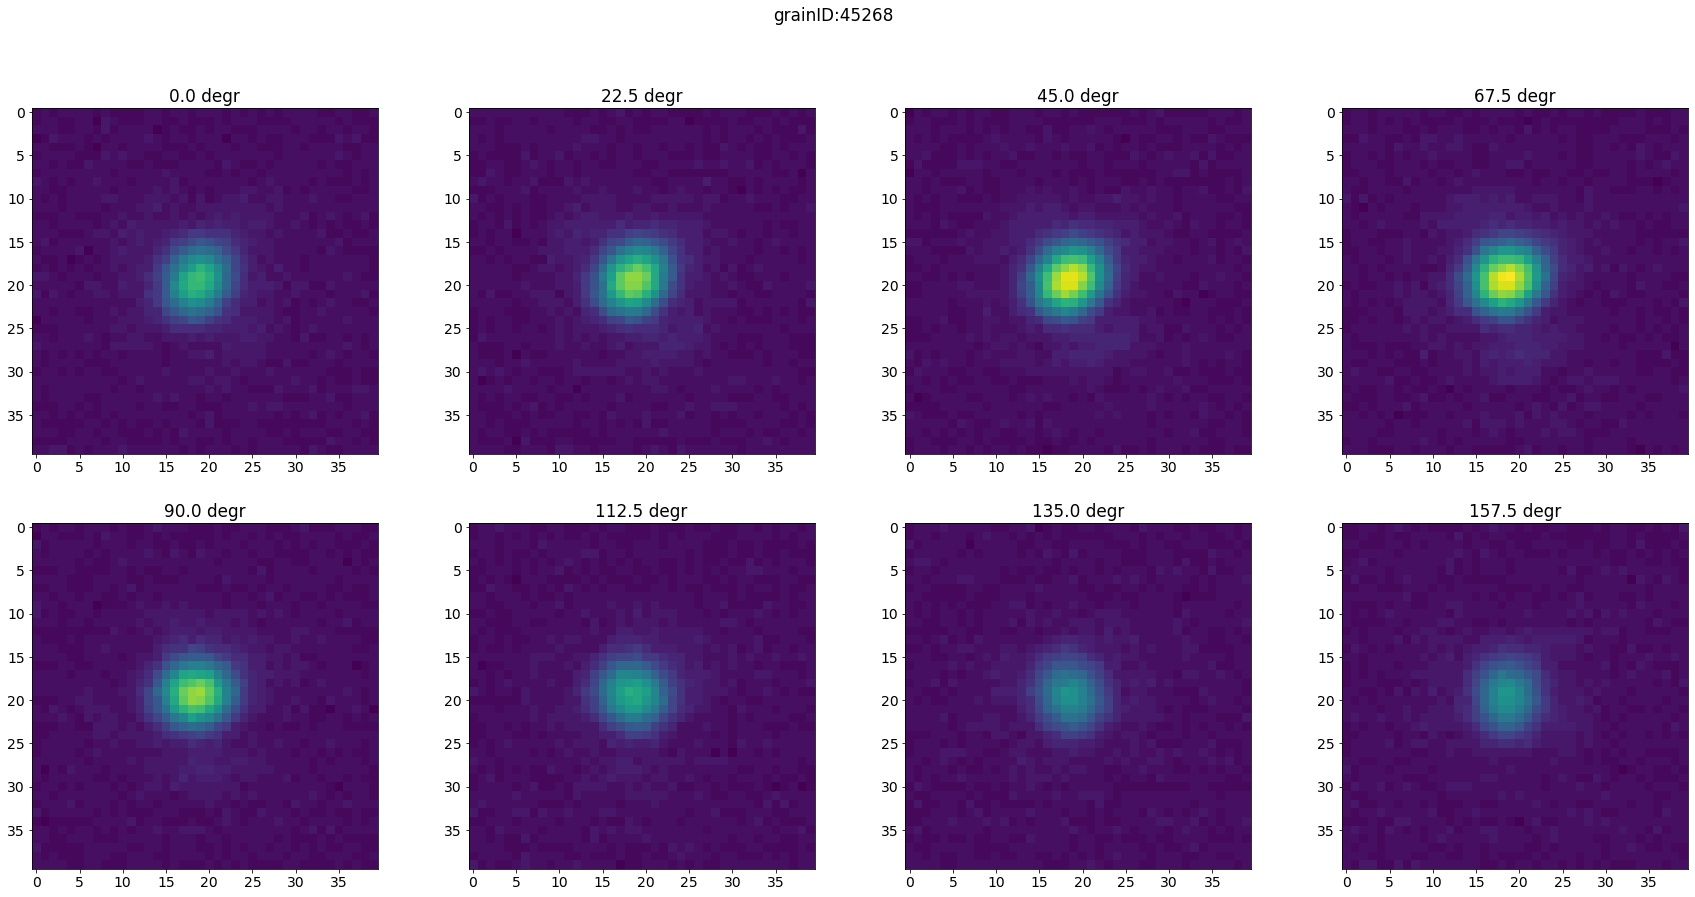

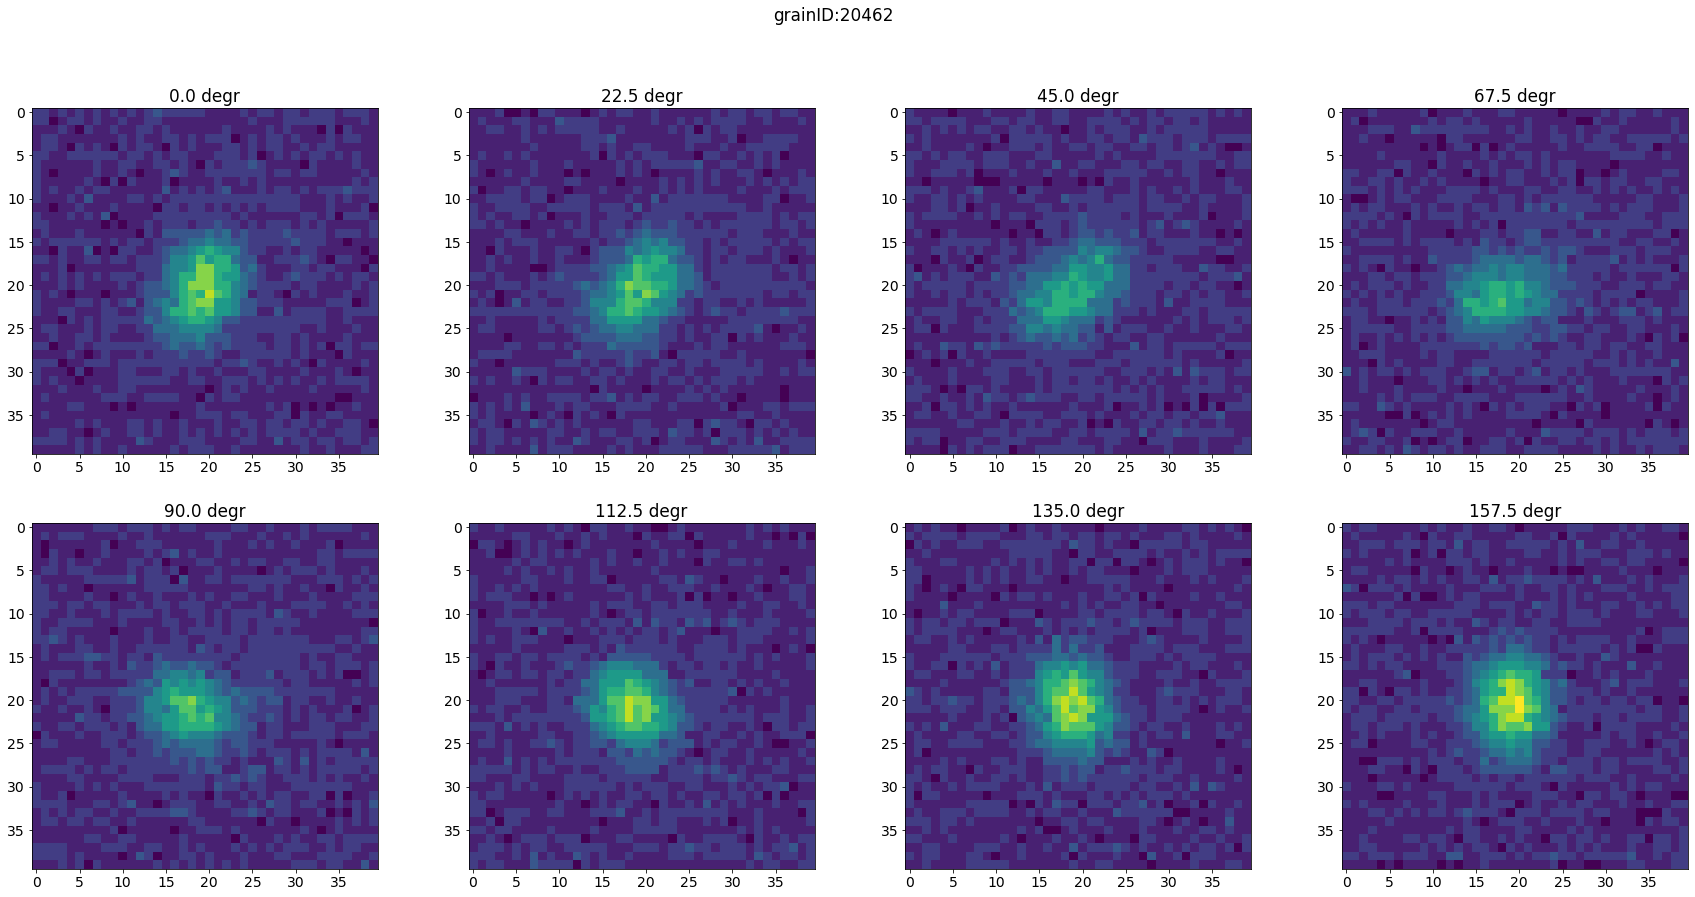

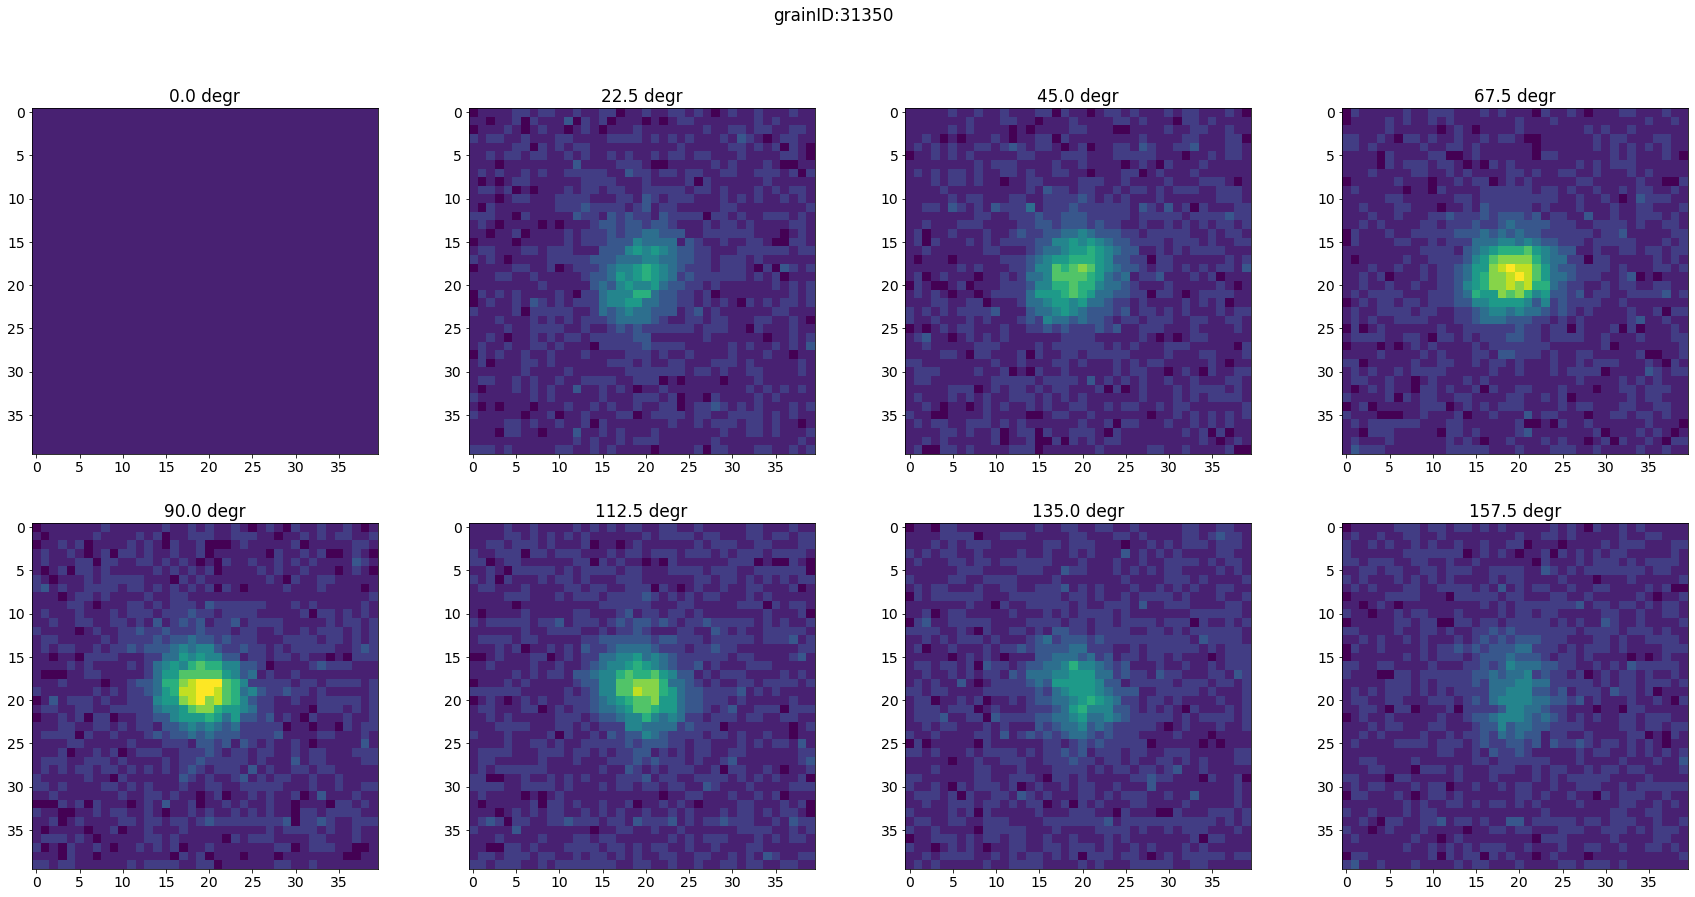

In [86]:
with h5py.File(dset+'ready-to-isolate/fog.h5','r') as df:
    for count in range(10):
        plt.rcParams.update({'font.size': 14})
        fig, axes = plt.subplots(2, 4, figsize=(30,14))
        axes = np.ravel(axes)

        n = np.random.randint(df['train/images'].shape[0])
        im_showed = []
        fig.suptitle('grainID:{}'.format(n))
        imgs = df['train/images'][n,...,:8]
        for i in range(8):
            im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i]))
            axes[i].set_title('{:.1f} degr'.format(i*180/8))
            
        vmin = np.min(df['train/images'][n])
        vmax = np.max(df['train/images'][n])
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for i in range(8):
            im_showed[i].set_norm(norm)
        plt.show()

In [36]:
n = 45268

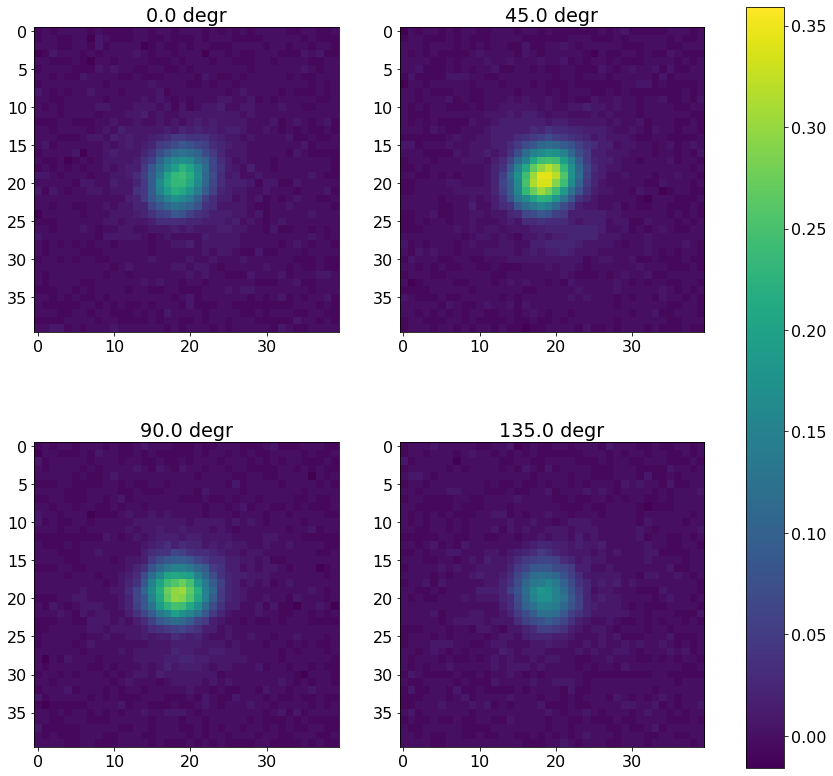

In [37]:
from matplotlib import colors

save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'
with h5py.File(dset+'ready-to-isolate/fog.h5','r') as df:
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(2, 2, figsize=(15,14))
    axes = np.ravel(axes)
    #fig.suptitle('')
    imgs = df['train/images'][n,...,:8]
    im_showed = []
    for i in range(4):
        im_showed.append(axes[i].imshow(df['train/images'][n,:,:,i*2]))
        axes[i].set_title('{:.1f} degr'.format(i*2*180/8))
    # normalizing colours and colorbar
    vmin = np.min(df['train/images'][n])
    vmax = np.max(df['train/images'][n])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i in range(4):
        im_showed[i].set_norm(norm)
    fig.colorbar(im_showed[0], ax=axes, location='right')
    plt.savefig(save_dir+'imgs_fog.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

# DEPRECATED

In [11]:
def get_inverse_interval(gauss_mean, gauss_std, sample_size=10000, cl=0.95, ensemble_size=10, scale=True):
    sample = np.random.normal(gauss_mean, gauss_std, sample_size)
    sample = 1/sample[sample>1e-7]
    m = np.mean(sample)
    low = m - (m-np.quantile(sample, 0.5-cl/2))/np.sqrt(ensemble_size) if scale else np.quantile(sample, 0.5-cl/2)
    up = m + (np.quantile(sample, 0.5+cl/2)-m)/np.sqrt(ensemble_size) if scale else np.quantile(sample, 0.5+cl/2)
    return low, up, m

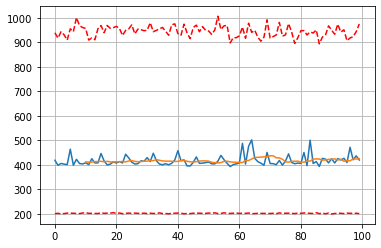

In [33]:
copa = np.array([0.003,0.001])
quants = np.zeros((100,3))
for i in range(100):
    quants[i] = get_inverse_interval(*copa, scale=False, sample_size=10000)
mean_quants = np.zeros(90)
for i in range(90):
    mean_quants[i] = np.mean(quants[i:i+10,-1])
plt.plot(quants[:,-1])
plt.plot(quants[:,1], '--r')
plt.plot(quants[:,0], '--r')
plt.plot(range(10,100), mean_quants)
plt.grid()

#### DEPRECATED REJECTION POWER

C30keV vs fog
thresh:	 0.9929869987070561 
eff:	 0.3130769230769231 
rej:	 698.2857142857143
C60keV vs fog
thresh:	 0.9929880723357201 
eff:	 0.5124615384615384 
rej:	 698.2857142857143
C100keV vs fog
thresh:	 0.9929867632687092 
eff:	 0.3811538461538462 
rej:	 698.2857142857143


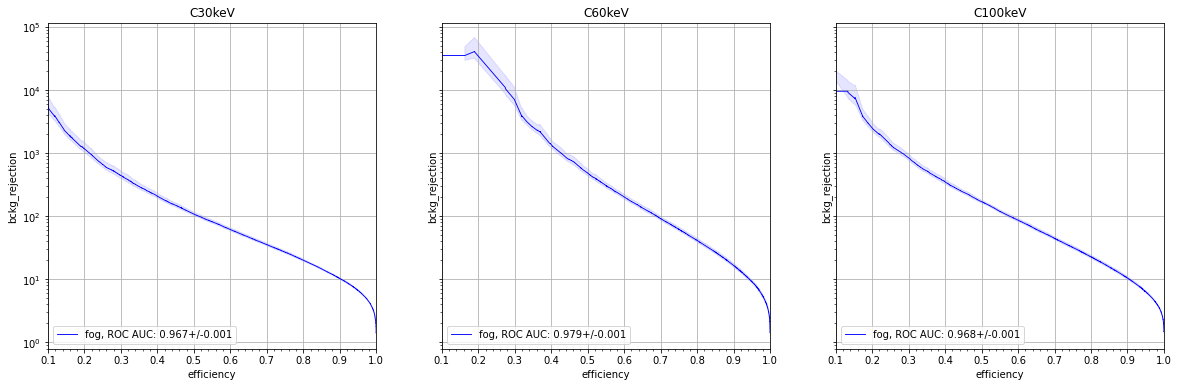

roc plots time: 0:00:31.634386


In [48]:
### DEPRECATED REJECTION POWER

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

# inter_curves, normal_params = {}, {}, {}
inverse_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0])))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0]
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0])
    normal_params = np.zeros((2, len(mean_pred_curve[0])))
    normal_params[0] = np.mean(inter_curves[:,1,:], axis=0)
    normal_params[1] = np.std(inter_curves[:,1,:], axis=0)
    
    inverse_curves[s] = np.zeros((3, len(mean_pred_curve[0])))
    mean_curves[s] = np.array(mean_pred_curve)
    for j in range(inverse_curves[s].shape[-1]):
        inverse_curves[s][:,j] = get_inverse_interval(*normal_params[:,j])
    del inter_curves, normal_params; gc.collect()

# mean_preds = {s: np.mean(preds[s], axis=0) for s in sign}
# std_preds = {s: np.std(preds[s], axis=0, ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

# up_preds = {s: np.clip(mean_preds[s]+std_preds[s], 0,1) for s in sign}
# low_preds = {s: np.clip(mean_preds[s]-std_preds[s], 0,1) for s in sign}

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t',(mean_curves[s][1][i_half])**-1)
    thresh_half = thr[i_half]
    
    mask_plot = mean_curves[s][0]>0.05
    # for convenience, the main line
    tpr = mean_curves[s][0]; fpr = inverse_curves[s][-1]
    i=0
    while (not (fpr[mask_plot])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
    fpr = np.append([(fpr[mask_plot])[i]], (fpr[mask_plot])[i:])
    tpr = np.append([0.05], (tpr[mask_plot])[i:])
#     sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    
#     fpr_up = roc_curve(y_true_sb,up_preds[s])
#     fpr_low = roc_curve(y_true_sb,low_preds[s])
    
    if len(tpr)==len(inverse_curves[s][0]):
        axes[j].fill( np.append(tpr,tpr[::-1]), np.append(inverse_curves[s][0],(inverse_curves[s][1])[::-1]), color=col[b],alpha=0.1 )
    else:
        axes[j].fill( np.append(tpr[1:],tpr[:0:-1]), np.append(inverse_curves[s][0],(inverse_curves[s][1])[::-1]), color=col[b],alpha=0.1 )
    
    axes[j].legend(loc=3)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('efficiency')
    axes[j].set_xlim(0.1,1.0)
    axes[j].set_ylabel('bckg_rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.show()
print('roc plots time:', datetime.now()-start)

In [25]:
print(val_mean['fog'], val_std['fog']/2.262*np.sqrt(ensemble_size))

0.0030658171615618427 0.0012225068960110034


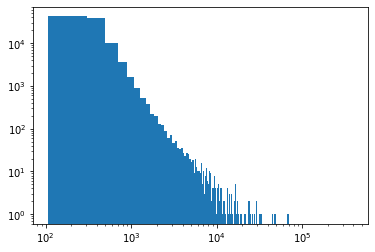

In [27]:
bckg_rej = np.random.normal(val_mean['fog'], val_std['fog']/2.262*np.sqrt(ensemble_size), 100000)
bckg_rej = bckg_rej[bckg_rej>1e-6]
plt.hist(1/bckg_rej, bins=2000);
plt.yscale('log')
plt.xscale('log')

In [29]:
print('upper bound: {:.1f}'.format(np.quantile(1/bckg_rej, 0.975)))
print('lower bound: {:.1f}'.format(np.quantile(1/bckg_rej, 0.025)))
print('mean before: {:.1f}'.format(1/val_mean['fog']))
print('mean after:  {:.1f}'.format(np.mean(1/bckg_rej)))
print('median after:{:.1f}'.format(np.median(1/bckg_rej)))
print('interval mid:{:.1f}'.format((np.quantile(1/bckg_rej, 0.975)-np.quantile(1/bckg_rej, 0.025))/2))

upper bound: 1266.7
lower bound: 182.7
mean before: 326.2
mean after:  472.8
median after:325.4
interval mid:542.0


In [23]:
1/bckg_rej

array([356.91682729, 329.76912512, 230.65742874, ..., 335.92279463,
       847.45535243, 256.7323114 ])

### without checkpoints

In [9]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-isolate/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=50, validation_split=4000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 256, 'epochs': 50, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 

Epoch 1/50
1283/1283 [==============================] - 1029s 802ms/step - loss: 1.4595 - val_loss: 1.3039
Epoch 2/50
1283/1283 [==============================] - 1011s 788ms/step - loss: 1.3264 - val_loss: 1.2435
Epoch 3/50
1283/1283 [==============================] - 1012s 788ms/step - loss: 1.2067 - val_loss: 1.1089
Epoch 4/50
1283/1283 [==============================] - 1012s 789ms/step - loss: 1.1096 - val_loss: 0.9573
Epoch 5/50
1283/1283 [==============================] - 1012s 789ms/step - loss: 0.9614 - val_loss: 0.9169
Epoch 6/50
1283/1283 [==============================] - 1012s 789ms/step - loss: 0.8664 - val_loss: 0.8457
Epoch 7/50
1283/1283 [=======

In [10]:
best_kek.save_model('model_iso_50iter_4cl.h5')
del X_tr, y_tr; gc.collect();

In [8]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-isolate/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=50, validation_split=4000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 256, 'epochs': 50, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 

Epoch 1/50
1283/1283 [==============================] - 1047s 816ms/step - loss: 1.4626 - val_loss: 1.3625
Epoch 2/50
1283/1283 [==============================] - 1028s 801ms/step - loss: 1.1385 - val_loss: 0.9993
Epoch 3/50
1283/1283 [==============================] - 1029s 802ms/step - loss: 0.9269 - val_loss: 0.8952
Epoch 4/50
1283/1283 [==============================] - 1029s 802ms/step - loss: 0.8397 - val_loss: 0.7938
Epoch 5/50
1283/1283 [==============================] - 1029s 802ms/step - loss: 0.7824 - val_loss: 0.8178
Epoch 6/50
 876/1283 [===================>..........] - ETA: 5:25 - loss: 0.7438

ResourceExhaustedError:  OOM when allocating tensor with shape[256,64,38,38,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients/pool1/MaxPool3D_grad/MaxPool3DGrad (defined at /home/scanner-ml/anaconda3/envs/ML_new_fixed/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_33434]

Function call stack:
keras_scratch_graph


In [10]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-isolate/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=4000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 

Epoch 1/50
655/655 [==============================] - 577s 881ms/step - loss: 1.4496 - val_loss: 1.4294
Epoch 2/50
655/655 [==============================] - 554s 846ms/step - loss: 1.2872 - val_loss: 1.2622
Epoch 3/50
655/655 [==============================] - 553s 844ms/step - loss: 1.1952 - val_loss: 1.0945
Epoch 4/50
655/655 [==============================] - 554s 845ms/step - loss: 1.0810 - val_loss: 1.1640
Epoch 5/50
655/655 [==============================] - 553s 844ms/step - loss: 1.0231 - val_loss: 0.9366
Epoch 6/50
655/655 [==============================] - 553s 845ms/step - loss: 0.9883 - val_loss: 1.5586
Epoch 7/50
655/655 [===========================

In [ ]:
best_kek.save_model('model_iso_50iter_4cl.h5')
del X_tr, y_tr; gc.collect();

## Performance on validation

In [8]:
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=4000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.load_model('model_iso_50iter_4cl.h5', custom_objects={'swish': swish, 'bentropy':balanced_crossentropy(mu=dict_bay_param['loss_mu'], n_sig_cl=3)})
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 



In [11]:
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']

with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

fog_pred = best_kek.predict_proba(X_fog)
np.savetxt('predict_vs_fog.txt', fog_pred)
print('Carbon vs fog ROC AUC:',best_kek.score(X_fog, y_fog))

del X_fog; gc.collect();

112216/112216 [==============================] - 111s 991us/step
Carbon vs fog ROC AUC: 0.9723587920705862


## Isolated == -1

In [12]:
y = {'fog':y_fog}#, 'gamma':y_gamma, 'gamma_no':y_gamma_no}
pred = {'fog':fog_pred}#, 'gamma':gamma_pred, 'gamma_no':gamma_no_pred}
col = {'fog':'blue','gamma':'red','gamma_no':'maroon'}

C30keV vs fog
thresh:	 0.99798965 
eff:	 0.23423076923076924 
rej:	 503.17647058823525
C60keV vs fog
thresh:	 0.9979443 
eff:	 0.42680769230769233 
rej:	 503.17647058823525
C100keV vs fog
thresh:	 0.99799025 
eff:	 0.3288846153846154 
rej:	 503.17647058823525


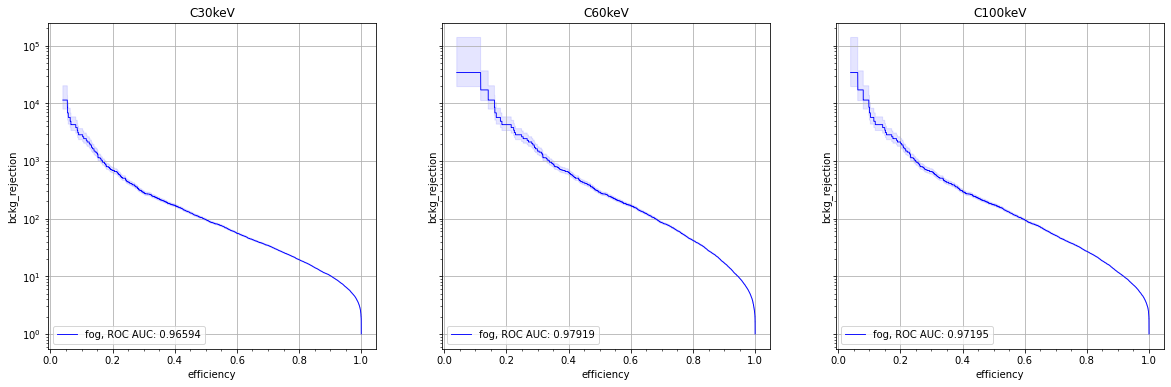

In [14]:
n_sig_cl=3
#thresh_half = {}
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
    for b in bckg:
        #mask = np.zeros(len(y_val), dtype=bool)
        mask = np.bitwise_or(y[b]==categ_dict[b], y[b]==categ_dict[s])
        preds0 = pred[b][mask]
        y_true_sb = y[b][mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        auc = roc_auc_score(y_true_sb, preds0_sb)
        #preds0_sb[:,1], preds90_sb[:,1] = np.sum(preds0[:,n_sig_cl:],axis=1), np.sum(preds90[:,n_sig_cl:],axis=1)

        #plt.figure(figsize=(7,7))
        fpr, tpr, thr = roc_curve(y_true_sb,preds0_sb)
        
        i_half = np.argmin(thr>0.998) 
        #i_half = np.argmax(tpr>0.35)
        #if s+' '+b in ['C30keV fog','C60keV gamma','C100keV gamma_no']:
        print(s,'vs',b);
        print('thresh:\t',thr[i_half],'\neff:\t',tpr[i_half],'\nrej:\t',(fpr[i_half])**-1)
        thresh_half = thr[i_half]
        
        mask = tpr>0.05
        i=0
        while (not (fpr[mask])[i]): i+=1
        #print(i,len(fpr),'\t',(fpr[mask])[i])
        fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
        tpr = np.append([0.04], (tpr[mask])[i:])
        sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
        axes[j].plot(tpr,(fpr)**-1,linewidth=0.9,color=col[b],label=b+', ROC AUC: '+str(np.round(auc, 5)))
        axes[j].fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color=col[b],alpha=0.1 )
    axes[j].legend(loc=3)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('efficiency')
    axes[j].set_ylabel('bckg_rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.show()

In [15]:
from IPython.utils.capture import capture_output
thresh_half = 0.998
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    # Carbon
#     for kev in df['test/Carbon'].keys():
#         pred = best_kek.predict_proba(df['test/Carbon/'+name+'/images'])
#         preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)
#         print('Carbon '+name+'.')
#         print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'eff:',np.sum(preds_sb>thresh_half)/len(preds_sb))
        
    # background
    for name in df['test'].keys():
        #print('\n')
        if name=='Carbon': 
            for kev in df['test/Carbon'].keys():
                with capture_output() as caput:
                    pred = best_kek.predict_proba(df['test/Carbon/'+kev+'/images'][...])
                    pols = df['test/Carbon/'+kev+'/pol_ids'][...]; mask = (pols[:,-2]==-1) #| (pols[:,-2]==2)
                preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)[mask]
                print('\n','Carbon '+kev)
                print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'eff:',np.sum(preds_sb>thresh_half)/len(preds_sb))
        else:
            with capture_output() as caput:
                pred = best_kek.predict_proba(df['test/'+name+'/images'][...])
                pols = df['test/'+name+'/pol_ids'][...]; mask = pols[:,-2]==-1
            preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)[mask]
            print('\n',name)
            print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'rej:',len(preds_sb)/np.sum(preds_sb>thresh_half))
gc.collect();


 Carbon 100keV
Total: 41872 sign: 15232 eff: 0.3637753152464654

 Carbon 30keV
Total: 71118 sign: 6601 eff: 0.09281757079782896

 Carbon 60keV
Total: 43474 sign: 17557 eff: 0.4038505773565809

 fog
Total: 48253 sign: 45 rej: 1072.2888888888888

 gamma
Total: 24434 sign: 89 rej: 274.53932584269666

 test_sample_2020
Total: 136957 sign: 6545 rej: 20.925439266615736


In [129]:
from IPython.utils.capture import capture_output
thresh_half = 0.997
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    # Carbon
    with capture_output() as caput:
        pred = best_kek.predict_proba(df['test/Carbon/30keV/images'][...])
        pols = df['test/Carbon/30keV/pol_ids'][...]; mask = pols[:,-2]!=-2
    preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)[mask]
    shuff = np.random.permutation(preds_sb.shape[0])[:72000]
    preds_sb = preds_sb[shuff]
    
    with capture_output() as caput:
        pred = best_kek.predict_proba(df['test/Carbon/60keV/images'][...])
        pols = df['test/Carbon/60keV/pol_ids'][...]; mask = pols[:,-2]!=-2
    preds_tmp = np.sum(pred[:,:n_sig_cl],axis=1)[mask]
    shuff = np.random.permutation(preds_tmp.shape[0])[:13560]
    preds_sb = np.append(preds_sb, preds_tmp[shuff])
    print('\n','WIMP 1000GeV with C_30-60-100keV')
    print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'eff:',np.sum(preds_sb>thresh_half)/len(preds_sb))

gc.collect();


 WIMP 1000GeV with C_30-60-100keV
Total: 85560 sign: 20804 eff: 0.24315100514259


## Checking new cuts on test scans

In [16]:
path_dir = '/mnt/ML-drive/Artem/70nm/Oct2019_N123gf/'
sig_dirs = ['Carbon/30keV/test','Carbon/60keV/test','Carbon/100keV/test']
#bckg_dirs = ['gamma/gamma_check/gamma_opmark_med','fog/Scan17_22.11','fog/Scan18_25.11','fog/Scan19_28.11','fog/Scan21_2.12','fog/Scan22_3.12','fog/Scan23_4.12']
bckg_dirs = ['fog/Scan17','fog/Scan18','fog/Scan19','fog/Scan21','fog/Scan22','fog/Scan23']
n_sig_cl = 3

In [17]:
thresh_half = 0.998

In [64]:
test_feats = pd.DataFrame(np.zeros((0,10)), columns=['HeadID','ViewID','grID', 'clID','bar_shift','phi','area','bright', 'sample', 'prediction'])
fog_init = False
for name in sig_dirs+bckg_dirs:
    print(name)
    full_feats = pd.read_csv(path_dir+name+'/sig_grains.txt', header=None, names=['HeadID','ViewID','grID', 'clID','bar_shift','phi','area','bright'])
    name = '/'.join(name.split('/')[:-1])
    if not fog_init or name!='fog':
        with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as data_sb:
            preds = np.sum(best_kek.predict_proba(data_sb['test/'+name+'/images'][...])[:,:3], axis=1)
            pols = data_sb['test/'+name+'/pol_ids'][...]
            mask = pols[:,-2]==-1
            preds = np.hstack((pols, preds[:,np.newaxis]))[mask]
            if name=='fog': fog_init = True
    id_mask = np.zeros(len(full_feats.index), dtype=bool)
    feat_preds = np.zeros(len(full_feats.index))
    for v in np.unique(preds[:,1]):
        view_feats = full_feats[full_feats['ViewID']==v]
        view_preds = preds[preds[:,1]==v]
        if not view_feats.shape[0] or not view_preds.shape[0]:
            # if some view is absent - skip
            continue
        for gr in np.unique(view_preds[:,2]):
            gr_feats = view_feats[view_feats['grID']==gr]
            gr_preds = view_preds[view_preds[:,2]==gr]
            if not gr_feats.shape[0] or not gr_preds.shape[0]:
                # if some grain is absent - skip
                continue
            if gr_preds.shape[0]>1:
                for cl in np.unique(gr_preds[:,3]):
                    if not np.sum(gr_preds[:,3]==cl) or not np.sum(gr_feats['clID']==cl) or not (np.sum(gr_preds[:,3]==cl) == np.sum(gr_feats['clID']==cl)):
                        # if cluster_id is absent or ambiguos - skip
                        continue
                    id_mask[gr_feats[gr_feats['clID']==cl].index] = True
                    feat_preds[gr_feats[gr_feats['clID']==cl].index] = (gr_preds[gr_preds[:,3]==cl])[:,-1]
            else:
                if not (len(gr_preds) == len(gr_feats)):
                    # if there is ambiguity - skip
                    continue
                id_mask[gr_feats.index] = True
                feat_preds[gr_feats.index] = gr_preds[:,-1]
    tmp_feats = full_feats.loc[id_mask].reset_index(drop=True)
    tmp_feats.loc[:, 'sample'] = name
    tmp_feats.loc[:, 'prediction'] = feat_preds[id_mask]
    print(tmp_feats.shape)
    test_feats = pd.concat([test_feats, tmp_feats], ignore_index=True)
    gc.collect();

Carbon/30keV/test
95310/95310 [==============================] - 94s 991us/step
(71118, 10)
Carbon/60keV/test
108157/108157 [==============================] - 107s 992us/step
(43154, 10)
Carbon/100keV/test
70813/70813 [==============================] - 70s 994us/step
(41872, 10)
fog/Scan17
57966/57966 [==============================] - 58s 993us/step
(23905, 10)
fog/Scan18
(5935, 10)
fog/Scan19
(5305, 10)
fog/Scan21
(4016, 10)
fog/Scan22
(5979, 10)
fog/Scan23
(6442, 10)


In [65]:
print(test_feats.shape,'\n', test_feats.columns)

(207726, 10) 
 Index(['HeadID', 'ViewID', 'grID', 'clID', 'bar_shift', 'phi', 'area',
       'bright', 'sample', 'prediction'],
      dtype='object')


In [66]:
print(np.unique(test_feats['sample'], return_counts=True))

(array(['Carbon/100keV', 'Carbon/30keV', 'Carbon/60keV', 'fog'],
      dtype=object), array([41872, 71118, 43154, 51582]))


In [67]:
test_feats.to_csv('test_feats_preds.csv')

In [68]:
test_feats.head()

,HeadID,ViewID,grID,clID,bar_shift,phi,area,bright,sample,prediction
0,10.0,9.0,0.0,327.0,0.016631,-0.103286,62.0,11.61290,Carbon/30keV,0.988746
1,10.0,9.0,1.0,325.0,0.019935,-1.071580,24.0,4.75000,Carbon/30keV,0.932669
2,10.0,9.0,3.0,321.0,0.028730,-0.238264,26.0,4.03846,Carbon/30keV,0.668130
3,10.0,9.0,5.0,-1.0,0.030641,1.448230,11.0,3.27273,Carbon/30keV,0.929562
4,10.0,9.0,7.0,322.0,0.025300,0.861222,15.0,3.26667,Carbon/30keV,0.935531


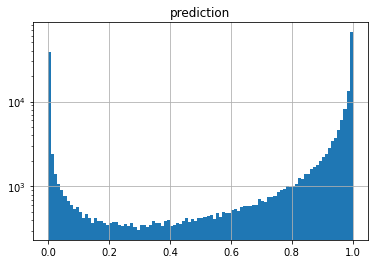

In [70]:
test_feats.hist(column=['prediction'], bins=100)
plt.yscale('log')

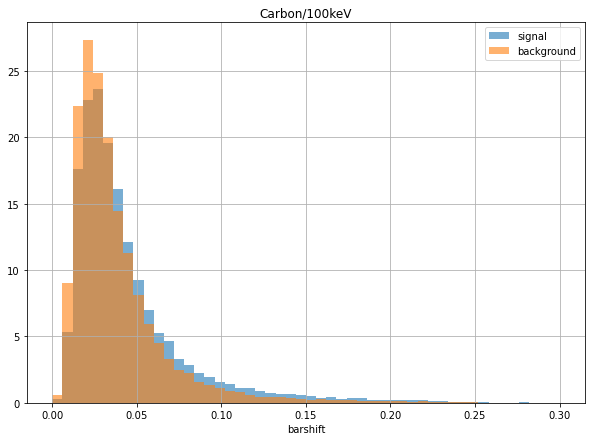

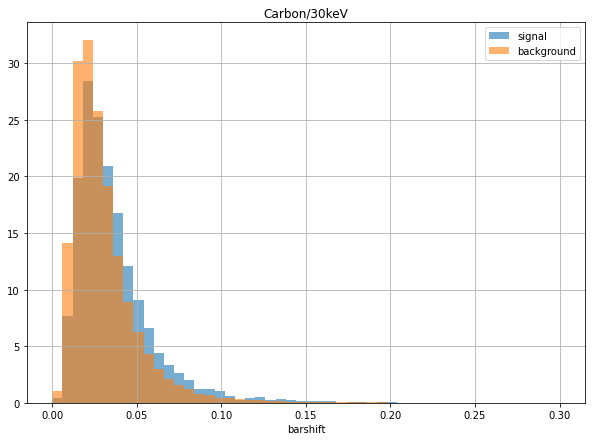

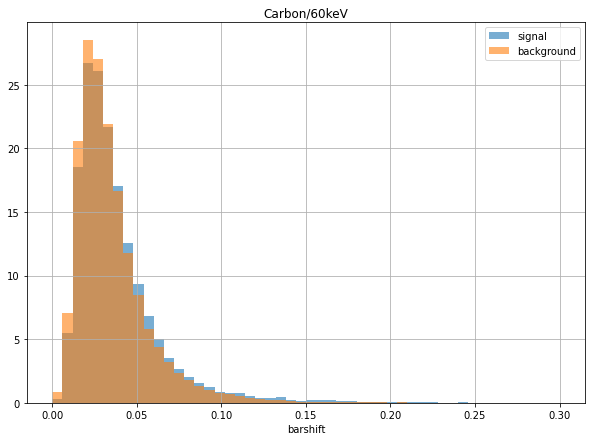

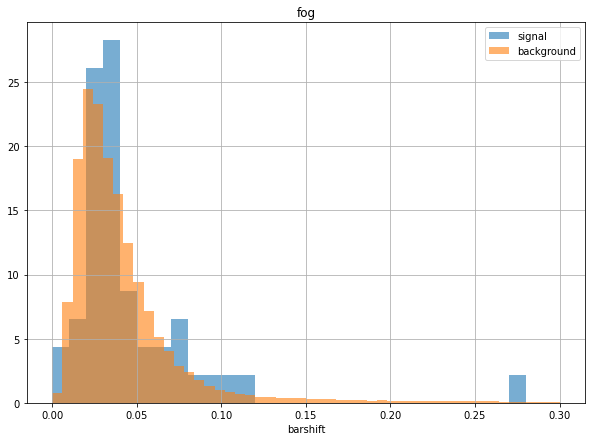

In [88]:
for name, sopa in test_feats.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['bar_shift'], density=True, range=(0,0.3), bins=30, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['bar_shift'], density=True, range=(0,0.3), bins=50, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['bar_shift'], density=True, range=(0,0.3), bins=50, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('barshift')
    plt.legend()
    plt.title(name)
    plt.show()

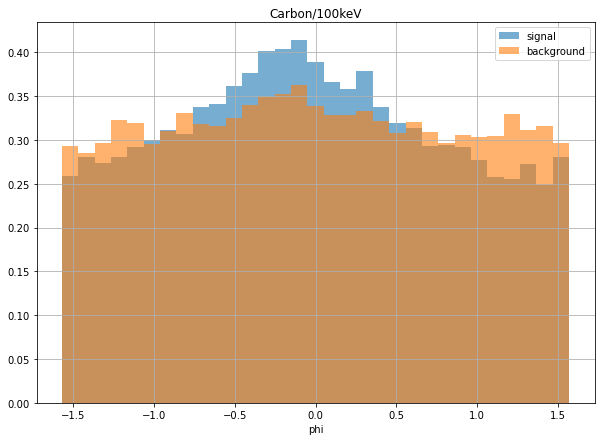

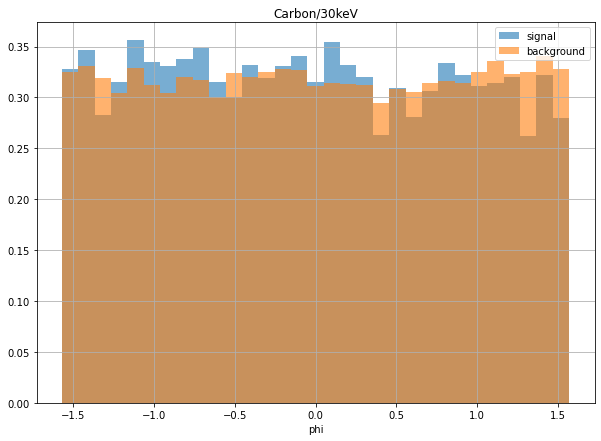

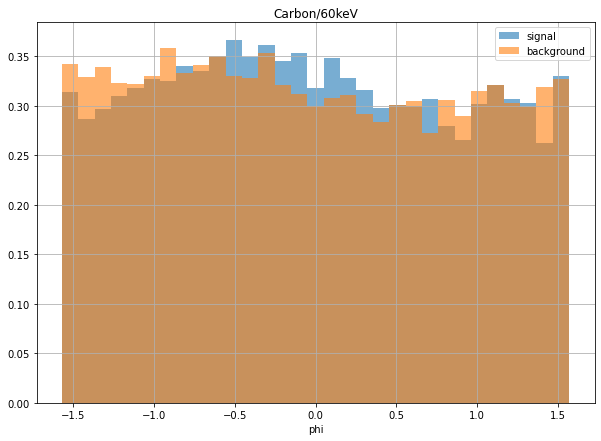

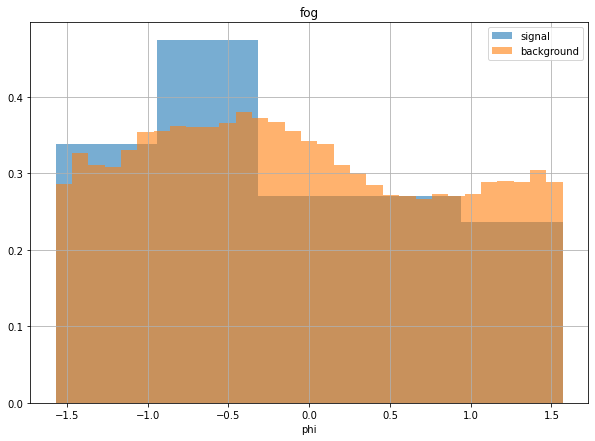

In [86]:
copa = test_feats[test_feats['phi']!=0]
for name, sopa in copa.groupby('sample'):
    plt.figure(figsize=(10,7))
    if name=='fog':
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=5, alpha=0.6, label='signal')
    else:
        plt.hist((sopa[sopa['prediction']>0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='signal')
    plt.hist((sopa[sopa['prediction']<0.998])['phi'], density=True, range=(-np.pi/2,np.pi/2), bins=31, alpha=0.6, label='background')
    plt.grid()
    plt.xlabel('phi')
    plt.title(name)
    plt.legend()
    plt.show()

## Performance on validation

# OLD NETWORK

In [9]:
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=4000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.load_model('model_non_iso_50iter_4cl.h5', custom_objects={'swish': swish, 'bentropy':balanced_crossentropy(mu=dict_bay_param['loss_mu'], n_sig_cl=3)})
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 



In [10]:
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']

with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

fog_pred = best_kek.predict_proba(X_fog)
np.savetxt('predict_vs_fog.txt', fog_pred)
print('Carbon vs fog ROC AUC:',best_kek.score(X_fog, y_fog))

del X_fog; gc.collect();

112216/112216 [==============================] - 106s 941us/step
Carbon vs fog ROC AUC: 0.9758568530317201


## Isolated == -1

In [ ]:
if os.path.exists('predict_vs_fog.txt'):
    fog_pred = np.loadtxt('predict_vs_fog.txt')

In [39]:
np.sum(y_fog==3)

34216

In [43]:
fopa = fog_pred[:,:3].sum(axis=1)[y_fog==3]
np.sum(fopa>0.998)

42

In [25]:
y = {'fog':y_fog}#, 'gamma':y_gamma, 'gamma_no':y_gamma_no}
pred = {'fog':fog_pred}#, 'gamma':gamma_pred, 'gamma_no':gamma_no_pred}
col = {'fog':'blue','gamma':'red','gamma_no':'maroon'}

C30keV vs fog
thresh:	 0.99799424 
eff:	 0.32053846153846155 
rej:	 814.6666666666666
C60keV vs fog
thresh:	 0.9979738 
eff:	 0.41715384615384615 
rej:	 814.6666666666666
C100keV vs fog
thresh:	 0.9979729 
eff:	 0.3637692307692308 
rej:	 814.6666666666666


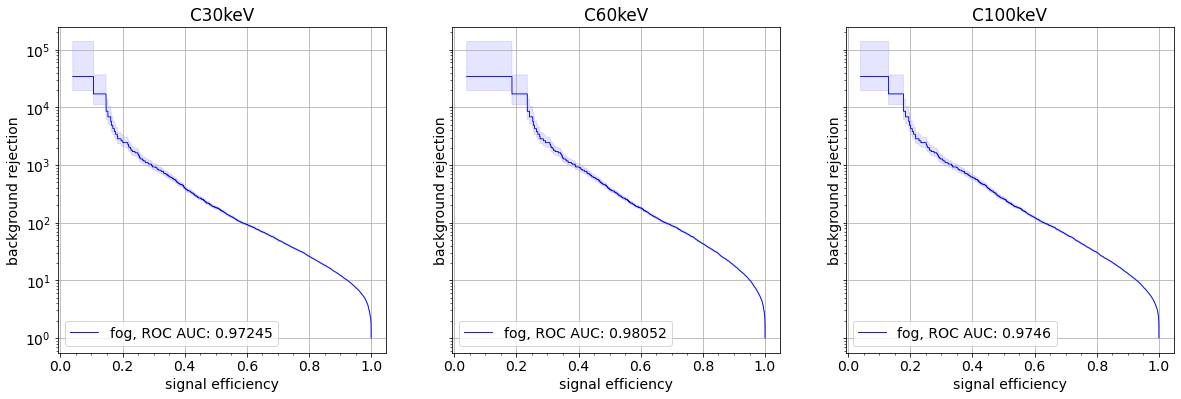

In [98]:
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/'

n_sig_cl=3
#thresh_half = {}
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, len(sign), figsize=(20, 20//len(sign)), sharey=True)
for j,s in enumerate(sign):
    for b in bckg:
        #mask = np.zeros(len(y_val), dtype=bool)
        mask = np.bitwise_or(y[b]==categ_dict[b], y[b]==categ_dict[s])
        preds0 = pred[b][mask]
        y_true_sb = y[b][mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        auc = roc_auc_score(y_true_sb, preds0_sb)
        #preds0_sb[:,1], preds90_sb[:,1] = np.sum(preds0[:,n_sig_cl:],axis=1), np.sum(preds90[:,n_sig_cl:],axis=1)

        #plt.figure(figsize=(7,7))
        fpr, tpr, thr = roc_curve(y_true_sb,preds0_sb)
        
        i_half = np.argmin(thr>0.998) 
        #i_half = np.argmax(tpr>0.35)
        #if s+' '+b in ['C30keV fog','C60keV gamma','C100keV gamma_no']:
        print(s,'vs',b);
        print('thresh:\t',thr[i_half],'\neff:\t',tpr[i_half],'\nrej:\t',(fpr[i_half])**-1)
        thresh_half = thr[i_half]
        
        mask = tpr>0.05
        i=0
        while (not (fpr[mask])[i]): i+=1
        #print(i,len(fpr),'\t',(fpr[mask])[i])
        fpr = np.append([(fpr[mask])[i]], (fpr[mask])[i:])
        tpr = np.append([0.04], (tpr[mask])[i:])
        sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
        axes[j].plot(tpr,(fpr)**-1,linewidth=0.9,color=col[b],label=b+', ROC AUC: '+str(np.round(auc, 5)))
        axes[j].fill( np.append(tpr,tpr[::-1]),np.append((fpr-sigm)**-1,((fpr+sigm)**-1)[::-1]),color=col[b],alpha=0.1 )
    axes[j].legend(loc=3)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    axes[j].set_ylabel('background rejection')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc.png', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

In [13]:
from IPython.utils.capture import capture_output
thresh_half = 0.998
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    # Carbon
#     for kev in df['test/Carbon'].keys():
#         pred = best_kek.predict_proba(df['test/Carbon/'+name+'/images'])
#         preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)
#         print('Carbon '+name+'.')
#         print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'eff:',np.sum(preds_sb>thresh_half)/len(preds_sb))
        
    # background
    for name in df['test'].keys():
        #print('\n')
        if name=='Carbon': 
            for kev in df['test/Carbon'].keys():
                with capture_output() as caput:
                    pred = best_kek.predict_proba(df['test/Carbon/'+kev+'/images'][...])
                    pols = df['test/Carbon/'+kev+'/pol_ids'][...]; mask = (pols[:,-2]==-1) #| (pols[:,-2]==2)
                preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)[mask]
                print('\n','Carbon '+kev)
                print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'eff:',np.sum(preds_sb>thresh_half)/len(preds_sb))
        else:
            with capture_output() as caput:
                pred = best_kek.predict_proba(df['test/'+name+'/images'][...])
                pols = df['test/'+name+'/pol_ids'][...]; mask = pols[:,-2]==-1
            preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)[mask]
            print('\n',name)
            print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'rej:',len(preds_sb)/np.sum(preds_sb>thresh_half))
gc.collect();


 Carbon 100keV
Total: 41872 sign: 16037 eff: 0.38300057317539166

 Carbon 30keV
Total: 71118 sign: 11413 eff: 0.16047976602266656

 Carbon 60keV
Total: 43474 sign: 17729 eff: 0.4078069650825781

 fog
Total: 48253 sign: 26 rej: 1855.8846153846155

 gamma
Total: 24434 sign: 66 rej: 370.2121212121212

 test_sample_2020
Total: 136957 sign: 7064 rej: 19.388023782559458


# Comparing selected signal vs selected background

In [23]:
print(bckg_df.shape, sig_df.shape, feats_test.shape)

(154681, 4) (9715, 4) (164396, 7)


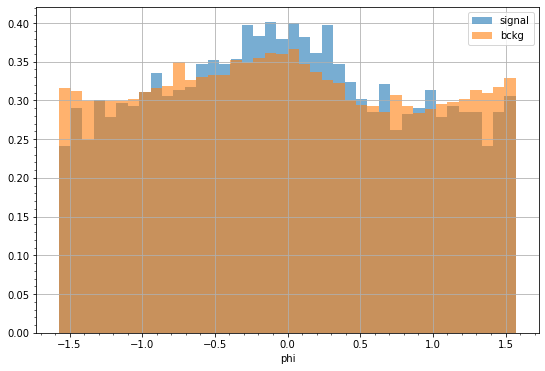

In [56]:
plt.figure(figsize=(9,6))
plt.hist(sig_df['phi'],bins=40,label='signal',alpha=0.6,density=True)
plt.hist(bckg_df['phi'],bins=40,label='bckg',alpha=0.6,density=True)
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlabel('phi');

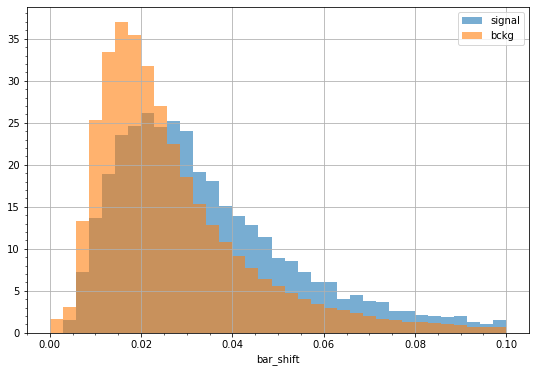

In [57]:
plt.figure(figsize=(9,6))
plt.hist(sig_df['bar_shift'],bins=35,label='signal',alpha=0.6,density=True, range=(0,0.1))
plt.hist(bckg_df['bar_shift'],bins=35,label='bckg',alpha=0.6,density=True, range=(0,0.1))
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlabel('bar_shift');

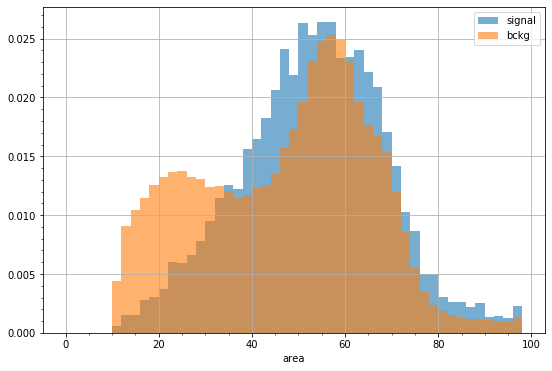

In [58]:
plt.figure(figsize=(9,6))
plt.hist(sig_df['area'],bins=51-2,label='signal',alpha=0.6,density=True, range=(0,98))
plt.hist(bckg_df['area'],bins=51-2,label='bckg',alpha=0.6,density=True, range=(0,98))
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlabel('area');

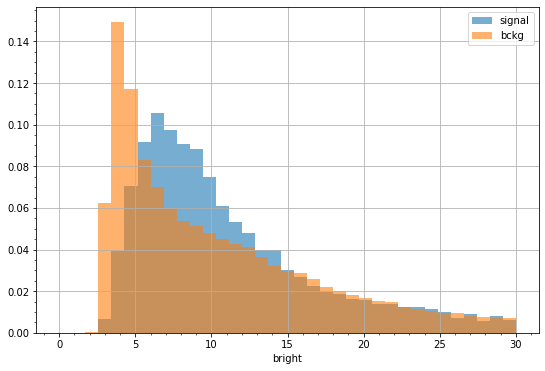

In [59]:
plt.figure(figsize=(9,6))
plt.hist(sig_df['bright'],bins=35,label='signal',alpha=0.6,density=True, range=(0,30))
plt.hist(bckg_df['bright'],bins=35,label='bckg',alpha=0.6,density=True, range=(0,30))
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlabel('bright');

# Test sample 2020

In [130]:
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_checkpoint_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[1])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 10.0,
 'betaa2': 100.0,
 'decay': 0.1,
 'drop_end': 0.0,
 'drop_middle': 0.3,
 'loss_mu': 0.5315105319216414,
 'lr': 0.0006524515878824658,
 'n_conv2': 64,
 'n_conv3': 64,
 'n_resid': 4}

In [131]:
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=50, validation_split=4000, verbose=1, checkpoint_name=None, **dict_bay_param)
best_kek.load_model('model_50iter_4cl.h5', custom_objects={'swish': swish, 'bentropy':balanced_crossentropy(mu=dict_bay_param['loss_mu'], n_sig_cl=3)})
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 50, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.0, 'drop_middle': 0.3, 'loss_mu': 0.5315105319216414, 'lr': 0.0006524515878824658, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 



In [16]:
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    name = 'test_sample_2020'
    print(np.unique(df['test/'+name+'/pol_ids'][:,-2], return_counts=True))

(array([-2, -1,  2], dtype=int32), array([   862, 136957,  15676]))


In [17]:
#from IPython.utils.capture import capture_output
thresh_half = 0.997; n_sig_cl = 3
with h5py.File(dset+'data_ims_scaled_9pol_40.h5','r') as df:
    name = 'test_sample_2020'

    pred = best_kek.predict_proba(df['test/'+name+'/images'][...])
    pol_test = df['test/'+name+'/pol_ids'][...]
    print('\nFull:',np.unique(pol_test[:,-2], return_counts=True))
#     mask = pol_test[:,-2]!=-2
#     pred = pred[mask]
    preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)
    print('\n',name)
    print('Total:',len(preds_sb),'sign:',np.sum(preds_sb>thresh_half),'eff:',np.sum(preds_sb>thresh_half)/len(preds_sb))
    print('\nSignal:',np.unique((pol_test[:,-2])[preds_sb>thresh_half], return_counts=True))
gc.collect();

153495/153495 [==============================] - 143s 935us/step

Full: (array([-2, -1,  2], dtype=int32), array([   862, 136957,  15676]))

 test_sample_2020
Total: 153495 sign: 9715 eff: 0.06329196390761914

Signal: (array([-2, -1,  2], dtype=int32), array([  52, 8250, 1413]))


In [18]:
copa = np.array([  52, 8250, 1413])
np.around(copa/copa.sum()*100, decimals=1)

array([ 0.5, 84.9, 14.5])

In [25]:
feats_test = np.loadtxt('/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/test_sample_2020/sig_grains.txt', delimiter=',')
feats_test = pd.DataFrame(feats_test, columns = ['HeadID','ViewID','grID','bar_shift','phi','area','bright'])
sig_mask = preds_sb>thresh_half

sig_feats = np.zeros((0,7))
for v in np.unique(feats_test['ViewID']):
    tmp_pols = pol_test[sig_mask]; tmp_pols = tmp_pols[tmp_pols[:,1]==v]
    tmp_feats = feats_test[feats_test['ViewID']==v]
    for gr in np.unique(tmp_pols[:,2]):
        feat = tmp_feats[tmp_feats['grID']==gr]
        sig_feats = np.vstack((sig_feats, np.append(feat.index,feat.values[:,1:]))) #[(feat['bar_shift'].values, feat['phi'].values)]
sig_feats[:3]

array([[ 2.11000e+02,  3.00000e+00,  1.00000e+00,  2.08315e-01,
        -7.93575e-01,  6.60000e+01,  1.49545e+01],
       [ 2.30000e+02,  3.00000e+00,  2.40000e+01,  2.76464e-02,
         1.12037e+00,  4.30000e+01,  9.20930e+00],
       [ 2.31000e+02,  3.00000e+00,  2.50000e+01,  1.86084e-01,
        -3.86082e-02,  5.70000e+01,  1.96491e+01]])

In [26]:
sig_df = pd.DataFrame(sig_feats[:,1:], columns=['ViewID','grID','bar_shift','phi','area','bright'], index=np.array(sig_feats[:,0],dtype=int))
sig_df.head()

,ViewID,grID,bar_shift,phi,area,bright
211,3.0,1.0,0.208315,-0.793575,66.0,14.95450
230,3.0,24.0,0.027646,1.120370,43.0,9.20930
231,3.0,25.0,0.186084,-0.038608,57.0,19.64910
239,3.0,34.0,0.045524,-0.670516,56.0,13.03570
240,3.0,35.0,0.021693,0.308467,41.0,5.68293


In [28]:
bckg_id_mask = np.ones(len(feats_test.index), dtype=bool); bckg_id_mask[sig_df.index] = False
bckg_df = feats_test.loc[bckg_id_mask, ['ViewID','grID','bar_shift','phi','area','bright']]
bckg_df.head()

,ViewID,grID,bar_shift,phi,area,bright
0,0.0,0.0,0.051985,-0.045218,21.0,4.47619
1,0.0,1.0,0.031262,-1.494070,46.0,8.43478
2,0.0,2.0,0.034033,-1.247540,41.0,6.53659
3,0.0,3.0,0.019345,-0.466315,22.0,4.04545
4,0.0,4.0,0.013589,-0.546726,55.0,9.60000


## True sign vs false sign

In [36]:
with open('/mnt/NEWS/test_sample_2020Jan/output.txt','r') as tfile:
    test_labels = tfile.read()
test_labels = test_labels.split('\n')[3:-2]
test_labels = np.array([[int(s) for s in oup.split() if s!='*'][1:] for oup in test_labels])
test_labels = pd.DataFrame(test_labels, columns=['sample_id','view_id'])
test_labels.tail(10)

,sample_id,view_id
1590,11,1590
1591,6,1591
1592,8,1592
1593,3,1593
1594,8,1594
1595,13,1595
1596,14,1596
1597,5,1597
1598,1,1598
1599,6,1599


In [35]:
sig_df['sample_id'] = np.zeros(sig_df.shape[0])
for s,v in zip(test_labels['sample_id'],test_labels['view_id']):
    sig_df['sample_id'][sig_df['ViewID']==v] = s
sig_df.tail(10)

,ViewID,grID,bar_shift,phi,area,bright,sample_id
163654,1593.0,107.0,0.051255,-1.460660,58.0,11.84480,3.0
163914,1596.0,14.0,0.009778,-0.013753,38.0,5.89474,14.0
163999,1597.0,13.0,0.015440,1.234000,58.0,11.55170,5.0
164007,1597.0,24.0,0.028520,-1.212470,47.0,7.70213,5.0
164010,1597.0,27.0,0.015851,0.584632,39.0,6.74359,5.0
164089,1598.0,57.0,0.010590,0.801859,63.0,30.68250,1.0
164132,1598.0,100.0,0.008501,1.328240,75.0,33.54670,1.0
164136,1598.0,104.0,0.007919,-0.764788,64.0,28.39060,1.0
164160,1598.0,129.0,0.006547,-0.315763,74.0,32.83780,1.0
164331,1599.0,171.0,0.049612,0.520561,45.0,5.73333,6.0


In [39]:
true_mask = np.logical_or(np.logical_or(sig_df['sample_id']==3, sig_df['sample_id']==4), sig_df['sample_id']==5)
sig_df['true_sign'] = true_mask
sig_df.tail(10)

,ViewID,grID,bar_shift,phi,area,bright,sample_id,true_sign
163654,1593.0,107.0,0.051255,-1.460660,58.0,11.84480,3.0,True
163914,1596.0,14.0,0.009778,-0.013753,38.0,5.89474,14.0,False
163999,1597.0,13.0,0.015440,1.234000,58.0,11.55170,5.0,True
164007,1597.0,24.0,0.028520,-1.212470,47.0,7.70213,5.0,True
164010,1597.0,27.0,0.015851,0.584632,39.0,6.74359,5.0,True
164089,1598.0,57.0,0.010590,0.801859,63.0,30.68250,1.0,False
164132,1598.0,100.0,0.008501,1.328240,75.0,33.54670,1.0,False
164136,1598.0,104.0,0.007919,-0.764788,64.0,28.39060,1.0,False
164160,1598.0,129.0,0.006547,-0.315763,74.0,32.83780,1.0,False
164331,1599.0,171.0,0.049612,0.520561,45.0,5.73333,6.0,False


In [92]:
print(sig_df.shape[0],sig_df['true_sign'].sum(), sig_df.shape[0]-sig_df['true_sign'].sum())

9715 8607 1108


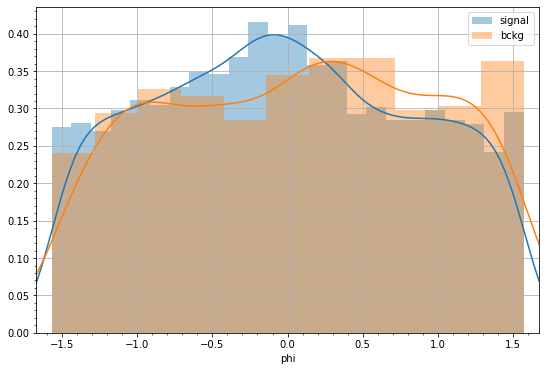

In [80]:
plt.figure(figsize=(9,6))
# plt.hist(sig_df['phi'][sig_df['true_sign']],bins=40,label='signal',alpha=0.6,density=True)
sns.distplot(sig_df['phi'][sig_df['true_sign']], norm_hist=True, label='signal')
sns.distplot(sig_df['phi'][sig_df['true_sign']==0], norm_hist=True, label='bckg')
# plt.hist(sig_df['phi'][sig_df['true_sign']==0],bins=25,label='bckg',alpha=0.6,density=True)
plt.grid()
plt.xlim(-np.pi/2-0.1, np.pi/2+0.1)
plt.minorticks_on()
plt.legend()
plt.xlabel('phi');

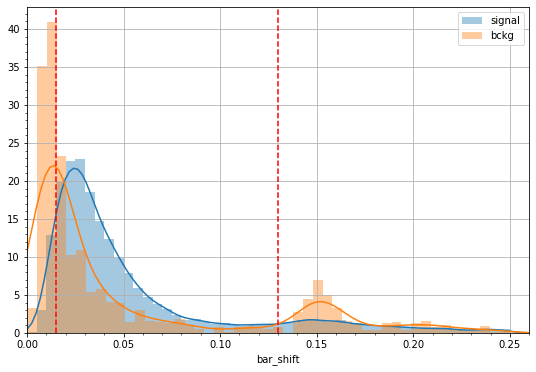

In [222]:
plt.figure(figsize=(9,6))
# plt.hist(sig_df['bar_shift'][sig_df['true_sign']],bins=35,label='signal',alpha=0.6,density=True, range=(0,0.1))
sns.distplot(sig_df['bar_shift'][sig_df['true_sign']], hist_kws={'range':(0,0.25)}, kde_kws={'clip':(0,0.25)}, norm_hist=True, label='signal')
sns.distplot(sig_df['bar_shift'][sig_df['true_sign']==0], hist_kws={'range':(0,0.25)}, kde_kws={'clip':(0,0.25)}, norm_hist=True, label='bckg')
# plt.hist(sig_df['bar_shift'][sig_df['true_sign']==0],bins=35,label='bckg',alpha=0.6,density=True, range=(0,0.1))
plt.grid()
plt.axvline(0.015,c='r',ls='--')
plt.axvline(0.13,c='r',ls='--')
plt.xlim(0,0.26)
plt.minorticks_on()
plt.legend()
plt.xlabel('bar_shift');

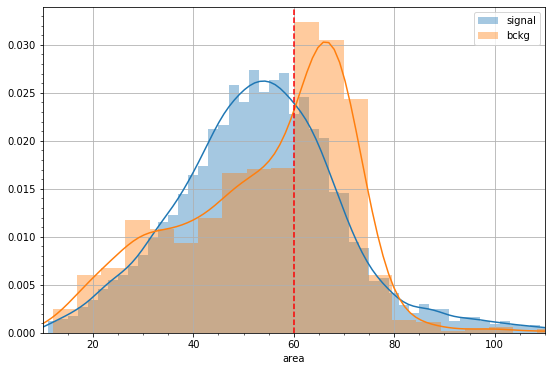

In [221]:
plt.figure(figsize=(9,6))
# plt.hist(sig_df['area'][sig_df['true_sign']],bins=51-2,label='signal',alpha=0.6,density=True, range=(0,98))
sns.distplot(sig_df['area'][sig_df['true_sign']], bins=57, norm_hist=True, label='signal')
sns.distplot(sig_df['area'][sig_df['true_sign']==0], norm_hist=True, label='bckg')
# plt.hist(sig_df['area'][sig_df['true_sign']==0],bins=35,label='bckg',alpha=0.6,density=True, range=(0,98))
plt.grid()
plt.axvline(60,c='r',ls='--')
plt.xlim(10,110)
plt.minorticks_on()
plt.legend()
plt.xlabel('area');

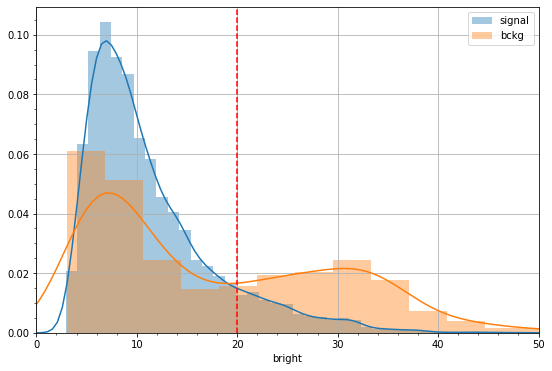

In [220]:
plt.figure(figsize=(9,6))
# plt.hist(sig_df['bright'][sig_df['true_sign']],bins=35,label='signal',alpha=0.6,density=True, range=(0,30))
sns.distplot(sig_df['bright'][sig_df['true_sign']], norm_hist=True, label='signal')
sns.distplot(sig_df['bright'][sig_df['true_sign']==0], norm_hist=True, label='bckg')
# plt.hist(sig_df['bright'][sig_df['true_sign']==0],bins=35,label='bckg',alpha=0.6,density=True, range=(0,30))
plt.grid()
plt.axvline(20,c='r',ls='--')
plt.xlim(0,50)
plt.minorticks_on()
plt.legend()
plt.xlabel('bright');

* barshift: sig = (0.015, 0.13)
* area: sig < 60
* bright: sig < 20

In [218]:
tmp_sig = sig_df[sig_df['bright']<20]
tmp_sig = tmp_sig[tmp_sig['area']<60]
tmp_sig = tmp_sig[tmp_sig['bar_shift']>0.015]
tmp_sig = tmp_sig[tmp_sig['bar_shift']<0.13]
print(tmp_sig.shape, tmp_sig['true_sign'].sum())
print('before:',sig_df.shape[0]-sig_df['true_sign'].sum(), 'after:',tmp_sig.shape[0]-tmp_sig['true_sign'].sum())

(5110, 8) 4800
before: 1108 after: 310


In [219]:
count_sig = {'3':10365, '4':5942, '5':4144}
for i in ['3','4','5']:
    print(i,(tmp_sig['sample_id']==int(i)).sum(), '\tb', np.around((sig_df['sample_id']==int(i)).sum()/count_sig[i]*100, decimals=1),'%','\ta', np.around((tmp_sig['sample_id']==int(i)).sum()/count_sig[i]*100, decimals=1),'%')

3 2502 	b 50.0 % 	a 24.1 %
4 1887 	b 46.5 % 	a 31.8 %
5 411 	b 16.0 % 	a 9.9 %


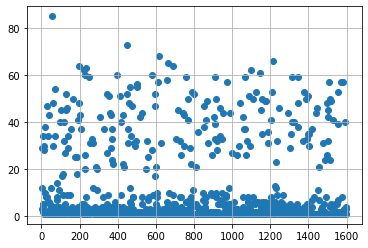

In [78]:
sign_count = np.unique((pol_test[:,1])[preds_sb>thresh_half], return_counts=True)
plt.scatter(sign_count[0], sign_count[1])
plt.grid()

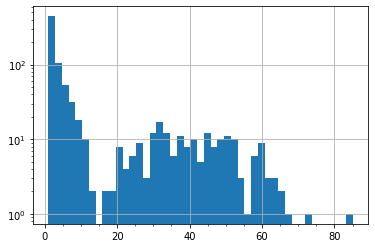

In [79]:
plt.hist(sign_count[1], bins=45);
plt.yscale('log')
plt.grid()
plt.minorticks_on()

In [76]:
with open('/mnt/NEWS/test_sample_2020Jan/output.txt','r') as tfile:
    test_labels = tfile.read()
test_labels = test_labels.split('\n')[3:-2]
test_labels = np.array([[int(s) for s in oup.split() if s!='*'][1:] for oup in test_labels])
test_labels = pd.DataFrame(test_labels, columns=['sample_id','view_id'])
test_labels.head()

,sample_id,view_id
0,10,0
1,13,1
2,14,2
3,5,3
4,4,4


In [83]:
(test_labels.index == test_labels['view_id']).all()

True

In [77]:
test_labels.shape

(1600, 2)

In [80]:
sign_count = pd.DataFrame({'view_id':sign_count[0],'n_sign':sign_count[1],'sample_id':np.zeros(len(sign_count[0]))})
sign_count.head()

,view_id,n_sign,sample_id
0,3,12,0.0
1,4,29,0.0
2,5,3,0.0
3,6,4,0.0
4,7,34,0.0


In [87]:
for i, v in enumerate(sign_count['view_id']):
    sign_count.loc[i,'sample_id'] = test_labels.loc[v,'sample_id']
sign_count.head()

,view_id,n_sign,sample_id
0,3,12,5.0
1,4,29,4.0
2,5,3,1.0
3,6,4,5.0
4,7,34,3.0


In [99]:
for s_id, gr in sign_count.groupby('sample_id'):
    print('sample_id:',int(s_id), '\tn:', gr['n_sign'].sum())

sample_id: 0 	n: 201
sample_id: 1 	n: 384
sample_id: 2 	n: 169
sample_id: 3 	n: 5180
sample_id: 4 	n: 2766
sample_id: 5 	n: 661
sample_id: 6 	n: 66
sample_id: 7 	n: 33
sample_id: 8 	n: 57
sample_id: 9 	n: 33
sample_id: 10 	n: 24
sample_id: 11 	n: 41
sample_id: 12 	n: 19
sample_id: 13 	n: 41
sample_id: 14 	n: 40


In [101]:
all_count = np.unique(pol_test[:,1], return_counts=True)
all_count = pd.DataFrame({'view_id':all_count[0],'n_sign':all_count[1],'sample_id':np.zeros(len(all_count[0]))})
for i, v in enumerate(all_count['view_id']):
    all_count.loc[i,'sample_id'] = test_labels.loc[v,'sample_id']
all_count.head()

,view_id,n_sign,sample_id
0,0,61,10.0
1,1,50,13.0
2,2,89,14.0
3,3,60,5.0
4,4,63,4.0


In [102]:
for s_id, gr in all_count.groupby('sample_id'):
    print('sample_id:',int(s_id), '\tn:', gr['n_sign'].sum())

sample_id: 0 	n: 6544
sample_id: 1 	n: 12603
sample_id: 2 	n: 11845
sample_id: 3 	n: 10365
sample_id: 4 	n: 5942
sample_id: 5 	n: 4144
sample_id: 6 	n: 22288
sample_id: 7 	n: 23020
sample_id: 8 	n: 16561
sample_id: 9 	n: 7300
sample_id: 10 	n: 6982
sample_id: 11 	n: 5573
sample_id: 12 	n: 5819
sample_id: 13 	n: 6735
sample_id: 14 	n: 7774


In [109]:
counts = pd.DataFrame({'sample_id':range(15),'n_all':np.zeros(15),'n_sign':np.zeros(15)})
for s_id, gr in sign_count.groupby('sample_id'):
    counts.loc[s_id,'n_sign'] = gr['n_sign'].sum()
for s_id, gr in all_count.groupby('sample_id'):
    counts.loc[s_id,'n_all'] = gr['n_sign'].sum()
counts['percent'] = np.around(counts['n_sign']/counts['n_all']*100, decimals=1)
counts

,sample_id,n_all,n_sign,percent
0,0,6544.0,201.0,3.1
1,1,12603.0,384.0,3.0
2,2,11845.0,169.0,1.4
3,3,10365.0,5180.0,50.0
4,4,5942.0,2766.0,46.5
5,5,4144.0,661.0,16.0
6,6,22288.0,66.0,0.3
7,7,23020.0,33.0,0.1
8,8,16561.0,57.0,0.3
9,9,7300.0,33.0,0.5


In [111]:
counts.loc[3:5,'n_sign'].sum()/counts.loc[:,'n_sign'].sum()

0.8859495625321667

In [112]:
np.abs(counts.loc[3:5,'n_all'].sum()-counts.loc[:,'n_all'].sum())/np.abs(counts.loc[3:5,'n_sign'].sum()-counts.loc[:,'n_sign'].sum())

120.07581227436823

In [8]:
gc.collect()

0

In [9]:
gc.get_stats()

[{'collections': 2024, 'collected': 24015, 'uncollectable': 0},
 {'collections': 184, 'collected': 30061, 'uncollectable': 0},
 {'collections': 23, 'collected': 329739, 'uncollectable': 0}]

In [10]:
%whos

Variable                    Type               Data/Info
--------------------------------------------------------
Activation                  type               <class 'keras.layers.core.Activation'>
Add                         type               <class 'keras.layers.merge.Add'>
BatchNormalization          type               <class 'keras.layers.norm<...>tion.BatchNormalization'>
Batch_data_augmentator      type               <class 'cnn_utils.Batch_data_augmentator'>
Batch_data_augmentator_np   type               <class 'cnn_utils.Batch_data_augmentator_np'>
Batch_data_generator        type               <class 'cnn_utils.Batch_data_generator'>
Batch_data_generator_np     type               <class 'cnn_utils.Batch_data_generator_np'>
Concatenate                 type               <class 'keras.layers.merge.Concatenate'>
Conv2D                      type               <class 'keras.layers.convolutional.Conv2D'>
Conv3D                      type               <class 'keras.layers.convolut